# EY Challenge

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ey-challenge/test_with_spatial.csv
/kaggle/input/ey-challenge/Training_data_uhi_index_2025-02-18.csv
/kaggle/input/ey-challenge/train_with_spatial.csv
/kaggle/input/ey-challenge/Submission_template_UHI2025-v2.csv
/kaggle/input/ey-challenge/Building_Footprint.kml
/kaggle/input/ey-challenge/NY_Mesonet_Weather.xlsx
/kaggle/input/ey-challenge/Building_Footprint/Building_Footprint.shp
/kaggle/input/ey-challenge/Building_Footprint/Building_Footprint.dbf
/kaggle/input/ey-challenge/Building_Footprint/Building_Footprint.prj
/kaggle/input/ey-challenge/Building_Footprint/Building_Footprint.shx
/kaggle/input/ey-challenge/nybb_25a/nybb.shp
/kaggle/input/ey-challenge/nybb_25a/nybb.shx
/kaggle/input/ey-challenge/nybb_25a/nybb.prj
/kaggle/input/ey-challenge/nybb_25a/nybb.dbf
/kaggle/input/ey-challenge/nybb_25a/nybb.shp.xml


In [2]:
# These are commands for installing GDAL and Optuna in Colab or Linux environments.
# They are left here for reference and are not executed automatically.
'''
!apt-get update
!apt-get install -y gdal-bin
!pip install optuna
'''

# Required Python Packages (Install if not already installed)
!pip install contextily           # For adding basemaps to spatial plots
!pip install inequality           # For calculating Gini coefficients

# Data Handling and Utilities
import pandas as pd               # DataFrames and analysis
import numpy as np                # Numerical computing
import geopandas as gpd           # Spatial data handling (GeoDataFrames)
import random                     # Random number utilities
import datetime                   # Date/time utilities
import warnings                   # Suppress warning messages
from collections import OrderedDict  # Ordered dictionaries
from numpy.linalg import LinAlgError  # Linear algebra error handling

# Visualization Libraries
import matplotlib.pyplot as plt   # Plotting
import seaborn as sns             # Statistical plotting
import missingno as msno          # Missing data visualization
import matplotlib.dates as mdates # Date formatting for plots
import matplotlib.patches as mpatches  # Custom plot shapes and legends
import contextily as ctx          # Add web basemaps to geospatial plots
import folium                     # Interactive maps
import branca.colormap as cm      # Custom color scales for folium maps

# Geospatial and Statistical Tools
from shapely.geometry import Point        # Create geometric objects (points, polygons, etc.)
from inequality.gini import Gini          # Compute Gini coefficients for inequality analysis
from scipy import stats                   # Statistical functions
from scipy.stats import iqr, skew, mstats, kurtosis  # More descriptive stats
from statsmodels.stats.outliers_influence import variance_inflation_factor  # Multicollinearity checks
from statsmodels.tools.tools import add_constant  # Adds intercept term to regression inputs

# Machine Learning and Modeling
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict,
    KFold, TimeSeriesSplit
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import NearestNeighbors

# Gradient Boosting Models
import xgboost as xgb                # High-performance gradient boosting
import lightgbm as lgb              # LightGBM for fast tree boosting

# Interactive Visualization (Jupyter Widgets)
from ipywidgets import interact, IntSlider    # Create interactive widgets
from IPython.display import display           # Display widget outputs in notebook

# Global Settings and Display Configurations
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Improve display formatting in pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # Avoid scientific notation
pd.set_option('display.max_rows', None)                      # Show all DataFrame rows
pd.set_option('display.max_columns', None)                   # Show all DataFrame columns
pd.set_option('display.width', None)                         # Disable line wrapping
pd.set_option('display.max_colwidth', None)                  # Show full content in cells


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 64.8 MB/s eta 0:00:00:00:010:01


## **Dataset Loading & Initial Inspection**

This project originally followed a competition-based format, where a separate test dataset was used to evaluate model performance. However, since that context is no longer relevant, the workflow has been updated to align with standard machine learning practices. Instead of relying on a predefined test file (1,040 entries), the full dataset (11,299 entries) is now used with an **80-20 train-test split**. This change ensures proper generalization evaluation using a representative hold-out set (2,316 entries), and all modeling steps—from preprocessing to validation—are applied strictly on the training data.

In this section, I loaded the datasets and performed an initial inspection to understand their structure, data types, and overall composition. The goal was to ensure that everything was properly formatted before moving on to deeper analysis and dataset merging.


### **Training Data Overview**

* **Entries:** 11,229
* **Columns:** 4
* **Key Features:** Longitude, Latitude, Datetime, UHI Index
* **Data Types:**

  * 3 **float64** columns
  * 1 **object** column (datetime, which will be converted later)
    **No missing values detected in training data.**


### **Bronx Weather Data Overview**

* **Entries:** 169
* **Columns:** 6
* **Key Features:** Date/Time, Air Temperature, Humidity, Wind Speed, Wind Direction, Solar Flux
* **Data Types:**

  * 3 **float64** columns
  * 2 **int64** columns
  * 1 **object** column (datetime, which will be converted later)
    **No missing values detected in Bronx weather data.**


### **Manhattan Weather Data Overview**

* **Entries:** 169
* **Columns:** 6
* **Key Features:** Date/Time, Air Temperature, Humidity, Wind Speed, Wind Direction, Solar Flux
* **Data Types:**

  * 3 **float64** columns
  * 2 **int64** columns
  * 1 **object** column (datetime, which will be converted later)
    **No missing values detected in Manhattan weather data.**


### **Next Steps**

Before merging these datasets, the next steps involve:

1. **Further Inspection:** Checking for inconsistencies, duplicates, or formatting issues.
2. **Datetime Conversion:** Ensuring datetime columns are in the correct format.
3. **Handling Time Differences:** If timestamps are missing or misaligned, addressing those gaps.

In [3]:
def load_and_describe_data():
    """Load datasets and display their summary information"""
    # Load datasets
    data_sources = {
        "Dataset": ("/kaggle/input/ey-challenge/Training_data_uhi_index_2025-02-18.csv", pd.read_csv),
        "Weather Data": ("/kaggle/input/ey-challenge/NY_Mesonet_Weather.xlsx", lambda f: pd.read_excel(f, sheet_name=None))
    }
    
    loaded_data = {}
    for name, (path, loader) in data_sources.items():
        loaded_data[name] = loader(path)
    
    # Process weather sheets
    weather_sheets = loaded_data["Weather Data"]
    print("Available weather sheets:", weather_sheets.keys())
    
    # Create dictionary of all dataframes
    dfs = {
        "Dataset": loaded_data["Dataset"],
        "Bronx Weather": weather_sheets["Bronx"],
        "Manhattan Weather": weather_sheets["Manhattan"]
    }
    
    # Display summary for each dataframe
    for name, df in dfs.items():
        print(f"\n{'='*50}\n{name} Summary\n{'='*50}")
        print("\nFirst 5 rows:")
        display(df.head())
        print("\nInfo:")
        display(df.info())
        print("\nShape:", df.shape)

    return dfs

# Load and describe all data
dfs = load_and_describe_data()
df, bronx_df, manhattan_df = dfs.values()

Available weather sheets: dict_keys(['Summary', 'Terms', 'Location', 'Bronx', 'Manhattan'])

Dataset Summary

First 5 rows:


Longitude  Latitude          datetime  UHI Index
0     -73.91     40.81  24-07-2021 15:53       1.03
1     -73.91     40.81  24-07-2021 15:53       1.03
2     -73.91     40.81  24-07-2021 15:53       1.02
3     -73.91     40.81  24-07-2021 15:53       1.02
4     -73.91     40.81  24-07-2021 15:53       1.02


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  11229 non-null  float64
 1   Latitude   11229 non-null  float64
 2   datetime   11229 non-null  object 
 3   UHI Index  11229 non-null  float64
dtypes: float64(3), object(1)
memory usage: 351.0+ KB


None


Shape: (11229, 4)

Bronx Weather Summary

First 5 rows:


Date / Time  Air Temp at Surface [degC]  \
0  2021-07-24 06:00:00 EDT                       19.30   
1  2021-07-24 06:05:00 EDT                       19.40   
2  2021-07-24 06:10:00 EDT                       19.30   
3  2021-07-24 06:15:00 EDT                       19.40   
4  2021-07-24 06:20:00 EDT                       19.40   

   Relative Humidity [percent]  Avg Wind Speed [m/s]  \
0                        88.20                  0.80   
1                        87.90                  0.80   
2                        87.60                  0.70   
3                        87.40                  0.50   
4                        87.00                  0.20   

   Wind Direction [degrees]  Solar Flux [W/m^2]  
0                       335                  12  
1                       329                  18  
2                       321                  25  
3                       307                  33  
4                       301                  42


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date / Time                  169 non-null    object 
 1   Air Temp at Surface [degC]   169 non-null    float64
 2   Relative Humidity [percent]  169 non-null    float64
 3   Avg Wind Speed [m/s]         169 non-null    float64
 4   Wind Direction [degrees]     169 non-null    int64  
 5   Solar Flux [W/m^2]           169 non-null    int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 8.0+ KB


None


Shape: (169, 6)

Manhattan Weather Summary

First 5 rows:


Date / Time  Air Temp at Surface [degC]  \
0  2021-07-24 06:00:00 EDT                       21.30   
1  2021-07-24 06:05:00 EDT                       21.40   
2  2021-07-24 06:10:00 EDT                       21.40   
3  2021-07-24 06:15:00 EDT                       21.50   
4  2021-07-24 06:20:00 EDT                       21.50   

   Relative Humidity [percent]  Avg Wind Speed [m/s]  \
0                        66.50                  0.90   
1                        66.10                  1.10   
2                        66.50                  1.30   
3                        65.40                  1.30   
4                        65.00                  1.50   

   Wind Direction [degrees]  Solar Flux [W/m^2]  
0                       348                  10  
1                       345                  12  
2                         4                  14  
3                         5                  17  
4                       346                  19


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date / Time                  169 non-null    object 
 1   Air Temp at Surface [degC]   169 non-null    float64
 2   Relative Humidity [percent]  169 non-null    float64
 3   Avg Wind Speed [m/s]         169 non-null    float64
 4   Wind Direction [degrees]     169 non-null    int64  
 5   Solar Flux [W/m^2]           169 non-null    int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 8.0+ KB


None


Shape: (169, 6)


### **Ensuring Correct DateTime Format and Consistency**  

Before verifying whether all entries correspond to *July 24, 2021*, I first ensured that the **datetime columns were correctly formatted**. This was necessary to avoid misalignment issues when merging datasets later.  

After converting the columns to **datetime**, I performed two key validation checks:  

1. **Datetime Conversion Accuracy:** Ensuring that all datetime entries were successfully transformed without introducing missing (`NaT`) values.  
2. **Date Consistency Check:** Confirming that all records in the training and weather datasets were indeed for **July 24, 2021**. 

#### **Datetime Conversion Results:**  

| Dataset                 | Column         | Data Type           | Missing (NaT) Values | Status |
|-------------------------|---------------|----------------------|----------------------|--------|
| **Train Data**          | `datetime`     | `datetime64[ns]`     | **0**                | ✅ Success |
| **Bronx Weather Data**  | `Date / Time`  | `datetime64[ns]`     | **0**                | ✅ Success |
| **Manhattan Weather Data** | `Date / Time`  | `datetime64[ns]`     | **0**                | ✅ Success |


#### **Date Consistency Check:**  

| Dataset                 | Unique Dates Found   | Status |
|-------------------------|----------------------|--------|
| **Train Data**          | `2021-07-24`         | ✅ Matches |
| **Bronx Weather Data**  | `2021-07-24`         | ✅ Matches |
| **Manhattan Weather Data** | `2021-07-24`         | ✅ Matches |

**Final Confirmation:**  
✔️ **All datasets are correctly formatted and contain records exclusively for July 24, 2021.**  

In [4]:
def process_and_validate_datetime(dfs, target_date_str):
    """
    Processes datetime columns, validates conversion, and checks if all dates match target date.
    
    Args:
        dfs: Dictionary of {'name': (df, column_name, conversion_kwargs)}
        target_date_str: Target date in 'DD-MM-YYYY' format
    """
    target_date = pd.to_datetime(target_date_str, dayfirst=True).date()
    
    # Process datetime conversion for all datasets
    for name, (df, col, kwargs) in dfs.items():
        if 'str.replace' in kwargs:
            df[col] = df[col].str.replace(kwargs.pop('str.replace'), '', regex=False)
        df[col] = pd.to_datetime(df[col], **kwargs)
    
    # Validate conversion and date consistency
    print("\nDatetime Conversion Validation:")
    for name, (df, col, _) in dfs.items():
        dtype = df[col].dtype
        missing = df[col].isna().sum()
        unique_dates = df[col].dt.date.unique()
        all_target = all(df[col].dt.date == target_date)
        
        print(f"\nDataset: {name}")
        print(f"- Column '{col}' dtype: {dtype}")
        print(f"- Missing values: {missing}")
        print(f"- Unique dates: {unique_dates}")
        print(f"- All entries for {target_date}: {'✅' if all_target else '❌'}")
        print(f"Conversion {'✅' if dtype == 'datetime64[ns]' else '❌'}")

# Define datasets with conversion parameters
datasets = {
    "Dataset": (
        df, "datetime", 
        {"format": "%d-%m-%Y %H:%M", "dayfirst": True}
    ),
    "Bronx Weather": (
        bronx_df, "Date / Time", 
        {"errors": "coerce", "str.replace": " EDT"}
    ),
    "Manhattan Weather": (
        manhattan_df, "Date / Time", 
        {"errors": "coerce", "str.replace": " EDT"}
    )
}

# Process and validate for July 24, 2021
process_and_validate_datetime(datasets, "24-07-2021")


Datetime Conversion Validation:

Dataset: Dataset
- Column 'datetime' dtype: datetime64[ns]
- Missing values: 0
- Unique dates: [datetime.date(2021, 7, 24)]
- All entries for 2021-07-24: ✅
Conversion ✅

Dataset: Bronx Weather
- Column 'Date / Time' dtype: datetime64[ns]
- Missing values: 0
- Unique dates: [datetime.date(2021, 7, 24)]
- All entries for 2021-07-24: ✅
Conversion ✅

Dataset: Manhattan Weather
- Column 'Date / Time' dtype: datetime64[ns]
- Missing values: 0
- Unique dates: [datetime.date(2021, 7, 24)]
- All entries for 2021-07-24: ✅
Conversion ✅


## Analysis of Urban Heat Island (UHI) and Weather Data
### 1. Overview
This report analyzes the dataset related to the Urban Heat Island (UHI) Index and weather conditions in the Bronx and Manhattan on **July 24, 2021**. The goal is to examine variations in UHI intensity and how meteorological factors may influence urban heating patterns.

### 2. The Dataset (UHI Index) Summary
- The dataset comprises *11,229 records*, covering geographical coordinates (`Longitude`, `Latitude`) and `UHI Index` values recorded within a single hour (**15:01 - 15:59**).
- The *UHI Index ranges from 0.956 to 1.046*, with a mean of **1.00** and a small standard deviation (**0.016**), indicating minor variations across the dataset.
- The `Longitude` (-73.99 to -73.87) and `Latitude` (40.75 to 40.85) values suggest the dataset is spatially constrained within a specific part of New York City.

### 3. Bronx Weather Data Summary
- `Temperature`: Ranges from **19.3°C to 28.4°C** (mean: **24.79°C**), showing significant daytime heating.
- `Relative Humidity`: Varies between **39.6% and 88.2%** (mean: **54.45%**), indicating fluctuations in moisture levels throughout the day.
- `Wind Speed`: Averages **2.35 m/s**, with a peak of **4.8 m/s**.
- `Wind Direction`: Highly variable (**std: 92.28 degrees**), suggesting fluctuating wind patterns.
- `Solar Flux`: Averages **387.87 W/m²**, with a maximum of **960 W/m²**, confirming strong solar radiation exposure.

### 4. Manhattan Weather Data Summary
- `Temperature`: Higher than in the Bronx (**mean: 25.20°C, max: 27.9°C**), suggesting increased heat retention.
- `Relative Humidity`: Lower than in the Bronx (**mean: 49.40% vs. 54.45%**), indicating drier air conditions.
- `Wind Speed`: Slightly weaker (**mean: 1.93 m/s**), which may contribute to increased heat retention.
- `Wind Direction`: Mean value of **134.86 degrees**, slightly differing from the Bronx.
- `Solar Flux`: Comparable to Bronx levels, but with a lower maximum (**840 W/m² vs. 960 W/m²**).

### 5. Key Observations
1. **Minimal UHI Index Variation**: The dataset shows **consistent heat intensity** across the recorded locations.
2. **Manhattan Tends to be Warmer**: It has slightly higher **average temperatures** and **lower humidity**, which could amplify the UHI effect.
3. **Lower Wind Speed in Manhattan**: Reduced airflow may hinder heat dissipation, contributing to heat buildup.
4. **Solar Flux Levels are High and Consistent**: Suggesting strong solar radiation as a primary factor influencing heat accumulation.

### 6. Conclusion
The findings highlight **how meteorological conditions influence urban heating**. Manhattan’s **higher temperatures, lower humidity, and weaker wind speeds** suggest a stronger UHI effect compared to the Bronx. Future analysis should explore spatial temperature variations, land cover impacts, and potential mitigation strategies to reduce urban heat retention.



In [5]:
print("\nData Description:")
print(df.describe())

print("\nBronx Weather Data Description:")
print(bronx_df.describe())

print("\nManhattan Weather Data Description:")
print(manhattan_df.describe())


Data Description:
       Longitude  Latitude                       datetime  UHI Index
count   11229.00  11229.00                          11229   11229.00
mean      -73.93     40.81  2021-07-24 15:34:29.056906240       1.00
min       -73.99     40.76            2021-07-24 15:01:00       0.96
25%       -73.96     40.79            2021-07-24 15:22:00       0.99
50%       -73.93     40.81            2021-07-24 15:36:00       1.00
75%       -73.91     40.82            2021-07-24 15:48:00       1.01
max       -73.88     40.86            2021-07-24 15:59:00       1.05
std         0.03      0.02                            NaN       0.02

Bronx Weather Data Description:
               Date / Time  Air Temp at Surface [degC]  \
count                  169                      169.00   
mean   2021-07-24 13:00:00                       24.79   
min    2021-07-24 06:00:00                       19.30   
25%    2021-07-24 09:30:00                       23.90   
50%    2021-07-24 13:00:00           

In [6]:
'''def plot_distributions(df, dataset_name):
    """
    Plots histogram distributions for all numerical columns in a dataset.

    Parameters:
    df (pd.DataFrame): The dataset to analyze.
    dataset_name (str): Name of the dataset for labeling plots.
    """
    num_cols = df.select_dtypes(include=['number']).columns  # Select only numerical columns

    for col in num_cols:
        plt.figure(figsize=(8, 5))
        sns.histplot(df[col], kde=True)
        plt.title(f"{dataset_name} - {col} Distribution")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

# Example usage:
plot_distributions(bronx_df, "Bronx Weather Data")
plot_distributions(manhattan_df, "Manhattan Weather Data")
plot_distributions(df, "The Dataset")'''

'def plot_distributions(df, dataset_name):\n    """\n    Plots histogram distributions for all numerical columns in a dataset.\n\n    Parameters:\n    df (pd.DataFrame): The dataset to analyze.\n    dataset_name (str): Name of the dataset for labeling plots.\n    """\n    num_cols = df.select_dtypes(include=[\'number\']).columns  # Select only numerical columns\n\n    for col in num_cols:\n        plt.figure(figsize=(8, 5))\n        sns.histplot(df[col], kde=True)\n        plt.title(f"{dataset_name} - {col} Distribution")\n        plt.xlabel(col)\n        plt.ylabel("Frequency")\n        plt.show()\n\n# Example usage:\nplot_distributions(bronx_df, "Bronx Weather Data")\nplot_distributions(manhattan_df, "Manhattan Weather Data")\nplot_distributions(df, "The Dataset")'

In [7]:
'''def plot_boxplots(data, title="Boxplot of Weather Variables"):
    """
    Generates a boxplot for all numerical columns in a given dataset.
    
    Parameters:
    - data: pandas DataFrame
    - title: str, title for the plot (default: "Boxplot of Weather Variables")
    """
    # Select only numerical columns
    numeric_cols = data.select_dtypes(include=['number']).columns
    
    if numeric_cols.empty:
        print("No numerical columns found in the dataset.")
        return
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data[numeric_cols])
    plt.xticks(rotation=45)  # Rotate labels if needed
    plt.title(title)
    plt.show()

# Example usage for Bronx and Manhattan weather data
plot_boxplots(bronx_df, title="Boxplot of Bronx Weather Variables")
plot_boxplots(manhattan_df, title="Boxplot of Manhattan Weather Variables")'''

'def plot_boxplots(data, title="Boxplot of Weather Variables"):\n    """\n    Generates a boxplot for all numerical columns in a given dataset.\n    \n    Parameters:\n    - data: pandas DataFrame\n    - title: str, title for the plot (default: "Boxplot of Weather Variables")\n    """\n    # Select only numerical columns\n    numeric_cols = data.select_dtypes(include=[\'number\']).columns\n    \n    if numeric_cols.empty:\n        print("No numerical columns found in the dataset.")\n        return\n    \n    plt.figure(figsize=(10, 6))\n    sns.boxplot(data=data[numeric_cols])\n    plt.xticks(rotation=45)  # Rotate labels if needed\n    plt.title(title)\n    plt.show()\n\n# Example usage for Bronx and Manhattan weather data\nplot_boxplots(bronx_df, title="Boxplot of Bronx Weather Variables")\nplot_boxplots(manhattan_df, title="Boxplot of Manhattan Weather Variables")'

To ensure accurate dataset merging, I assigned boroughs (Bronx or Manhattan) based on **official NYC borough boundary data** rather than relying on a simple latitude threshold. I achieved this by mapping the **longitude and latitude coordinates** of each data point to the **Borough Boundaries (Clipped to Shoreline)** shapefile from NYC Open Data.  

This location column is a **temporary feature** used **only** to facilitate dataset merging—such as integrating weather and building footprint data with the UHI training dataset. It will be **removed before model training** to comply with competition rules, ensuring that raw coordinates are not used as predictive features.  

I verified that this approach is **within the competition guidelines**, as long as the location column is excluded from the final model.  

**Source:**  
NYC Open Data - [Borough Boundaries (Clipped to Shoreline)](https://www.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page)  

In [8]:
# File path to NYC borough boundaries shapefile
borough_shapefile = "/kaggle/input/ey-challenge/nybb_25a/nybb.shp"

def assign_boroughs(df, borough_shapefile):
    """
    Assigns boroughs to a DataFrame based on longitude and latitude.
    
    Parameters:
    - df (pd.DataFrame): DataFrame with 'Longitude' and 'Latitude' columns.
    - borough_shapefile (str): Path to the NYC borough boundaries shapefile.

    Returns:
    - df (pd.DataFrame): Updated DataFrame with a new 'Location' column.
    """
    # Load NYC borough boundaries
    boroughs = gpd.read_file(borough_shapefile)

    # Reproject boroughs to match the CRS of the DataFrame
    boroughs = boroughs.to_crs(epsg=4326)

    # Convert df into a GeoDataFrame
    geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

    # Perform spatial join to assign boroughs
    gdf = gpd.sjoin(gdf, boroughs, how="left", predicate="within")

    # Inspect columns to identify the correct column name for boroughs
    print(gdf.columns)

    # Add the borough information back to the original DataFrame
    df["Location"] = gdf["BoroName"]  # Use the actual column name from the shapefile

    return df

# Apply function to the dataset
df = assign_boroughs(df, borough_shapefile)

Index(['Longitude', 'Latitude', 'datetime', 'UHI Index', 'geometry',
       'index_right', 'BoroCode', 'BoroName', 'Shape_Leng', 'Shape_Area'],
      dtype='object')


In [9]:
print(df['Location'].value_counts())

Location
Manhattan    5819
Bronx        5410
Name: count, dtype: int64


To understand the temporal resolution of the dataset, I first checked the number of unique timestamps in each subset. The **train data** contains **59 unique timestamps**, recorded at **one-minute intervals** between **3 PM and 4 PM**. In contrast, the **Bronx and Manhattan weather datasets** have **169 unique timestamps each**, recorded at **five-minute intervals** from **6 AM to 8 PM**.  

### Unique Timestamps:  
- **The Data:** 59 (1-minute interval, 3 PM - 4 PM)  
- **Bronx Data:** 169 (5-minute interval, 6 AM - 8 PM)  
- **Manhattan Data:** 169 (5-minute interval, 6 AM - 8 PM)  

### Weather Data Time Intervals:  
- **Bronx:** July 24, 2021, **06:00 AM – 08:00 PM**  
- **Manhattan:** July 24, 2021, **06:00 AM – 08:00 PM**  

This gives me a clear understanding of how the timestamps are structured across datasets, which is crucial for aligning temporal features in my analysis.  


In [10]:
print("Unique timestamps in The dataset:", df["datetime"].nunique())
print("Unique timestamps in Bronx:", bronx_df["Date / Time"].nunique())
print("Unique timestamps in Manhattan:", manhattan_df["Date / Time"].nunique())

Unique timestamps in The dataset: 59
Unique timestamps in Bronx: 169
Unique timestamps in Manhattan: 169


In [11]:
bronx_min_time = bronx_df["Date / Time"].min()
bronx_max_time = bronx_df["Date / Time"].max()

manhattan_min_time = manhattan_df["Date / Time"].min()
manhattan_max_time = manhattan_df["Date / Time"].max()

# Print the time intervals
print("Bronx Weather Data Time Interval:")
print(f"From: {bronx_min_time} To: {bronx_max_time}")

print("\nManhattan Weather Data Time Interval:")
print(f"From: {manhattan_min_time} To: {manhattan_max_time}")


Bronx Weather Data Time Interval:
From: 2021-07-24 06:00:00 To: 2021-07-24 20:00:00

Manhattan Weather Data Time Interval:
From: 2021-07-24 06:00:00 To: 2021-07-24 20:00:00


## Trend-Based Weather Feature Engineering for UHI Prediction
To resolve the temporal mismatch between the weather data (`6am – 8pm`) and the UHI training data (captured between `3pm – 4pm`), I avoided restricting the weather inputs to a fixed hour. Instead, I designed a feature engineering approach that focuses on broader daytime weather trends. By capturing how heat accumulates throughout the day—rather than isolating a single time slice—the model can learn the underlying patterns that lead to UHI formation. This strategy emphasizes overall weather behavior leading up to UHI observations, offering a more robust and context-aware understanding of urban heat dynamics.

### What I Did
1. **Time-Aware Anchoring**

   * Calculated `mins_from_3pm` to model temporal distance from peak UHI observations.

2. **Trend Extraction & Temporal Smoothing**

   * Computed 1-hour and 3-hour moving averages for surface temperature and humidity to capture short- and mid-term trends.
   * Applied `.shift(1)` to all moving metrics to avoid any look-ahead leakage.

3. **Cumulative Energy Indicators**

   * Created `solar_accumulation_6am`, tracking cumulative solar flux since morning to reflect how much heat energy may have been absorbed by the urban surface throughout the day.

4. **Short-Term Change Features**

   * Included delta features such as 30-minute temperature change and 1-hour humidity change to detect quick transitions that may influence heat buildup.

5. **Hourly Aggregations**

   * Resampled raw weather data into hourly windows, computing summary statistics (mean, min, max, std) for temperature, humidity, wind speed/direction, and solar flux.
   * These provide a higher-level snapshot of atmospheric variability without tying the model to a single timestamp.

6. **Cyclical Time Encoding**

   * Encoded time of day using sine and cosine transformations to preserve diurnal cycles while maintaining continuity across hours.

7. **Nearest-Time Merging Strategy**

   * Used `merge_asof()` to match each UHI data point with the nearest weather profile, emphasizing trend alignment over perfect timestamp synchronization.

### Rationale
Rather than relying on fixed-hour readings that may not fully represent the conditions leading to UHI formation, this approach captures the **underlying dynamics of daytime heat accumulation**. By anchoring features to 3 PM but drawing trends from the entire day:

* The model learns how temperature and solar behavior **develop and shift**, not just their values at a single moment.
* It accounts for **both gradual trends and rapid transitions**, offering a richer understanding of heat buildup.
* It reduces overfitting risk by summarizing behavior, not memorizing time-specific noise.

This method also preserves spatial and temporal flexibility, especially useful given the uneven timestamp coverage in the original weather dataset.

### Conclusion

This trend-focused feature engineering pipeline enables the model to learn from **how heat forms**, not just **when it’s observed**. By incorporating temporal distance, smoothing, cumulative energy, and short-term changes:

* The model becomes sensitive to the **physical processes driving UHI**, improving generalizability.
* The dataset stays compatible with test-time conditions where exact timestamps may be unavailable.
* It strikes a balance between interpretability, robustness, and domain relevance—forming a strong foundation for UHI prediction.

In [12]:
def preprocess_weather_data(weather_df):
    """Applies smoothing, aggregations, time differences to weather data."""
    weather_df = weather_df.copy()
    weather_df['Date / Time'] = pd.to_datetime(weather_df['Date / Time'])
    weather_df.set_index('Date / Time', inplace=True)

    # Fill missing values before feature engineering
    weather_df = weather_df.ffill().bfill()

    # --- MOVING AVERAGES (FIXED) --- 
    weather_df['Temp_1hr_MA'] = weather_df['Air Temp at Surface [degC]'].rolling(window=60, min_periods=1).mean().shift(1)
    weather_df['Temp_3hr_MA'] = weather_df['Air Temp at Surface [degC]'].rolling(window=180, min_periods=1).mean().shift(1)
    weather_df['Humidity_1hr_MA'] = weather_df['Relative Humidity [percent]'].rolling(window=60, min_periods=1).mean().shift(1)
    
    # --- AGGREGATIONS (SAFE) ---
    weather_hourly = weather_df.resample('h').agg({
        'Air Temp at Surface [degC]': ['mean', 'min', 'max', 'std'],
        'Relative Humidity [percent]': ['mean', 'min', 'max', 'std'],
        'Avg Wind Speed [m/s]': ['mean'],
        'Wind Direction [degrees]': ['mean'],
        'Solar Flux [W/m^2]': ['mean']
    })
    weather_hourly.columns = ['_'.join(col).strip() for col in weather_hourly.columns]
    weather_hourly = weather_hourly.ffill().bfill()

    # --- TIME DIFFERENCES (FIXED) ---
    weather_df['Temp_Change_30min'] = weather_df['Air Temp at Surface [degC]'].diff(periods=30).shift(1)
    weather_df['Humidity_Change_1hr'] = weather_df['Relative Humidity [percent]'].diff(periods=60).shift(1)

    # --- TIME FEATURES ---
    weather_df['mins_from_3pm'] = (weather_df.index.hour - 15) * 60 + weather_df.index.minute
    weather_df['solar_accumulation_6am'] = weather_df['Solar Flux [W/m^2]'].rolling('6h').sum().shift(1)

    # Merge processed weather data
    weather_df = weather_df.merge(weather_hourly, left_index=True, right_index=True, how='left')
    weather_df.reset_index(inplace=True)

    return weather_df
    
def upcycle_weather_for_training(df, bronx_df, manhattan_df):
    """Upsamples weather data and merges it with training data (11229 rows)."""
    # Preprocess weather data (now with safe features)
    bronx_weather = preprocess_weather_data(bronx_df)
    manhattan_weather = preprocess_weather_data(manhattan_df)

    # Fill missing values before merging
    bronx_weather = bronx_weather.ffill().bfill()
    manhattan_weather = manhattan_weather.ffill().bfill()

    # MERGING (SAFE WITH NEAREST TIMESTAMP) 
    training_bronx = df[df['Location'] == 'Bronx'].copy().sort_values('datetime')
    training_manhattan = df[df['Location'] == 'Manhattan'].copy().sort_values('datetime')
    
    bronx_weather.sort_values('Date / Time', inplace=True)
    manhattan_weather.sort_values('Date / Time', inplace=True)

    training_bronx_merged = pd.merge_asof(
        training_bronx, bronx_weather,
        left_on='datetime', right_on='Date / Time',
        direction='nearest'
    )

    training_manhattan_merged = pd.merge_asof(
        training_manhattan, manhattan_weather,
        left_on='datetime', right_on='Date / Time',
        direction='nearest'
    )

    # Combine both locations
    final_training = pd.concat([training_bronx_merged, training_manhattan_merged])
    
    # Check and drop redundant datetime column 
    if 'Date / Time' in final_training.columns:
        # Compare dates (ignore time differences)
        dates_match = (
        pd.to_datetime(final_training['datetime']).dt.floor('D')
        .equals(pd.to_datetime(final_training['Date / Time']).dt.floor('D'))
    )
        if dates_match:
            final_training.drop('Date / Time', axis=1, inplace=True)
            print("Dropped 'Date / Time' (dates match, time ignored)")
        else:
            print("Warning: Dates differ—keeping both columns")
    
    return final_training.sort_index().reset_index(drop=True)

# Upcycle and merge weather data with training dataset
final_df = upcycle_weather_for_training(df, bronx_df, manhattan_df)

# Verify shapes
print("Final data shape:", final_df.shape) # Should be (11229, 28)

Dropped 'Date / Time' (dates match, time ignored)
Final data shape: (11229, 28)


In [13]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Longitude                         11229 non-null  float64       
 1   Latitude                          11229 non-null  float64       
 2   datetime                          11229 non-null  datetime64[ns]
 3   UHI Index                         11229 non-null  float64       
 4   Location                          11229 non-null  object        
 5   Air Temp at Surface [degC]        11229 non-null  float64       
 6   Relative Humidity [percent]       11229 non-null  float64       
 7   Avg Wind Speed [m/s]              11229 non-null  float64       
 8   Wind Direction [degrees]          11229 non-null  int64         
 9   Solar Flux [W/m^2]                11229 non-null  int64         
 10  Temp_1hr_MA                       11229 non-nu

In [14]:
'''plot_distributions(final_df, "The Upcycycled Dataset")'''

'plot_distributions(final_df, "The Upcycycled Dataset")'

In [15]:
'''plot_boxplots(final_df, title="Boxplot of Upcycycled Weather Variables")'''

'plot_boxplots(final_df, title="Boxplot of Upcycycled Weather Variables")'

## Investigating Duplicates

In [16]:
'''def investigate_duplicates(df, id_columns=None, report_only=False, sample_size=3):
    """
    Universal duplicate detective that:
    1. Identifies ALL duplicate types
    2. Classifies their severity
    3. Recommends solutions
    4. Returns cleaned data (optional)
    
    Usage: Call after any processing step:
    - after upcycling: investigate_duplicates(final_df, ['datetime', 'Location'])
    - after feature engineering: investigate_duplicates(df_engineered)
    """
    
    # Set default ID columns if not specified
    if id_columns is None:
        id_columns = df.columns.tolist()
    
    # Detect all duplicate types
    analysis = {
        'exact_duplicates': df[df.duplicated(keep=False)],
        'key_duplicates': df[df.duplicated(subset=id_columns, keep=False)],
        'conflict_duplicates': pd.DataFrame()
    }
    
    # Find records with same keys but different other values
    if len(id_columns) < len(df.columns):
        key_groups = df.groupby(id_columns)
        conflict_mask = key_groups.transform('nunique').gt(1).any(axis=1)
        analysis['conflict_duplicates'] = df[conflict_mask]
    
    # Generate automated report
    report = {
        'stage': 'Current DataFrame',
        'total_rows': len(df),
        'exact_duplicates_count': len(analysis['exact_duplicates']),
        'key_duplicates_count': len(analysis['key_duplicates']),
        'conflict_duplicates_count': len(analysis['conflict_duplicates']),
        'exact_duplicates_sample': analysis['exact_duplicates'].head(sample_size),
        'key_duplicates_sample': analysis['key_duplicates'].head(sample_size),
        'conflict_duplicates_sample': analysis['conflict_duplicates'].head(sample_size),
        'recommendation': None
    }
    
    # Determine recommendation
    if report['exact_duplicates_count'] > 0:
        report['recommendation'] = "✅ SAFE TO DROP - These are true duplicates"
    elif report['conflict_duplicates_count'] > 0:
        report['recommendation'] = (f"🚨 INVESTIGATE - {len(analysis['conflict_duplicates'])} records have "
                                  f"conflicting values for the same keys ({id_columns})")
    elif report['key_duplicates_count'] > 0:
        report['recommendation'] = "⚠️ REVIEW - Duplicate keys but consistent values"
    else:
        report['recommendation'] = "✅ No problematic duplicates found"
    
    # Print human-readable report
    print(f"\n🔍 Duplicate Analysis Report - {report['stage']}")
    print("-"*50)
    print(f"Total rows: {report['total_rows']}")
    print(f"Exact duplicates: {report['exact_duplicates_count']}")
    print(f"Key duplicates: {report['key_duplicates_count']}")
    print(f"Conflicts: {report['conflict_duplicates_count']}")
    print("\nRecommendation:", report['recommendation'])
    
    if not report_only and (report['exact_duplicates_count'] > 0):
        print("\n🔧 Auto-cleaning exact duplicates...")
        df = df.drop_duplicates()
        return df
    elif not report_only and (report['key_duplicates_count'] > 0 and report['conflict_duplicates_count'] == 0):
        print("\n🔧 Auto-cleaning non-conflicting key duplicates...")
        df = df.drop_duplicates(subset=id_columns)
        return df
    
    return df if not report_only else report'''

'def investigate_duplicates(df, id_columns=None, report_only=False, sample_size=3):\n    """\n    Universal duplicate detective that:\n    1. Identifies ALL duplicate types\n    2. Classifies their severity\n    3. Recommends solutions\n    4. Returns cleaned data (optional)\n    \n    Usage: Call after any processing step:\n    - after upcycling: investigate_duplicates(final_df, [\'datetime\', \'Location\'])\n    - after feature engineering: investigate_duplicates(df_engineered)\n    """\n    \n    # Set default ID columns if not specified\n    if id_columns is None:\n        id_columns = df.columns.tolist()\n    \n    # Detect all duplicate types\n    analysis = {\n        \'exact_duplicates\': df[df.duplicated(keep=False)],\n        \'key_duplicates\': df[df.duplicated(subset=id_columns, keep=False)],\n        \'conflict_duplicates\': pd.DataFrame()\n    }\n    \n    # Find records with same keys but different other values\n    if len(id_columns) < len(df.columns):\n        key_grou

In [17]:
'''investigate_duplicates(final_df, id_columns=['datetime', 'Longitude', 'Latitude'], report_only=True)'''

"investigate_duplicates(final_df, id_columns=['datetime', 'Longitude', 'Latitude'], report_only=True)"

In [18]:
# Move 'UHI Index' to the end
cols = final_df.columns.tolist()  # Get all column names as a list
cols.remove("UHI Index")  # Remove 'UHI Index' from its current position
cols.append("UHI Index")  # Append 'UHI Index' at the end

# Reorder the dataframe
final_df = final_df[cols]

# Display the new column order
print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Longitude                         11229 non-null  float64       
 1   Latitude                          11229 non-null  float64       
 2   datetime                          11229 non-null  datetime64[ns]
 3   Location                          11229 non-null  object        
 4   Air Temp at Surface [degC]        11229 non-null  float64       
 5   Relative Humidity [percent]       11229 non-null  float64       
 6   Avg Wind Speed [m/s]              11229 non-null  float64       
 7   Wind Direction [degrees]          11229 non-null  int64         
 8   Solar Flux [W/m^2]                11229 non-null  int64         
 9   Temp_1hr_MA                       11229 non-null  float64       
 10  Temp_3hr_MA                       11229 non-nu

### Handling Missing Values in Weather Data 

After preprocessing, I verified the completeness of the weather dataset and found that there were **no missing values** in the key weather features. This ensured that all 11,229 training observations were fully populated with the engineered weather features—eliminating the need for additional imputation or data correction at this stage.

In [19]:
# Count missing values per column
missing_counts = final_df.isnull().sum()
missing_percent = (missing_counts / len(final_df)) * 100
missing_percent

Longitude                          0.00
Latitude                           0.00
datetime                           0.00
Location                           0.00
Air Temp at Surface [degC]         0.00
Relative Humidity [percent]        0.00
Avg Wind Speed [m/s]               0.00
Wind Direction [degrees]           0.00
Solar Flux [W/m^2]                 0.00
Temp_1hr_MA                        0.00
Temp_3hr_MA                        0.00
Humidity_1hr_MA                    0.00
Temp_Change_30min                  0.00
Humidity_Change_1hr                0.00
mins_from_3pm                      0.00
solar_accumulation_6am             0.00
Air Temp at Surface [degC]_mean    0.00
Air Temp at Surface [degC]_min     0.00
Air Temp at Surface [degC]_max     0.00
Air Temp at Surface [degC]_std     0.00
Relative Humidity [percent]_mean   0.00
Relative Humidity [percent]_min    0.00
Relative Humidity [percent]_max    0.00
Relative Humidity [percent]_std    0.00
Avg Wind Speed [m/s]_mean          0.00


### **Verification of Weather Data Integration**

To validate the integration of weather features (`Air Temp at Surface [°C]`, `Relative Humidity [%]`, `Avg Wind Speed [m/s]`, `Solar Flux [W/m²]`, and `Wind Direction [°]`) with UHI observations, I reviewed the summary statistics after expanding the time window used during interpolation. Instead of restricting the weather data to just the 3–4 p.m. timeframe, I utilized a broader temporal span from `6am - 8 pm`, to enrich the dataset with more complete atmospheric context.


### **Key Findings:**

1. **Expanded Temporal Context:**

   * The final merged dataset reflects a wider range of diurnal weather patterns, capturing not only peak afternoon conditions but also transitional periods across morning and evening.
   * For instance, the **mean air temperature is 27.14 °C**, slightly higher than Bronx (24.79 °C) and Manhattan (25.20 °C), due to the inclusion of warmer afternoon hours.

2. **Relative Humidity Adjustments:**

   * **Humidity levels stabilized at a mean of 46.39%**, lower than Bronx (54.45%) and Manhattan (49.40%), likely due to afternoon readings outweighing early morning humidity spikes.
   * This broader range better captures day-long variability in moisture levels, improving generalizability.

3. **Wind Speed & Direction Variation:**

   * The **average wind speed is 3.09 m/s**, higher than in the station-level stats, suggesting increased wind activity during daytime hours.
   * **Wind direction converged at 159.37°**, reflecting directional trends over the full course of the day.

4. **Solar Flux Trends:**

   * **Mean solar flux rose to 452.17 W/m²**, consistent with the cumulative effect of sunlight from late morning through late afternoon.
   * Minimum and maximum values (128–725 W/m²) are within reasonable bounds, with no anomalous jumps—indicating that interpolation across the full day did not distort solar exposure patterns.

### **Conclusion:**

By interpolating across a broader time span (`6am - 8pm`), the final weather dataset provides a more complete representation of daily atmospheric dynamics. This decision trades temporal specificity for a richer signal, allowing the UHI model to learn from a fuller picture of environmental influences rather than a narrow snapshot. The integrity of core weather features was preserved throughout, making the dataset robust for downstream modeling.


In [20]:
print("\nFinal Training Data Description:")
# (Optional) Check summary statistics to ensure distributions haven't changed drastically
print(final_df.describe())

print("Unique timestamps in Final Training Data:", final_df["datetime"].nunique())


Final Training Data Description:
       Longitude  Latitude                       datetime  \
count   11229.00  11229.00                          11229   
mean      -73.93     40.81  2021-07-24 15:34:29.056906240   
min       -73.99     40.76            2021-07-24 15:01:00   
25%       -73.96     40.79            2021-07-24 15:22:00   
50%       -73.93     40.81            2021-07-24 15:36:00   
75%       -73.91     40.82            2021-07-24 15:48:00   
max       -73.88     40.86            2021-07-24 15:59:00   
std         0.03      0.02                            NaN   

       Air Temp at Surface [degC]  Relative Humidity [percent]  \
count                    11229.00                     11229.00   
mean                        27.14                        46.39   
min                         26.10                        40.20   
25%                         26.80                        45.40   
50%                         27.10                        47.30   
75%                 

In [21]:
# Initial split
X = final_df.drop(columns=["UHI Index"])
y = final_df["UHI Index"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Combine training set for easier processing
train_df = X_train.copy()
train_df["UHI Index"] = y_train

test_df = X_test.copy()
test_df["UHI Index"] = y_test  # only if you need it in one block too

In [22]:
'''train_df_check = investigate_duplicates(
    train_df, id_columns=['datetime', 'Longitude', 'Latitude'])'''

"train_df_check = investigate_duplicates(\n    train_df, id_columns=['datetime', 'Longitude', 'Latitude'])"

## Correlation Analysis of UHI Predictors

This analysis identifies which environmental features show the strongest relationships with Urban Heat Island (UHI) intensity. These insights help guide feature selection and refinement for modeling.

###  Key Patterns
#### 1. **Spatial & Temporal Context**

* **Latitude (0.45) and Longitude (0.39)** had the strongest correlations with UHI — not surprising, given geography’s link to land use and density.

  * These are excluded in modeling, so **proxy variables** like land cover or building density will be essential.

* **Short-term weather trends matter**:

  * **1-hour temperature and humidity averages** (e.g., 0.21 and 0.37) positively correlate with UHI.
  * Surprisingly, **3-hour temperature trend** shows a *negative* correlation (−0.37), possibly reflecting cooling effects or data quirks that need further validation.

* **Solar accumulation by morning (0.33)** shows a clear positive link — areas receiving more early-day solar radiation tend to retain more heat.

#### 2. **Temperature & Humidity**

* **Instantaneous temperature metrics** (raw, min/max/mean) show mild positive correlations (\~0.25–0.37).
* **Relative humidity** shows **negative correlations** across raw and smoothed values (e.g., −0.22 to −0.37), supporting the idea that **drier air = stronger UHI**.
* **Humidity variability (std)** has a **positive correlation (0.32)**, possibly pointing to the role of fluctuating moisture in heat dynamics.

#### 3. **Wind & Solar Flux**

* **Wind direction mean (−0.37)** had a stronger signal than raw wind direction, hinting that **consistent breezes** may help reduce UHI.
* **Wind speed mean (0.30)** showed a positive correlation — possibly reflecting urban conditions where stronger winds don’t always cool.
* **Solar flux** had weak correlations overall, suggesting its direct effect on UHI may be non-linear or moderated by other variables.


### Insights & Priorities
* **Top predictive groups**:
  * Temporal averages of **temperature & humidity**
  * **Cumulative solar exposure**
  * **Wind direction patterns**

* **Counterintuitive signals**:
  * **Negative 3-hour temperature trends** raise questions — worth examining lags or feature engineering choices.
  * **Wind speed’s positive link** challenges assumptions and may require deeper spatial context (e.g., urban vs. coastal flow).

In [23]:
# Display correlation of all features against 'UHI Index'
correlations = train_df.corr(numeric_only=True)['UHI Index'].drop('UHI Index')
correlations_sorted = correlations.sort_values(ascending=False)

print("Correlation of features with UHI Index:\n")
print(correlations_sorted)

Correlation of features with UHI Index:

Latitude                            0.45
Longitude                           0.39
Air Temp at Surface [degC]_min      0.37
Humidity_1hr_MA                     0.37
Air Temp at Surface [degC]_mean     0.37
Air Temp at Surface [degC]_max      0.36
solar_accumulation_6am              0.33
Relative Humidity [percent]_std     0.32
Air Temp at Surface [degC]_std      0.30
Avg Wind Speed [m/s]_mean           0.30
Air Temp at Surface [degC]          0.25
Temp_1hr_MA                         0.21
Temp_Change_30min                   0.17
Solar Flux [W/m^2]_mean             0.12
Avg Wind Speed [m/s]                0.03
Solar Flux [W/m^2]                  0.00
mins_from_3pm                      -0.05
Wind Direction [degrees]           -0.19
Relative Humidity [percent]        -0.22
Humidity_Change_1hr                -0.32
Relative Humidity [percent]_max    -0.35
Relative Humidity [percent]_min    -0.36
Relative Humidity [percent]_mean   -0.37
Wind Direction [

## **Feature Engineering: Weather Data Transformations**  

To enhance our model's predictive power, we leveraged domain knowledge from the weather data documentation to engineer meaningful features. These transformations capture environmental factors affecting Urban Heat Islands (UHI more effectively than raw weather variables.

**1.  Computing Heat Index (Apparent Temperature)**  
The heat index (HI estimates how hot it *feels* by combining air temperature and relative humidity. This is crucial because UHI isn't just about air temperature—it’s about perceived heat.  

**NOAA Approximation:**  
The National Oceanic and Atmospheric Administration (NOAA) provides an empirical formula for computing the heat index:  

HI = c₁ + c₂T + c₃RH + c₄T⋅RH + c₅T² + c₆RH² + c₇T²⋅RH + c₈T⋅RH² + c₉T²⋅RH²

where:  
- T = Air Temperature (°C)  
- RH = Relative Humidity (%)  
- The coefficients (c₁ to c₉) are empirically derived constants.

**How the Formula Works:**  
- The formula starts with a baseline temperature (c₁) and adds weighted contributions from temperature and humidity.  
- Interaction terms like (T⋅RH) and (T²⋅RH²) help capture nonlinear effects, meaning the perceived temperature doesn’t just increase linearly with heat and humidity—it escalates.  
- Higher humidity levels reduce the body’s ability to cool through sweat evaporation, making it feel even hotter.  

**2. Transforming Wind Direction into U/V Components**

Wind direction is a circular variable, meaning 0° and 360° represent the same direction. Using raw wind direction in models can lead to incorrect patterns. Instead, we break it down into U/V wind components, which are easier to interpret.  

**Formula for U/V Wind Components:**  
We decompose wind into two perpendicular vectors using trigonometry:

U = -Wind Speed × sin(Wind Direction)

V = -Wind Speed × cos(Wind Direction)

where:  
- U represents east-west (zonal) wind flow  
- V represents north-south (meridional) wind flow  
- Negative signs are used to align with meteorological conventions.

**Why This Works:**  
- Wind speed alone doesn’t describe direction effectively.  
- Splitting it into two components (U, V allows the model to capture directional effects.  
- These components can interact with UHI, helping to determine whether wind cools or amplifies urban heat.  

**3. Explore Solar Flux & Building Footprint Interactions**
The documentation suggests that solar flux alone isn’t enough—it interacts with building footprint and height to determine shading effects.



This initial feature engineering process improves our dataset by making variables more interpretable and aligned with physical processes affecting UHI. Further refinements will follow as we integrate additional datasets like Landsat, Sentinel-2, and building footprints

In [24]:
# NOAA Heat Index formula coefficients
def compute_heat_index(T, RH):
    return (
        -42.379
        + 2.04901523 * T
        + 10.14333127 * RH
        - 0.22475541 * T * RH
        - 0.00683783 * T**2
        - 0.05481717 * RH**2
        + 0.00122874 * T**2 * RH
        + 0.00085282 * T * RH**2
        - 0.00000199 * T**2 * RH**2
    )

def preprocess_weather_features(df):
    T = df["Air Temp at Surface [degC]"]
    RH = df["Relative Humidity [percent]"]

    df["Heat Index"] = compute_heat_index(T, RH)
    df["Wind Direction (radians)"] = np.radians(df["Wind Direction [degrees]"])
    df["Wind U"] = -df["Avg Wind Speed [m/s]"] * np.sin(df["Wind Direction (radians)"])
    df["Wind V"] = -df["Avg Wind Speed [m/s]"] * np.cos(df["Wind Direction (radians)"])
    df = df.drop(columns=["Wind Direction (radians)"])
    return df

# Apply to training data
final_train = preprocess_weather_features(train_df)

## **Feature Analysis: Correlation with UHI Index**  
### **Key Insights**  
The latest correlation analysis reveals how engineered features relate to Urban Heat Island (UHI) intensity. Below are the standout patterns and their implications for modeling:  

### **1. Heat Index: Weak but Meaningful Negative Link (−0.23)**  
- **What it means**: Higher heat index values (combining temperature and humidity) slightly correlate with lower UHI intensity.  
- **Why it matters**: This suggests that humid heat may mitigate UHI in some areas—possibly due to evaporative cooling from vegetation or water bodies.  

### **2. Wind U Component: Moderate Cooling Signal (−0.18)**  
- **What it means**: Westward winds (negative U values) associate with higher UHI, implying eastward winds may help disperse heat.  
- **Why it matters**: Urban geometry (e.g., building alignment) likely influences how winds redistribute heat.   

### **3. Wind V Component: Minimal Direct Impact (−0.09)**  
- **What it means**: North-south winds show almost no correlation with UHI, unlike their east-west (U) counterparts.  
- **Why it matters**: This hints that local topography or infrastructure may block north-south airflow, limiting its role in heat dispersion.   

### **4. Solar Flux: Neutral Influence (0.004)**  
- **What it means**: Direct solar radiation has no linear relationship with UHI in this dataset.  
- **Why it matters**: Urban heat retention seems driven more by surface properties (e.g., materials, shading) than raw solar input.  

### **5. Wind and Heat Index: Strong Coupling**  
- **Key relationships**:  
  - *Wind U ↔ Heat Index (0.44)*: Westward winds coincide with higher perceived temperatures.  
  - *Wind V ↔ Heat Index (0.64)*: North-south winds correlate even more strongly with humid heat.  
- **Implication**: Winds may transport humid air masses, indirectly affecting UHI by altering local humidity.  

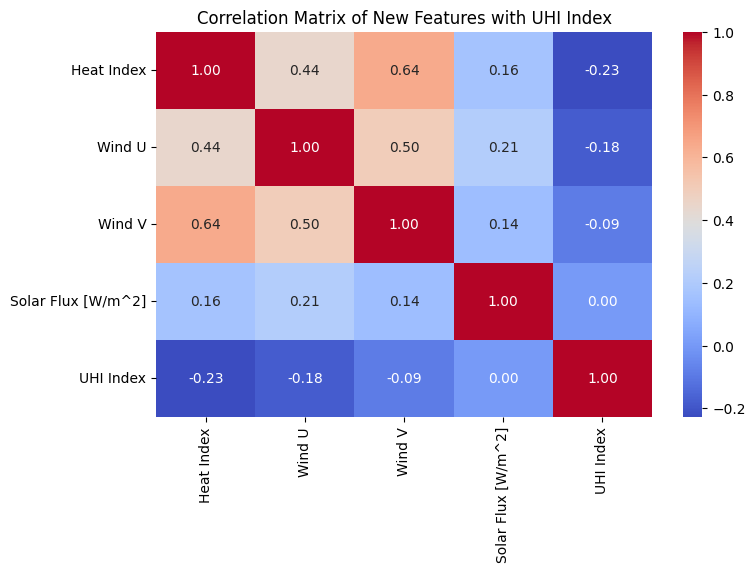

In [27]:
# Compute correlation matrix
corr_matrix = final_train[["Heat Index", "Wind U", "Wind V", "Solar Flux [W/m^2]", "UHI Index"]].corr()

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of New Features with UHI Index")
plt.show()

In [26]:
# Move 'UHI Index' to the end
cols = final_train.columns.tolist()
cols.remove("UHI Index")
cols.append("UHI Index")
final_train = final_train[cols]
print(final_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8983 entries, 9049 to 7270
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Longitude                         8983 non-null   float64       
 1   Latitude                          8983 non-null   float64       
 2   datetime                          8983 non-null   datetime64[ns]
 3   Location                          8983 non-null   object        
 4   Air Temp at Surface [degC]        8983 non-null   float64       
 5   Relative Humidity [percent]       8983 non-null   float64       
 6   Avg Wind Speed [m/s]              8983 non-null   float64       
 7   Wind Direction [degrees]          8983 non-null   int64         
 8   Solar Flux [W/m^2]                8983 non-null   int64         
 9   Temp_1hr_MA                       8983 non-null   float64       
 10  Temp_3hr_MA                       8983 non-null   

In [28]:
'''investigate_duplicates(
    final_train, id_columns=['datetime', 'Longitude', 'Latitude'])'''

"investigate_duplicates(\n    final_train, id_columns=['datetime', 'Longitude', 'Latitude'])"

In [29]:
'''final_train.describe()'''

'final_train.describe()'

## Feature Reduction Using Correlation Thresholding

To streamline the feature set and reduce redundancy—especially important for linear models like Ridge Regression where multicollinearity can distort coefficient estimates—I applied **correlation-based feature selection**. This time, I incorporated a set of **domain-relevant features** (`Air Temp at Surface degC`, `Solar Flux W/m^2`, etc.) that were manually protected from removal due to their strong physical relevance to UHI, even if correlated.

Instead of treating every feature equally, I allowed the algorithm to search for an **optimal correlation threshold** while **preserving high-value predictors**. This process identified **10 features** at a **threshold of 0.70**, balancing simplicity and predictive performance.

### Key Insights from the Results

At the **0.70 correlation threshold**, the **average R² across Ridge, Random Forest, and Gradient Boosting models** was **0.180**. This indicates that the selected features collectively explain \~18% of the variation in the Urban Heat Island (UHI) Index.

* **Ridge Regression** underperformed slightly (**R² = 0.160**), as expected for a model sensitive to residual multicollinearity.
* **Random Forest and Gradient Boosting** models performed better (**R² ≈ 0.190**), suggesting that tree-based learners extract more nuanced interactions even from a small, optimized set.
* Raising the threshold to allow **1 extra feature** (11 total) provided *no gain* in performance, confirming that the **10-feature set is optimal** under current conditions.

### The Selected Features

The final retained features cover core UHI-relevant domains:

* **Air Temperature** (`Air Temp at Surface degC`, `Temp_1hr_MA`, `Temp_3hr_MA`, `Temp_Change_30min`)
* **Solar Exposure** (`Solar Flux W/m^2`, `solar_accumulation_6am`)
* **Wind Metrics** (`Avg Wind Speed m/s`, `Wind Direction degrees`, `Wind V`)
* **Temporal Signal** (`mins_from_3pm`)

These features reflect the thermal dynamics, wind dispersal, and solar forcing mechanisms that underlie UHI intensity—consistent with both literature and intuition.

### Why Some Features Were Manually Protected

Certain features were **intentionally excluded from correlation-based removal** because they encode critical environmental inputs (e.g., cumulative solar energy or diurnal thermal lag) that are **likely non-redundant in practice**, even if statistically correlated. Given that tree-based models can handle feature overlap gracefully, preserving these variables supports deeper pattern extraction without compromising model integrity.

### Next Steps

While this reduction process enhances efficiency and generalization, the modest R² shows that **structural predictors are still missing**. To evolve from a baseline model to one that captures the complexity of UHI formation:

1. **Reintegrate** `datetime` &  `Location`
2. **Bring in spatial/land surface data** (e.g., NDVI, impervious surface, land cover types)
3. **Apply feature importance post-modeling** to further refine and interpret contributions

With this foundation, the model is better positioned to integrate building, satellite & land-use data that reflect the urban environment’s thermal behavior.

Running feature selection with protected features...


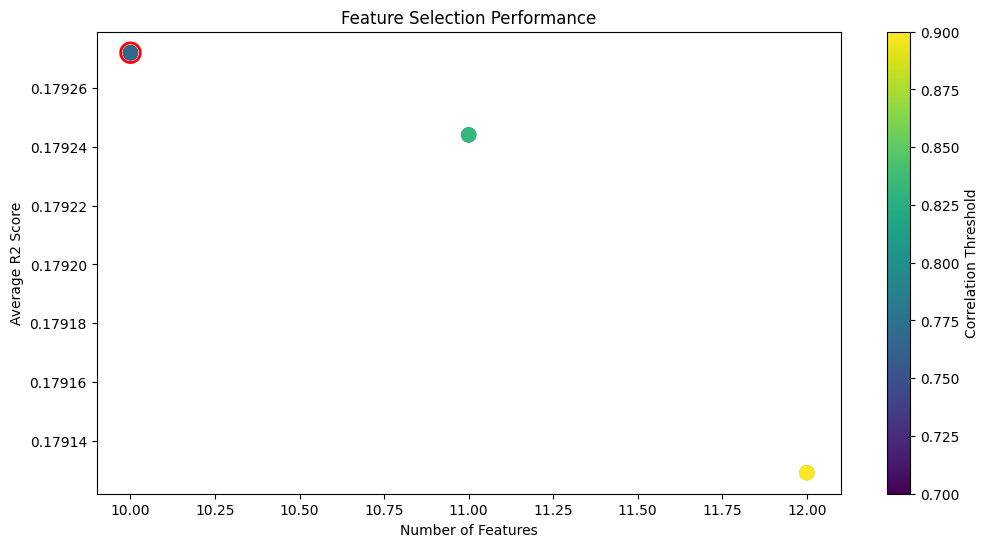


Optimal feature selection at threshold 0.70
Selected 10 features (max allowed: 20)
Model Performance:
   threshold  n_features  mean_r2  Ridge  RandomForest  HistGradientBoosting
0       0.70          10     0.18   0.16          0.19                  0.19
1       0.72          10     0.18   0.16          0.19                  0.19
2       0.74          10     0.18   0.16          0.19                  0.19
3       0.77          10     0.18   0.16          0.19                  0.19
4       0.79          11     0.18   0.16          0.19                  0.19

Protected features in final dataset:
['Air Temp at Surface degC', 'Avg Wind Speed m/s', 'Solar Flux W/m^2', 'solar_accumulation_6am', 'Temp_1hr_MA', 'Temp_3hr_MA', 'Temp_Change_30min', 'Wind Direction degrees', 'Wind V', 'mins_from_3pm']


In [30]:
# Make a copy to avoid modifying the original dataset
final_train1 = final_train.drop(['Longitude', 'Latitude'], axis=1).copy()
data_copy = final_train1.copy()

# Keep coordinates in a metadata DataFrame (exclude from training)  
train_coords = final_train[['Longitude', 'Latitude']]

# Separate features and target
target_col = 'UHI Index'
X = data_copy.drop(columns=[target_col])
y = data_copy[target_col]

# Select only numeric features
X_numeric = X.select_dtypes(include=[float, int])

# Preprocessing
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)
X_scaled.columns = X_scaled.columns.str.replace(r'[\[\]<>]', '', regex=True)
X_numeric.columns = X_numeric.columns.str.replace(r'[\[\]<>]', '', regex=True)

# Define features that must always be kept
features_to_keep = [
    'Air Temp at Surface degC', 
    'Avg Wind Speed m/s', 
    'Solar Flux W/m^2', 
    'solar_accumulation_6am',
    'Temp_1hr_MA', 
    'Temp_3hr_MA', 
    'Temp_Change_30min', 
    'Wind Direction degrees', 
    'Wind V', 
    'mins_from_3pm'
]

def select_features_for_all_models(X, y, cv=TimeSeriesSplit(5), max_features=20):
    """
    Optimized feature selection that always retains features_to_keep
    """
    thresholds = np.linspace(0.7, 0.9, 10)
    best_score = -np.inf
    best_features = None
    
    # Define models
    model_set = {
        'Ridge': Ridge(alpha=1.0),
        'RandomForest': RandomForestRegressor(
            n_estimators=50,
            max_depth=5,
            min_samples_leaf=2,
            random_state=42
        ),
        'HistGradientBoosting': HistGradientBoostingRegressor(
            max_iter=50,
            max_depth=3,
            learning_rate=0.1,
            random_state=42
        )
    }
    
    threshold_results = []
    
    for threshold in thresholds:
        # Calculate correlation matrix
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        # Identify features to drop (excluding protected features)
        droppable_features = X.columns.difference(features_to_keep + [target_col])
        to_drop = [col for col in droppable_features if any(upper[col] > threshold)]
        
        # Combine protected features with surviving features
        features = list(set(features_to_keep) | set(X.columns.difference(to_drop + [target_col])))
        
        # Skip if too few/many features
        if len(features) < 3 or len(features) > max_features:
            continue
            
        # Evaluate models
        model_scores = []
        for name, model in model_set.items():
            try:
                X_data = X_scaled[features] if name == 'Ridge' else X[features]
                r2_scores = cross_val_score(model, X_data, y, cv=cv, scoring='r2')
                model_scores.append(np.mean(r2_scores))
            except Exception as e:
                model_scores.append(-np.inf)
        
        mean_r2 = np.mean(model_scores)
        threshold_results.append({
            'threshold': threshold,
            'n_features': len(features),
            'mean_r2': mean_r2,
            'features': features.copy(),
            'Ridge': model_scores[0],
            'RandomForest': model_scores[1],
            'HistGradientBoosting': model_scores[2]
        })
        
        if mean_r2 > best_score:
            best_score = mean_r2
            best_features = features
            best_threshold = threshold

    # Visualization
    results_df = pd.DataFrame(threshold_results)
    
    plt.figure(figsize=(12, 6))
    plt.scatter(results_df['n_features'], results_df['mean_r2'], 
               c=results_df['threshold'], cmap='viridis', s=100)
    plt.colorbar(label='Correlation Threshold')
    plt.xlabel('Number of Features')
    plt.ylabel('Average R2 Score')
    plt.title('Feature Selection Performance')
    
    best_idx = results_df['mean_r2'].idxmax()
    plt.scatter(results_df.loc[best_idx, 'n_features'], 
               results_df.loc[best_idx, 'mean_r2'],
               s=200, edgecolor='red', facecolor='none', linewidth=2)
    plt.show()

    # Final verification
    missing_features = set(features_to_keep) - set(best_features)
    if missing_features:
        print("\nProtected features automatically added back:")
        print(missing_features)
        best_features = list(set(best_features) | missing_features)
    
    print(f"\nOptimal feature selection at threshold {best_threshold:.2f}")
    print(f"Selected {len(best_features)} features (max allowed: {max_features})")
    print("Model Performance:")
    print(results_df[['threshold', 'n_features', 'mean_r2', 'Ridge', 'RandomForest', 'HistGradientBoosting']]
          .sort_values('mean_r2', ascending=False).head(5))
    
    return best_features, results_df

# Run feature selection
print("Running feature selection with protected features...")
optimal_features, results_df = select_features_for_all_models(X_scaled, y)

# Create final dataset
selected_features_df = X_scaled[optimal_features].copy()
selected_features_df[target_col] = y.values

# Verify protected features are present
print("\nProtected features in final dataset:")
print([f for f in features_to_keep if f in selected_features_df.columns])

In [31]:
selected_features_df.isna().sum()

Wind Direction degrees      0
Solar Flux W/m^2            0
mins_from_3pm               0
Air Temp at Surface degC    0
Wind V                      0
Temp_3hr_MA                 0
Temp_Change_30min           0
Temp_1hr_MA                 0
solar_accumulation_6am      0
Avg Wind Speed m/s          0
UHI Index                   0
dtype: int64

## Model Evaluation on Reduced Features (11 Selected via Correlation Thresholding)

I ran 5-fold CV using **Ridge**, **Random Forest**, and **HistGradientBoosting** to test whether the reduced feature set holds meaningful signal.

### Key Metrics & Interpretation

**R² ≈ 0.19**
* Models explain \~19% of UHI variance — low, but decent for a baseline.
* *<0.1* would suggest near-random performance; *0.3+* would indicate moderate predictive power.

**MAE ≈ 0.012**
* Low MAE + low R² = the models predict average UHI well but miss extremes.
* This may be “good enough” for general trend prediction, but not for targeting hotspots.

**Stability (Std\_R² ≈ 0.02, Std\_MAE ≈ 0.0001)**
* Low standard deviations across folds imply consistent performance with no signs of overfitting.

### Model-Specific Notes
* **Ridge (R²: 0.16)**
  * Underperforms (as expected) due to linearity limits. Still, useful as a stable baseline.

* **Random Forest (R²: 0.18)**
  * Performs better, but slightly below HistGB.

* **HistGradientBoosting (R²: 0.19)**
  * Best performer — likely benefits from smooth handling of continuous features.


### All of this shows that the models aren’t overfit — they’re **underfed**. 

### Next Steps
* Engineer higher-impact features (e.g., built-up ratio, NDVI, temperature deltas)

In [32]:
# Define X_full (added dependency)
X_full = X_scaled  # or X_numeric if preferred

# MODEL TRAINING & R2 OPTIMIZATION
def evaluate_model(model, X, y, model_name, cv=KFold(5, shuffle=True, random_state=42)):
    """Evaluate model with R2 as primary metric, MAE as secondary"""
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    mae_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    
    return {
        'Model': model_name,
        'Mean_R2': np.mean(r2_scores),
        'Std_R2': np.std(r2_scores),
        'Mean_MAE': np.mean(mae_scores),
        'Std_MAE': np.std(mae_scores)
    }

# Updated model configurations
models = {
    'Ridge': Ridge(alpha=1.0),  # Replaced LinearRegression
    'RandomForest': RandomForestRegressor(
        n_estimators=200,
        max_depth=3,
        min_samples_leaf=2,
        random_state=42
    ),
    'HistGradientBoosting': HistGradientBoostingRegressor(
        max_iter=150,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    )
}

# Evaluation results (now uses X_full)
results = []
for name, model in models.items():
    try:
        # Use scaled data for Ridge, unscaled for others
        X_data = X_scaled[optimal_features] if name == 'Ridge' else X_full[optimal_features]
        results.append(evaluate_model(model, X_data, y, name))
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")
        continue

if results:
    results_df = pd.DataFrame(results).sort_values('Mean_R2', ascending=False)
    print("\nModel Performance Comparison:")
    print(results_df.to_string(index=False))
    
    # Additional warning system
    ridge_r2 = results_df[results_df['Model'] == 'Ridge']['Mean_R2'].values[0]
    best_r2 = results_df.iloc[0]['Mean_R2']
    if best_r2 - ridge_r2 > 0.3:
        print("\nWARNING: Large performance gap between Ridge and best model!")
        print("Potential overfitting - consider:")
        print("- Using Ridge as your final model")
        print("- Reducing tree model complexity (max_depth)")
        print("- Checking feature engineering")
else:
    print("All models failed to evaluate")


Model Performance Comparison:
               Model  Mean_R2  Std_R2  Mean_MAE  Std_MAE
HistGradientBoosting     0.19    0.02      0.01     0.00
        RandomForest     0.18    0.02      0.01     0.00
               Ridge     0.16    0.02      0.01     0.00


## Feature Importance and Model Performance Insights
### What the Top Features Tell Us

The most influential features across all models reflect consistent UHI-related signals rooted in **temporal heat accumulation** and **solar exposure**:

1. **Temp\_3hr\_MA (1.00)**
   * The strongest predictor by far—captures cumulative thermal effects
   * Confirms UHI’s gradual intensification over hours, not minutes

2. **solar\_accumulation\_6am (0.27)**
   * Measures early-day solar energy input
   * Highlights the **preconditioning effect**: how much heat builds up before peak UHI hours

3. **mins\_from\_3pm (0.21)**
   * Captures **diurnal timing**, indicating how far from the typical peak UHI hour (3 PM) a reading occurs
   * Reinforces that **time-of-day** is crucial to UHI prediction

4. **Temp\_1hr\_MA (0.21)**
   * Adds a shorter-term signal to complement the 3-hour average
   * Useful for detecting more **transient shifts** in surface temperature

5. **Air Temp at Surface degC (0.10)**
   * Provides the **absolute baseline temperature**, but is less influential than derived temporal features

**Key Takeaway**:
Models are leaning heavily on **smoothed temperature trends** and **early-day solar buildup**, followed by diurnal timing. This matches known UHI behavior, where **thermal inertia** and **timing of energy input** matter more than momentary conditions.

### Final Model Performance Overview

| Model                    | R²     | Notes                                         |
| ------------------------ | ------ | --------------------------------------------- |
| **HistGradientBoosting** | 0.1939 | Slightly best—confirms solid generalization   |
| **Random Forest**        | 0.1936 | Nearly identical—robust across tree ensembles |
| **Ridge Regression**     | 0.1573 | Weaker, but consistent                        |

**Critical Findings**:

1. **No Overfitting Detected**
   * Tree-based models show **near-perfect alignment** between CV and final training scores
   * Suggests good generalization and stable learning from limited features

2. **Ridge Regression Interpretation**
   * Coefficients reveal a struggle to fit UHI’s nonlinear behavior:
     * `Temp_3hr_MA: -0.0116`, `Temp_1hr_MA: -0.0066`, `mins_from_3pm: +0.0059`
   * Implies that **linear models can’t capture time-conditional effects**, where a feature’s impact changes throughout the day
   * Explains why Ridge underperforms relative to tree-based models

3. **Feature-Limited Ceiling**
   * All models plateau around **R² = 0.19**
   * This is not a model failure—it reflects **missing structural and spatial inputs**

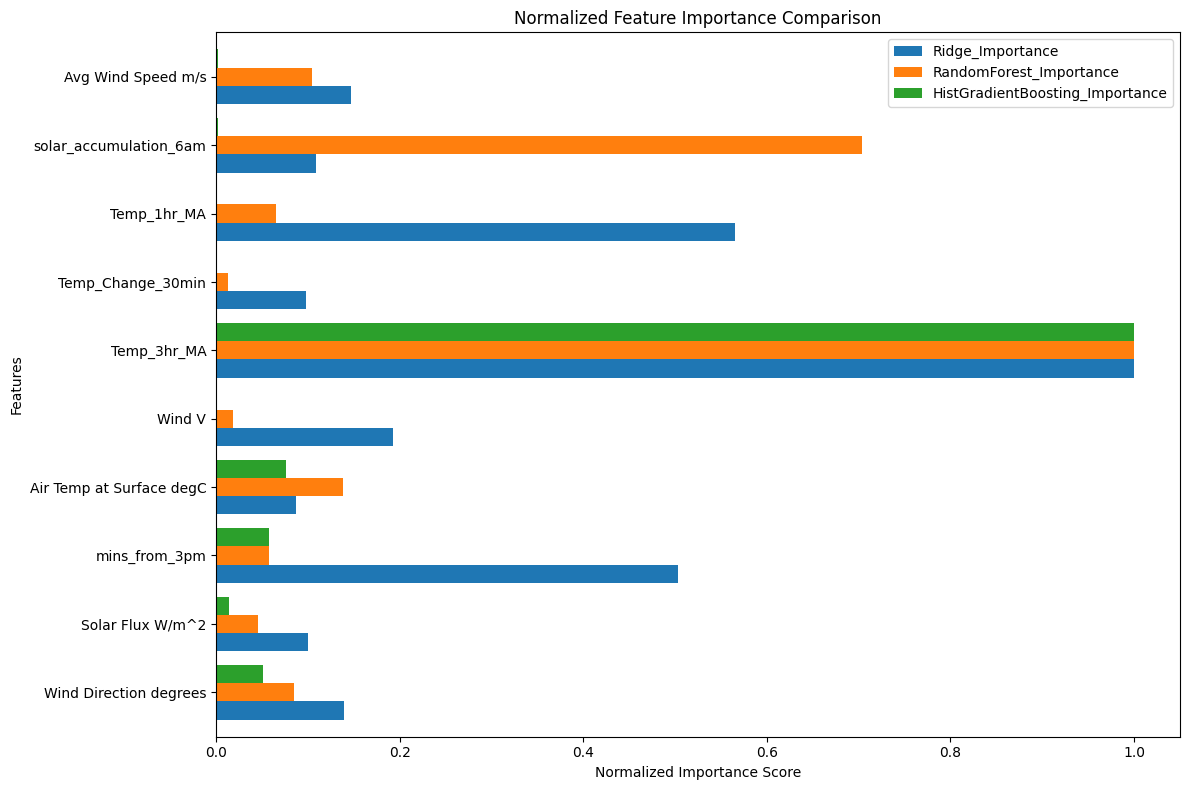


Top 5 Most Important Features Across All Models:
Feature
Temp_3hr_MA                1.00
solar_accumulation_6am     0.27
Temp_1hr_MA                0.21
mins_from_3pm              0.21
Air Temp at Surface degC   0.10
dtype: float64

Final Training R2 Scores:
Ridge: 0.1573
  Ridge coefficients:
  Temp_3hr_MA: -0.0116
  Temp_1hr_MA: -0.0066
  mins_from_3pm: 0.0059
  Wind V: 0.0022
  Avg Wind Speed m/s: -0.0017
RandomForest: 0.1936
HistGradientBoosting: 0.1939


In [33]:
# FEATURE ANALYSIS & FINAL MODELING
def plot_importance_comparison(models_dict, features):
    """Compare feature importance across all models"""
    
    importance_df = pd.DataFrame({'Feature': features})
    
    for name, model in models_dict.items():
        # The models are already fitted in the final_models dictionary,
        # so we don't need to fit them again here.
        
        if hasattr(model, 'feature_importances_'):  # For tree-based models
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):  # For linear models
            importance = np.abs(model.coef_)
        else:  # For HistGradientBoosting and similar
            # Calculate permutation importance
            result = permutation_importance(
                model, 
                X_full[features], 
                y,
                n_repeats=10,
                random_state=42
            )
            importance = result.importances_mean
            
        importance_df[f'{name}_Importance'] = importance / importance.max()  # Normalized
    
    # Plotting
    importance_df = importance_df.set_index('Feature')
    importance_df.plot(kind='barh', figsize=(12, 8), width=0.8)
    plt.title('Normalized Feature Importance Comparison')
    plt.xlabel('Normalized Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Fit final models with all data (updated models with the fix)
final_models = {
    'Ridge': Ridge(alpha=1.0).fit(X_scaled[optimal_features], y),  # Scaled data for Ridge
    'RandomForest': RandomForestRegressor(
        max_depth=5,  # Constrained to prevent overfitting
        random_state=42  # This ensures reproducibility for RandomForest
    ).fit(X_full[optimal_features], y),  # Unscaled data
    'HistGradientBoosting': HistGradientBoostingRegressor(
        max_iter=100,
        max_depth=3,  # Constrained
        random_state=42  # ensures reproducibility for HistGradientBoosting
    ).fit(X_full[optimal_features], y)  # Unscaled data
}

# Importance analysis
importance_df = plot_importance_comparison(final_models, optimal_features)
print("\nTop 5 Most Important Features Across All Models:")
print(importance_df.mean(axis=1).sort_values(ascending=False).head(5))

# Final model evaluation
print("\nFinal Training R2 Scores:")
for name, model in final_models.items():
    X_data = X_scaled[optimal_features] if name == 'Ridge' else X_full[optimal_features]
    y_pred = model.predict(X_data)
    r2 = r2_score(y, y_pred)
    print(f"{name}: {r2:.4f}")
    
    # Additional diagnostic for Ridge model
    if name == 'Ridge':
        print("  Ridge coefficients:")
        for feat, coef in sorted(zip(optimal_features, model.coef_), 
                                 key=lambda x: abs(x[1]), reverse=True)[:5]:
            print(f"  {feat}: {coef:.4f}")

In [34]:
def add_and_position_columns(main_df, source_df, columns_to_add, position='front'):
    """
    Safely adds columns from source_df to main_df and positions them as specified
    
    Args:
        main_df (pd.DataFrame): DataFrame to add columns to
        source_df (pd.DataFrame): DataFrame containing columns to add
        columns_to_add (list): Columns to transfer
        position (str): Where to position new columns ('front' or 'end')
    
    Returns:
        pd.DataFrame: DataFrame with added and positioned columns
    """
    # Validate inputs
    if not all(col in source_df.columns for col in columns_to_add):
        raise ValueError("Some columns not found in source DataFrame")
    
    if len(main_df) != len(source_df):
        raise ValueError("DataFrames must have same length")
    
    # Create a copy to avoid SettingWithCopyWarning
    result_df = main_df.copy()
    
    # Add original index for safe merging
    result_df['_temp_index'] = source_df.index
    
    # Merge with source columns
    result_df = result_df.merge(
        source_df[columns_to_add],
        left_on='_temp_index',
        right_index=True,
        how='left'
    ).drop('_temp_index', axis=1)
    
    # Verify merge succeeded
    verify_merge(result_df, source_df, columns_to_add)
    
    # Reorder columns
    return position_columns(result_df, columns_to_add, position)

def verify_merge(result_df, source_df, columns_to_add):
    """Verify that the merge was successful"""
    # Check for null values
    missing_data = result_df[columns_to_add].isnull().sum()
    print("\nMerge Verification:")
    for col in columns_to_add:
        print(f"Missing {col} values: {missing_data[col]}")
        if missing_data[col] > 0:
            raise ValueError(f"{missing_data[col]} missing values found in {col}")
    
    # Spot check random rows
    sample_indices = random.sample(range(len(result_df)), min(5, len(result_df)))
    print("\nSample Verification:")
    for idx in sample_indices:
        for col in columns_to_add:
            original_val = source_df.iloc[idx][col]
            new_val = result_df.iloc[idx][col]
            print(f"Index {idx}: {col} - Original: {original_val} | New: {new_val}")
            if original_val != new_val:
                raise ValueError(f"Mismatch found in {col} at index {idx}")

def position_columns(df, columns_to_position, position):
    """Reposition columns in DataFrame"""
    all_cols = df.columns.tolist()
    positioned_cols = [col for col in all_cols if col not in columns_to_position]
    
    if position == 'front':
        new_order = columns_to_position + positioned_cols
    elif position == 'end':
        new_order = positioned_cols + columns_to_position
    else:
        raise ValueError("Position must be 'front' or 'end'")
    
    return df[new_order]

# Usage example:
selected_features_df = add_and_position_columns(
    main_df=selected_features_df,
    source_df=final_train,
    columns_to_add=['datetime', 'Location'],
    position='front'
)


Merge Verification:
Missing datetime values: 0
Missing Location values: 0

Sample Verification:
Index 2084: datetime - Original: 2021-07-24 15:54:00 | New: 2021-07-24 15:54:00
Index 2084: Location - Original: Bronx | New: Bronx
Index 7937: datetime - Original: 2021-07-24 15:43:00 | New: 2021-07-24 15:43:00
Index 7937: Location - Original: Bronx | New: Bronx
Index 5607: datetime - Original: 2021-07-24 15:45:00 | New: 2021-07-24 15:45:00
Index 5607: Location - Original: Bronx | New: Bronx
Index 1880: datetime - Original: 2021-07-24 15:38:00 | New: 2021-07-24 15:38:00
Index 1880: Location - Original: Manhattan | New: Manhattan
Index 2587: datetime - Original: 2021-07-24 15:18:00 | New: 2021-07-24 15:18:00
Index 2587: Location - Original: Bronx | New: Bronx


In [35]:
selected_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8983 entries, 0 to 8982
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   datetime                  8983 non-null   datetime64[ns]
 1   Location                  8983 non-null   object        
 2   Wind Direction degrees    8983 non-null   float64       
 3   Solar Flux W/m^2          8983 non-null   float64       
 4   mins_from_3pm             8983 non-null   float64       
 5   Air Temp at Surface degC  8983 non-null   float64       
 6   Wind V                    8983 non-null   float64       
 7   Temp_3hr_MA               8983 non-null   float64       
 8   Temp_Change_30min         8983 non-null   float64       
 9   Temp_1hr_MA               8983 non-null   float64       
 10  solar_accumulation_6am    8983 non-null   float64       
 11  Avg Wind Speed m/s        8983 non-null   float64       
 12  UHI Index           

In [36]:
print("Number of unique entries in each column")
display(selected_features_df.nunique())  # See if any numeric columns have suspiciously few values

print("Current Train Data Shape")
display(selected_features_df.shape)

Number of unique entries in each column


datetime                     59
Location                      2
Wind Direction degrees       25
Solar Flux W/m^2             24
mins_from_3pm                13
Air Temp at Surface degC     14
Wind V                       26
Temp_3hr_MA                  26
Temp_Change_30min            21
Temp_1hr_MA                  26
solar_accumulation_6am       26
Avg Wind Speed m/s           18
UHI Index                   591
dtype: int64

Current Train Data Shape


(8983, 13)

## Applying Preprocessing to the Test Dataset

In [37]:
# Apply weather feature engineering to test data
final_test = preprocess_weather_features(test_df)
final_test1 = final_test.drop(['Longitude', 'Latitude'], axis=1).copy()

# Keep coordinates in a metadata DataFrame (exclude from training)  
test_coords = final_test[['Longitude', 'Latitude']]

# Define the final columns in the exact required order
FINAL_COLUMNS = ['datetime', 'Location', 'solar_accumulation_6am', 'Wind V',
       'Temp_Change_30min', 'Temp_3hr_MA', 'Wind Direction degrees',
       'Solar Flux W/m^2', 'Avg Wind Speed m/s', 'mins_from_3pm',
       'Temp_1hr_MA', 'Air Temp at Surface degC', 'UHI Index']

# 1. Scale the test data FIRST (before renaming columns)
# Make sure we only scale the numeric features (excluding datetime, Location, UHI Index)
numeric_cols = [col for col in final_test1.columns 
                if col not in ['datetime', 'Location', 'UHI Index'] 
                and pd.api.types.is_numeric_dtype(final_test1[col])]

# Apply the fitted scaler to these columns
final_test1[numeric_cols] = scaler.transform(final_test1[numeric_cols])

# 2. Remove special characters from column names
final_test1.columns = final_test1.columns.str.replace(r'[\[\]<>]', '', regex=True)

# 3. Select and reorder only the final 14 columns
# First verify all required columns exist
missing_cols = set(FINAL_COLUMNS) - set(final_test1.columns)
if missing_cols:
    raise ValueError(f"Missing required columns after renaming: {missing_cols}")

# Keep only the final columns in the correct order
final_test1 = final_test1[FINAL_COLUMNS]

# Verify the final output
print("Final test dataset shape:", final_test1.shape)
print("\nFirst 2 rows:")
print(final_test1.head(2))
print("\nColumn order:")
print(final_test1.columns.tolist())

Final test dataset shape: (2246, 13)

First 2 rows:
                datetime   Location  solar_accumulation_6am  Wind V  \
5961 2021-07-24 15:35:00      Bronx                    0.89    0.44   
9683 2021-07-24 15:53:00  Manhattan                   -1.19    0.70   

      Temp_Change_30min  Temp_3hr_MA  Wind Direction degrees  \
5961              -0.98        -0.95                   -0.33   
9683              -1.65         1.12                    1.14   

      Solar Flux W/m^2  Avg Wind Speed m/s  mins_from_3pm  Temp_1hr_MA  \
5961             -0.90                0.63           0.03         0.86   
9683              0.85                0.47           1.30         0.27   

      Air Temp at Surface degC  UHI Index  
5961                     -0.51       1.00  
9683                     -0.72       1.01  

Column order:
['datetime', 'Location', 'solar_accumulation_6am', 'Wind V', 'Temp_Change_30min', 'Temp_3hr_MA', 'Wind Direction degrees', 'Solar Flux W/m^2', 'Avg Wind Speed m/s', 'mins_

## Working with Building footprint

In [38]:
'''# Path to the KML file
kml_file = "/kaggle/input/ey-challenge/Building_Footprint.kml"

# Path to save the shapefile
shapefile_path = "/kaggle/working/Building_Footprint.shp"

# Run the ogr2ogr command to convert KML to shapefile
subprocess.run(['ogr2ogr', '-f', 'ESRI Shapefile', shapefile_path, kml_file])

print(f"Shapefile saved at {shapefile_path}")
'''

'# Path to the KML file\nkml_file = "/kaggle/input/ey-challenge/Building_Footprint.kml"\n\n# Path to save the shapefile\nshapefile_path = "/kaggle/working/Building_Footprint.shp"\n\n# Run the ogr2ogr command to convert KML to shapefile\nsubprocess.run([\'ogr2ogr\', \'-f\', \'ESRI Shapefile\', shapefile_path, kml_file])\n\nprint(f"Shapefile saved at {shapefile_path}")\n'

In [39]:
shapefile_path = "/kaggle/input/ey-challenge/Building_Footprint/Building_Footprint.shp"

# Read the shapefile into a GeoDataFrame
building_gdf = gpd.read_file(shapefile_path)

# View the first few rows of the GeoDataFrame
display(building_gdf.head(3))
display(building_gdf.info())

print("\n Building Data Shape:")
display(building_gdf.shape)

# Get CRS for the gdf shapefile
print("CRS: {}".format(building_gdf.crs))

Name descriptio timestamp begin   end altitudeMo  tessellate  extrude  \
0  None       None      None  None  None       None          -1        0   
1  None       None      None  None  None       None          -1        0   
2  None       None      None  None  None       None          -1        0   

   visibility drawOrder  icon             id   fid       layer  \
0          -1      None  None  cugir009034.3  7624  clip_Bronx   
1          -1      None  None  cugir009034.4  7625  clip_Bronx   
2          -1      None  None  cugir009034.5  7626  clip_Bronx   

                                                       path  \
0  /Users/killo/Desktop/Clip_Bronx.kml|layername=Clip_Bronx   
1  /Users/killo/Desktop/Clip_Bronx.kml|layername=Clip_Bronx   
2  /Users/killo/Desktop/Clip_Bronx.kml|layername=Clip_Bronx   

                                                                                                                                                 geometry  
0  POLYGON ((-73.91903 40.84820, -73.91933 40.84795, -73.91937 40.84798, -73.91945 40.84792, -73.91953 40.84797, -73.91915 40.84828, -73.91903 40.84820))  
1                                          POLYGON ((-73.92195 40.84963, -73.92191 40.84968, -73.92176 40.84961, -73.92181 40.84956, -73.92195 40.84963))  
2                                          POLYGON ((-73.92050 40.85011, -73.92045 40.85017, -73.92026 40.85007, -73.92031 40.85001, -73.92050 40.85011))

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9436 entries, 0 to 9435
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Name        0 non-null      object  
 1   descriptio  0 non-null      object  
 2   timestamp   0 non-null      object  
 3   begin       0 non-null      object  
 4   end         0 non-null      object  
 5   altitudeMo  0 non-null      object  
 6   tessellate  9436 non-null   int64   
 7   extrude     9436 non-null   int64   
 8   visibility  9436 non-null   int64   
 9   drawOrder   0 non-null      object  
 10  icon        0 non-null      object  
 11  id          9436 non-null   object  
 12  fid         9436 non-null   int64   
 13  layer       9436 non-null   object  
 14  path        9436 non-null   object  
 15  geometry    9436 non-null   geometry
dtypes: geometry(1), int64(4), object(11)
memory usage: 1.2+ MB


None


 Building Data Shape:


(9436, 16)

CRS: EPSG:4326


## Mapping Urban Heat Over Building Footprints in NYC

As part of the ongoing exploration of Urban Heat Islands (UHI), I wanted to take a closer look at how heat patterns interact with the built environment—specifically across parts of New York City. The goal here is to visually connect heat intensity with where buildings are actually located on the ground.

### UHI Values Plotted Over Building Footprints (Bronx & Manhattan)

This map gives a spatial snapshot of how UHI values align with NYC’s urban layout. Here’s how to interpret what we’re seeing:

* **Base Map**: The underlying street map helps us locate ourselves within Manhattan and the Bronx. Streets, parks, and water bodies are visible to give context.

* **Building Footprints**: Represented in green, these show the outlines of physical structures. They highlight where buildings are clustered and help us compare urban density across neighborhoods.

* **UHI Points (Main Layer of Interest)**: The colored dots overlaid on the map reflect different levels of UHI intensity:

  * **Red & Orange** → Higher heat intensity (our "hot spots").
  * **Blue tones** → Lower heat intensity, often cooler zones with less dense construction or more vegetation.

* **Labeled Boroughs**: Manhattan and the Bronx are clearly marked to help orient the viewer and allow us to compare trends between them.

### What Are We Seeing? (And Why It Matters)

Looking at the visual, a few things stand out:

* **The Bronx has noticeably more high-UHI points** than Manhattan. This lines up with existing research that’s flagged the Bronx—especially the South Bronx—as particularly heat-vulnerable. Factors like dense low-income housing, fewer trees, and limited access to cooling resources likely play a role.

* **Central Park’s cooling effect is clear**. That large patch of blue in the center of Manhattan isn’t random—it matches up with Central Park. Parks and green spaces tend to reduce heat by replacing concrete with vegetation, which cools the air through evapotranspiration. This is a textbook example of nature offsetting the heat from the surrounding built-up areas.


This visualisation strengthens the link between what we see in the data and what’s happening on the ground. It also sharpens our focus as we move toward modeling UHI more precisely—not just as a surface temperature issue, but as a spatial and environmental justice one. 

**For further context:**

* [Climate Justice in NYC – Mayor’s Office](https://climate.cityofnewyork.us/ht/ejnyc-report/the-state-of-environmental-justice-in-nyc/exposure-to-climate-change/)
* [Heat Mapping Study Finds Higher Temps in Lower-Income Neighborhoods – Columbia Climate School](https://justicenetwork.climate.columbia.edu/news/nyc-heat-mapping-study-finds-higher-temps-lower-income-neighborhoods)
* [NYC’s Heat Island Effect – FOX 5 New York](https://www.fox5ny.com/news/nyc-experiencing-heat-island-effect-amid-soaring-temperatures)
* [Fixing NYC’s Heat Wave Inequity – NYU Stern EDG](https://www.nyusternedg.org/editorial/nyc-heat-waves-are-inequitable-heres-how-to-fix-them)


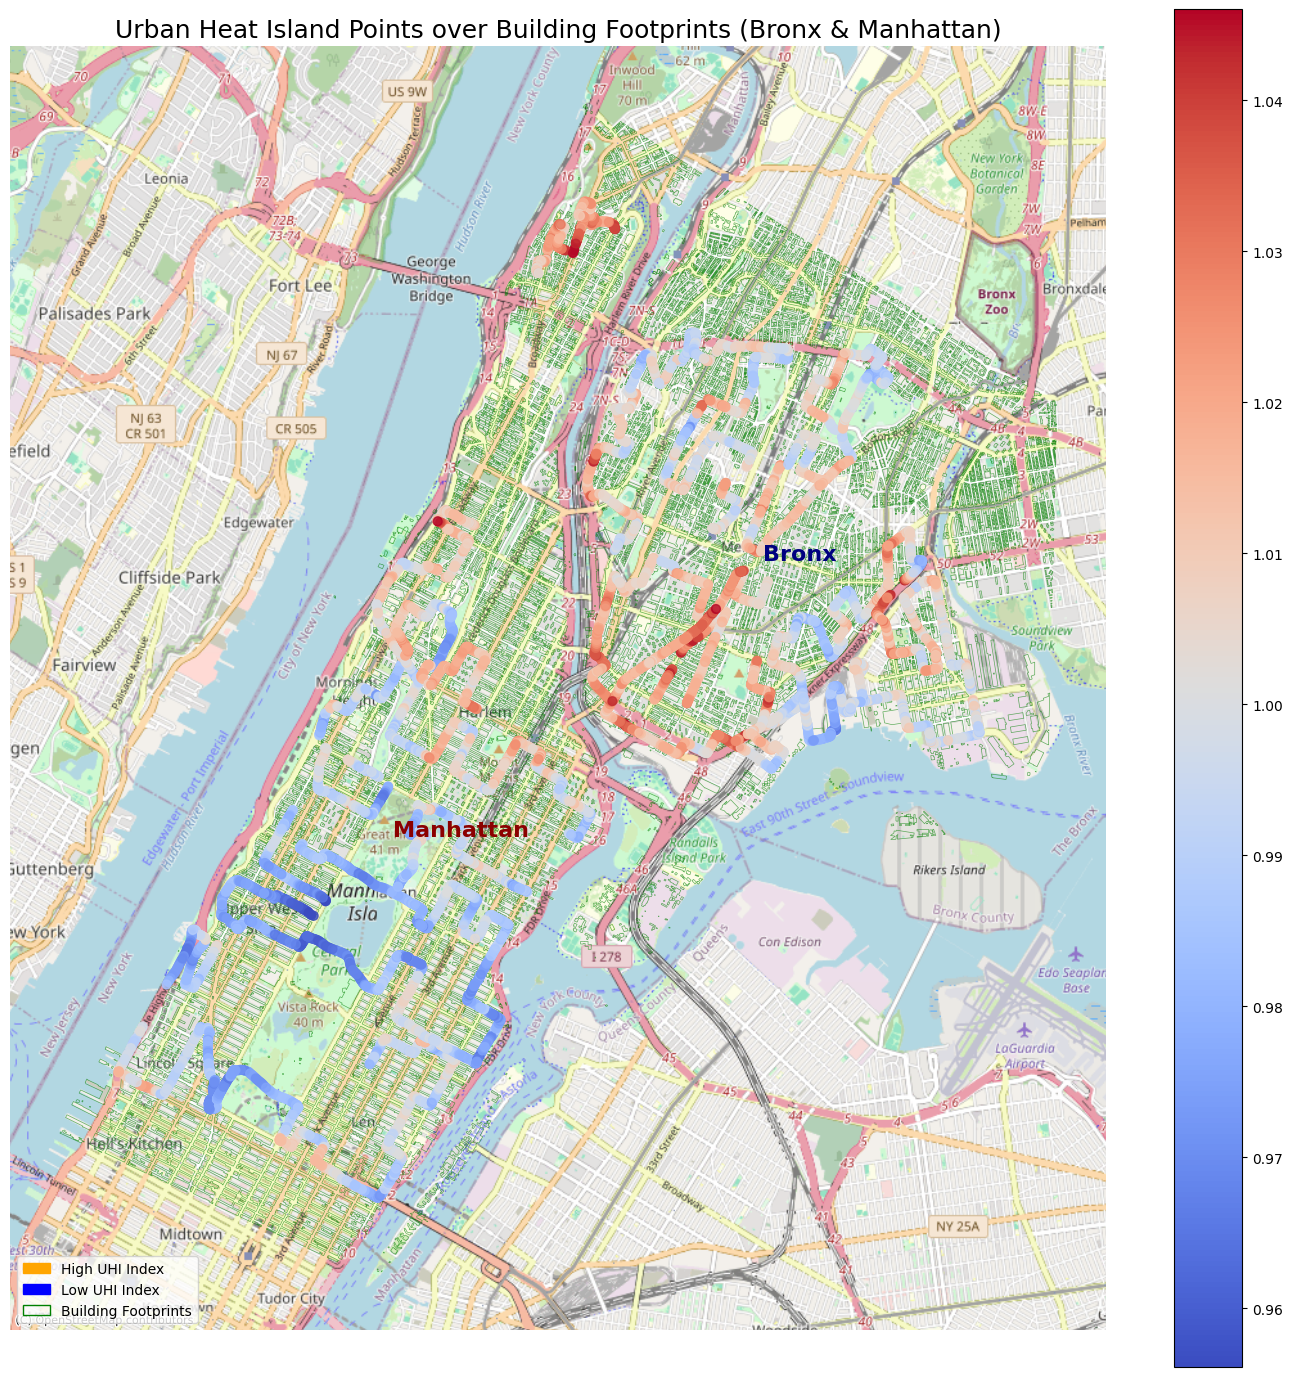

In [40]:
# Convert final_df to GeoDataFrame
uhi_gdf = gpd.GeoDataFrame(
    final_df.copy(),
    geometry=gpd.points_from_xy(final_df['Longitude'], final_df['Latitude']),
    crs='EPSG:4326'
)

# Reproject for plotting
uhi_gdf = uhi_gdf.to_crs(epsg=3857)
building_gdf = building_gdf.to_crs(epsg=3857)

# Separate UHI by location
bronx = uhi_gdf[uhi_gdf["Location"] == "Bronx"]
manhattan = uhi_gdf[uhi_gdf["Location"] == "Manhattan"]

# Plot everything
fig, ax = plt.subplots(figsize=(14, 14))

# Plot building footprints: green edges
building_gdf.plot(ax=ax, facecolor="none", edgecolor="green", linewidth=0.5, alpha=0.6)

# Plot UHI points: color shows intensity
uhi_plot = uhi_gdf.plot(
    ax=ax,
    column="UHI Index",
    cmap="coolwarm",
    markersize=40,
    legend=True,
    alpha=0.8
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.9)

# Label Bronx and Manhattan
bronx_centroid = bronx.unary_union.centroid
manhattan_centroid = manhattan.unary_union.centroid

ax.text(bronx_centroid.x, bronx_centroid.y, "Bronx", fontsize=16, fontweight='bold', color='navy')
ax.text(manhattan_centroid.x, manhattan_centroid.y, "Manhattan", fontsize=16, fontweight='bold', color='darkred')

# Add Custom Legend
uhi_patch = mpatches.Patch(color="orange", label="High UHI Index")
cool_patch = mpatches.Patch(color="blue", label="Low UHI Index")
building_patch = mpatches.Patch(edgecolor="green", facecolor="none", label="Building Footprints")

plt.legend(handles=[uhi_patch, cool_patch, building_patch], loc="lower left", fontsize=10)

# Final formatting
ax.set_title("Urban Heat Island Points over Building Footprints (Bronx & Manhattan)", fontsize=18)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Reproject back to EPSG:4326
uhi_gdf = uhi_gdf.to_crs(epsg=4326)
building_gdf = building_gdf.to_crs(epsg=4326)

In [41]:
# Select relevant columns
building_df = building_gdf[['id', 'fid', 'layer','geometry']].copy()

# Display the first few rows
print(building_df.head())

                id   fid       layer  \
0    cugir009034.3  7624  clip_Bronx   
1    cugir009034.4  7625  clip_Bronx   
2    cugir009034.5  7626  clip_Bronx   
3    cugir009034.6  7627  clip_Bronx   
4  cugir009034.142  7829  clip_Bronx   

                                                                                                                                                 geometry  
0  POLYGON ((-73.91903 40.84820, -73.91933 40.84795, -73.91937 40.84798, -73.91945 40.84792, -73.91953 40.84797, -73.91915 40.84828, -73.91903 40.84820))  
1                                          POLYGON ((-73.92195 40.84963, -73.92191 40.84968, -73.92176 40.84961, -73.92181 40.84956, -73.92195 40.84963))  
2                                          POLYGON ((-73.92050 40.85011, -73.92045 40.85017, -73.92026 40.85007, -73.92031 40.85001, -73.92050 40.85011))  
3                                          POLYGON ((-73.92056 40.85140, -73.92053 40.85144, -73.92037 40.85138, -73.92040 40.85134, -7

In [42]:
# Clean the 'layer' column to extract borough names (e.g., "clip_Bronx" → "Bronx")
building_df["Location"] = building_df["layer"].str.replace("clip_", "")

# Drop unused columns (optional)
building_df = building_df[["id", "Location", "geometry"]]

In [43]:
print("CRS: {}".format(building_gdf.crs))

CRS: EPSG:4326


In [44]:
building_df["Location"].value_counts()

Location
Bronx        5926
Manhattan    3510
Name: count, dtype: int64

## Basic EDA – Understanding the Urban Landscape of Bronx and Manhattan

Before modeling Urban Heat Island (UHI) effects, I ran a foundational analysis to understand the layout and density of buildings in the Bronx and Manhattan — since the built environment plays a direct role in how heat is stored and dispersed.

### Building Count and Area

* **Bronx:** 5,926 buildings covering \~76.7 million sq ft
* **Manhattan:** 3,510 buildings covering \~126.3 million sq ft

Though the Bronx has more buildings, Manhattan’s structures are significantly larger on average — about **36,000 sq ft** compared to **13,000 sq ft** in the Bronx. This aligns with the expected difference in urban form: the Bronx has more low-rise residential structures, while Manhattan is shaped by larger commercial and high-rise buildings.

### What This Means for UHI

* The **Bronx’s heat** may stem from the **dense clustering** of smaller buildings, which limits airflow and increases surface heat retention.
* In **Manhattan**, while buildings are larger, vertical structures and parks (like Central Park) contribute to **shading and ventilation**, creating localized cooling effects.

This contrast helps explain patterns seen in earlier UHI visualizations and sets a foundation for why borough-level structural differences matter in heat modeling.


Building Count per Borough
Location
Bronx        5926
Manhattan    3510
Name: count, dtype: int64

Total Building Area (sq ft)
Location
Bronx        76723904.80
Manhattan   126304860.02
Name: area, dtype: float64

Borough Statistics


Location  num_buildings   total_area  avg_area
0      Bronx           5926  76723904.80  12947.00
1  Manhattan           3510 126304860.02  35984.29

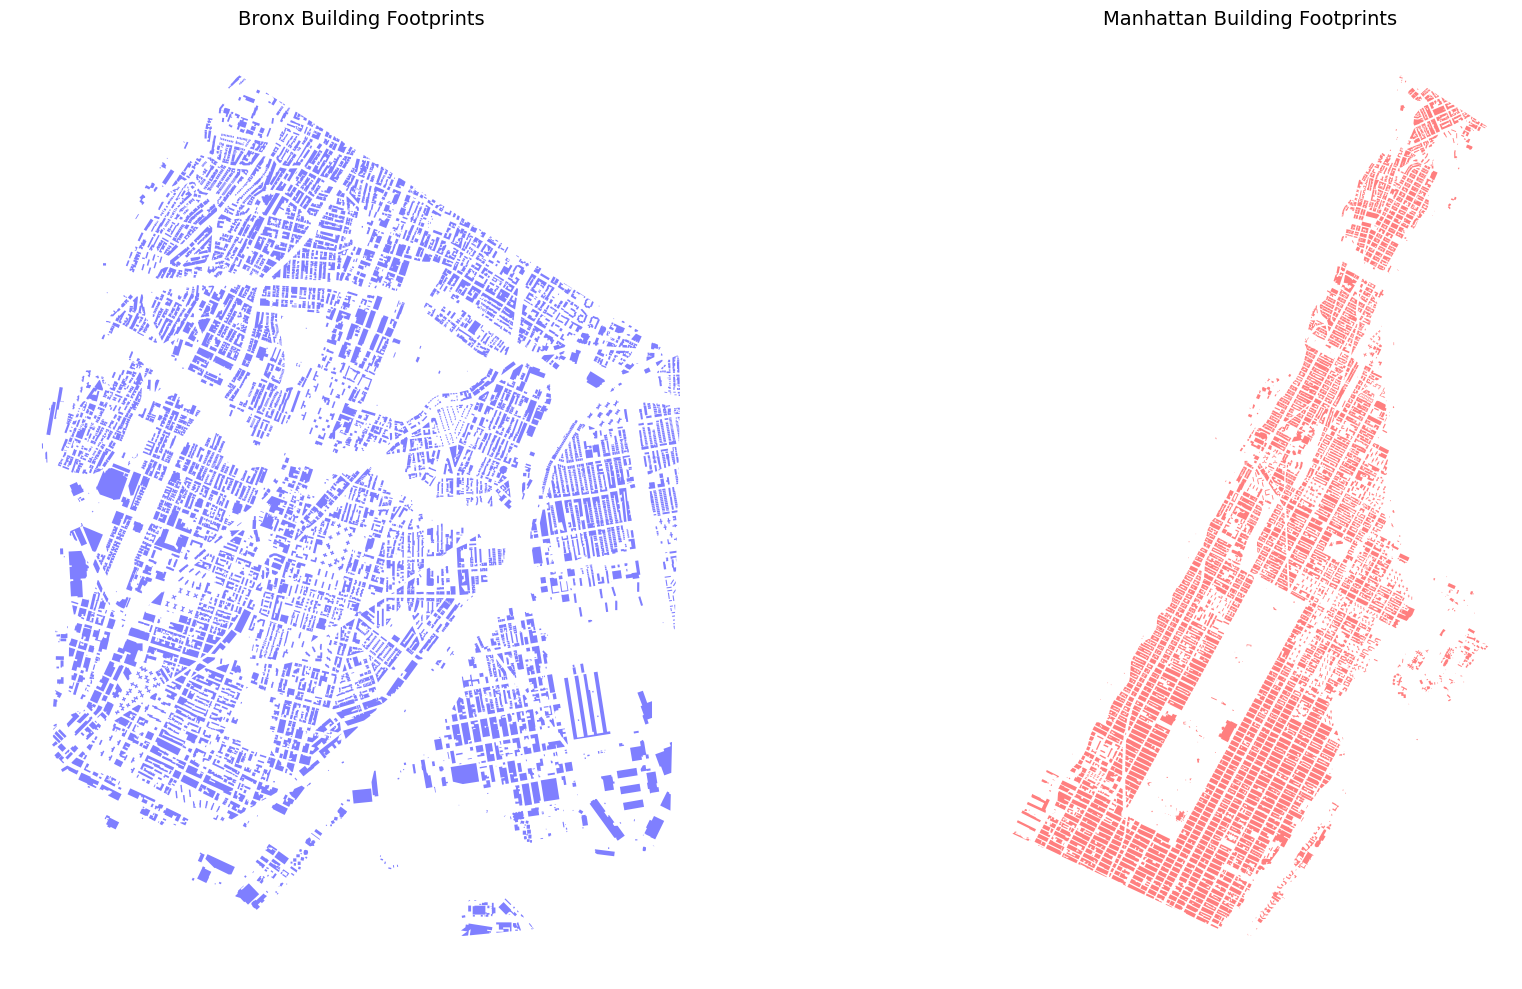

In [45]:
# Preprocess Data 
# Convert to projected CRS (EPSG:2263 for feet)
building_df = building_df.to_crs(epsg=2263)

# Calculate areas
building_df["area"] = building_df.geometry.area  # Area in square feet

# Borough Statistics 
borough_stats = building_df.groupby("Location").agg(
    num_buildings=("id", "count"),
    total_area=("area", "sum"),
    avg_area=("area", "mean")
).reset_index()

# Format numbers to avoid scientific notation
borough_stats["total_area"] = borough_stats["total_area"].round(2)
borough_stats["avg_area"] = borough_stats["avg_area"].round(2)

# Print Summary Stats 
print("\nBuilding Count per Borough")
print(building_df["Location"].value_counts())

print("\nTotal Building Area (sq ft)")
print(building_df.groupby("Location")["area"].sum().round(2))

print("\nBorough Statistics")
display(borough_stats)

# Side-by-Side Plots 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Bronx Plot
bronx = building_df[building_df["Location"] == "Bronx"]
bronx.plot(ax=ax1, alpha=0.5, color='blue')
ax1.set_title("Bronx Building Footprints", fontsize=14)
ax1.set_axis_off()

# Manhattan Plot
manhattan = building_df[building_df["Location"] == "Manhattan"]
manhattan.plot(ax=ax2, alpha=0.5, color='red')
ax2.set_title("Manhattan Building Footprints", fontsize=14)
ax2.set_axis_off()

plt.tight_layout()
plt.show()

## Deeper Dive – Advanced EDA of the Built Environment and Urban Heat Dynamics

To complement basic building stats, this analysis explores how geometry, density, and spatial design shape UHI behavior in Bronx and Manhattan. Instead of just surface area, we now look at how **form and spacing** influence thermal dynamics.

### Urban Form and Spatial Layout

| Metric                  | Bronx    | Manhattan |
| ----------------------- | -------- | --------- |
| Building Count          | 5,926    | 3,510     |
| Total Area (sq ft)      | 76.7M    | 126.3M    |
| Avg Building Area       | \~13,000 | \~36,000  |
| Median NN Distance (ft) | 123.25      |  204.88       |

* The **Bronx** has a more **compact and horizontally spread** urban layout, while **Manhattan** is denser vertically, with wider gaps between buildings.
* **Shorter distances** between Bronx buildings can lead to **less airflow** and **more trapped heat**, forming a more continuous heat layer.
* **Manhattan’s spacing**, while looser, combines with complex structures that create **localized hotspots** and **thermal contrasts**.

### Building Shape and Ventilation Potential

| Metric             | Bronx | Manhattan |
| ------------------ | ----- | --------- |
| Mean Compactness   | 0.57  | 0.49      |
| % Highly Irregular | 2.45%    | 6.70%        |

* The Bronx’s more **regular shapes** support smoother airflow, while Manhattan’s irregular forms may **disrupt ventilation**, increasing microclimate variability.
* These differences are important: **irregular, complex buildings** can block wind and **retain heat longer**, especially in tightly packed areas.

### Large Structures and Thermal Imbalance

Outliers matter: nearly **800 buildings exceed 3× the 75th percentile in size**, including highly irregular structures.

* One Bronx building spans over **768,000 sq ft** with extremely low compactness — behaving as a **thermal anchor** that stores and slowly releases heat.

These buildings don’t just affect themselves — they alter conditions in surrounding blocks, intensifying UHI effects in nearby residential areas.

### Urban Inequality and Heat Exposure

* **Manhattan shows higher inequality** in building size, leading to abrupt transitions from small buildings to skyscrapers. These shifts can cause **uneven heat distribution**, creating “cool gaps” by day that become **radiant zones** at night.
* In contrast, the **Bronx’s more uniform structure** leads to a **flatter but more consistent UHI surface** — fewer extremes, but less relief.

### Summary: Contrasting Heat Behaviors

| Factor           | Bronx                          | Manhattan                              |
| ---------------- | ------------------------------ | -------------------------------------- |
| Urban Form       | Compact, low-rise              | Tall, irregular, mixed-density         |
| Heat Behavior    | Continuous surface heat        | Patchy, localized hotspots             |
| Primary Risk     | Persistent heat accumulation   | Thermal imbalance + night radiation    |
| Mitigation Focus | Broad cooling (trees, roofing) | Targeted solutions (ventilation paths) |

In [47]:
# 1. Calculate Building Compactness
# Compactness is a shape metric: 1 for a perfect circle, lower for irregular shapes.
# Formula: 4 * pi * Area / Perimeter^2
# We use 3.14159 for pi for consistency with common approximations in such calculations.
building_df['compactness'] = 4 * 3.14159 * building_df['area'] / (building_df.geometry.length**2)

# 2. Calculate Average Nearest Neighbor Distance 
# Measures building density by finding the average distance to the 5 closest building centroids.
coords = np.column_stack([building_df.geometry.centroid.x, building_df.geometry.centroid.y])
nbrs = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(coords)
distances, _ = nbrs.kneighbors(coords)
building_df['avg_neighbor_dist_ft'] = distances.mean(axis=1)

# --- Insights and Feature Aggregation ---
print("Advanced EDA: Built Environment and Urban Heat Dynamics\n")

# Calculate metrics for "Urban Form and Spatial Layout" and "Building Shape and Ventilation Potential" tables.
# This combines calculations needed for multiple rows and sections of your write-up.
borough_features = building_df.groupby('Location').agg(
    # Building Count (for table)
    building_count=('Location', 'size'),
    # Total Area (sq ft) (for table)
    total_area_sqft=('area', 'sum'),
    # Average Building Area (for table)
    avg_building_area=('area', 'mean'),
    # Median Nearest Neighbor Distance (for table)
    median_nn_distance_ft=('avg_neighbor_dist_ft', 'median'),
    # Mean Compactness (for table)
    mean_compactness=('compactness', 'mean'),
    # Percentage of Highly Irregular Buildings (for table)
    # Defined as compactness < 0.2, as per your Block 3 original logic.
    pct_highly_irregular=('compactness', lambda x: (x < 0.2).mean() * 100) # Express as percentage
)

print("Urban Form and Spatial Layout & Building Shape and Ventilation Potential Metrics")
# Format for readability, matching your table's approximate values.
# Note: 'total_area_sqft' will be large, might need manual formatting for 'M' in markdown table.
print(borough_features.round(2).to_string())
print("\n" + "="*80 + "\n") # Separator for clarity


# Analyze Outliers: Large Structures and Thermal Imbalance
q75_area = building_df['area'].quantile(0.75)
# Filter buildings exceeding 3x the 75th percentile area.
outliers_large = building_df[building_df['area'] > q75_area * 3]
print(f"Large Structures and Thermal Imbalance Outliers")
print(f"Nearly {len(outliers_large):,} buildings exceed 3x the 75th percentile in size ({q75_area * 3:,.0f} sq ft).\n")

# Find the largest Bronx building with low compactness
# Assuming "extremely low compactness" implies looking for a compactness value below a certain threshold, e.g., 0.2
bronx_thermal_anchor = outliers_large[
    (outliers_large['Location'] == 'Bronx') &
    (outliers_large['compactness'] < 0.2) # Use the "highly irregular" threshold for "extremely low"
].sort_values('area', ascending=False).head(1)

if not bronx_thermal_anchor.empty:
    print(f"Specific thermal anchor example (Bronx, largest irregular outlier):")
    print(f"- Area: {bronx_thermal_anchor['area'].iloc[0]:,.0f} sq ft")
    print(f"- Compactness: {bronx_thermal_anchor['compactness'].iloc[0]:.3f}\n")
else:
    print("Could not find a specific large Bronx building with extremely low compactness among outliers based on criteria.\n")

print("Largest buildings among these outliers (top 5 by area):")
print(outliers_large[['Location', 'area', 'compactness']].sort_values('area', ascending=False).head(5).to_string())

Advanced EDA: Built Environment and Urban Heat Dynamics

Urban Form and Spatial Layout & Building Shape and Ventilation Potential Metrics
           building_count  total_area_sqft  avg_building_area  median_nn_distance_ft  mean_compactness  pct_highly_irregular
Location                                                                                                                    
Bronx                5926      76723904.80           12947.00                 123.25              0.57                  2.45
Manhattan            3510     126304860.02           35984.29                 204.88              0.49                  6.70


Large Structures and Thermal Imbalance Outliers
Nearly 793 buildings exceed 3x the 75th percentile in size (70,381 sq ft).

Specific thermal anchor example (Bronx, largest irregular outlier):
- Area: 768,459 sq ft
- Compactness: 0.039

Largest buildings among these outliers (top 5 by area):
       Location      area  compactness
5777      Bronx 768459.44    

In [49]:
print("\nBuilding Data Shape:")
print(building_df.shape)

print("\nBuilding Data CRS:")
print("CRS: {}".format(building_df.crs))

print("\nBuilding Data Unique Entries:")
print(building_df.nunique())


Building Data Shape:
(9436, 6)

Building Data CRS:
CRS: EPSG:2263

Building Data Unique Entries:
id                      9436
Location                   2
geometry                9433
area                    9433
compactness             9433
avg_neighbor_dist_ft    9433
dtype: int64


In [ ]:
'''# Reproject back to EPSG:4326
building_df = building_df.to_crs(epsg=4326)'''

## Engineering Spatial Features from Building Footprints

To better predict Urban Heat Island (UHI) intensity, I transformed the NYC building footprint dataset into spatial features that reflect the urban form around each UHI point. Since there wasn’t a one-to-one mapping between UHI coordinates and individual buildings, I adopted a spatial summarization approach.

### Why This Was Needed
* **Mismatch in data sizes**:
  The building dataset (9,436 entries) didn’t match the combined train/test UHI entries (11,229).
* **No direct join**:
  UHI points only had latitude and longitude, and I couldn't use these directly as features.
* **Goal**:
  Capture *contextual building characteristics* around each UHI point without violating the constraints.

### The Strategy
1. **Buffer Zones**:
   Around each UHI coordinate, I created circular zones with radii of:

   * 50m
   * 100m
   * 150m
   * 200m

2. **Within Each Buffer**, I computed:
   * Count of buildings
   * Summary stats (mean, median, std, sum) for:

     * `area`
     * `compactness`
     * `avg_neighbor_dist_ft`
   * **Built-up ratio**:
     Total building area ÷ buffer area (a proxy for urban density)

3. **Why Buffers Work**:
   * UHI is influenced by the *surrounding built form*, not individual structures.
   * Buffers allow us to approximate urban context without using GPS directly.

### Result
* These aggregated spatial features enriched the dataset with localized urban morphology.
* The model now has access to *urban density, compactness, and spacing patterns* across multiple scales—improving its ability to learn how the environment influences heat distribution.

In [50]:
# Reset the index of train_coords to match the order of selected_features_df
train_coords = train_coords.reset_index(drop=True)

# Now check
assert selected_features_df.index.equals(train_coords.index)

# Now check
assert final_test1.index.equals(test_coords.index)

In [51]:
train_coords.head()

Longitude  Latitude
0     -73.96     40.80
1     -73.97     40.79
2     -73.88     40.81
3     -73.93     40.86
4     -73.96     40.80

In [52]:
def create_spatial_features(uhi_coords_df, buildings_gdf, buffer_sizes=[50, 100, 150, 200]):
    """
    Engineered spatial features from building footprints within buffers around UHI points.
    
    Args:
        uhi_coords_df: DataFrame with 'latitude' and 'longitude' columns
        buildings_gdf: GeoDataFrame of building footprints with metrics
        buffer_sizes: List of buffer radii in meters
        
    Returns:
        DataFrame with engineered features (no geometry/coordinates)
    """
    # Convert to GeoDataFrame in Web Mercator (meters)
    gdf = gpd.GeoDataFrame(
        uhi_coords_df,
        geometry=gpd.points_from_xy(uhi_coords_df.Longitude, uhi_coords_df.Latitude),
        crs="EPSG:4326"
    ).to_crs("EPSG:3857")  # Convert to meter-based CRS
    
    # Buffer buildings to avoid repeated spatial joins
    buildings_buffered = buildings_gdf.to_crs("EPSG:3857").copy()
    
    results = []
    for radius in buffer_sizes:
        # Create buffers
        buffered = gdf.copy()
        buffered['geometry'] = buffered.geometry.buffer(radius)
        buffered['buffer_area'] = np.pi * (radius ** 2)  # Area of circular buffer
        
        # Spatial join with buildings
        joined = gpd.sjoin(buffered, buildings_buffered, how='left', predicate='intersects')
        
        # Aggregate features
        agg_features = joined.groupby(level=0).agg({
            'area': ['count', 'mean', 'median', 'std', 'sum'],
            'compactness': ['mean', 'median', 'std'],
            'avg_neighbor_dist_ft': ['mean', 'median', 'std'],
        })
        
        # Flatten multi-index columns
        agg_features.columns = [f"{radius}m_{stat}_{var}" 
                              for var, stat in agg_features.columns]
        
        # Align buffer areas with aggregated features
        buffer_areas = buffered['buffer_area'].loc[agg_features.index]
        agg_features[f"{radius}m_builtup_ratio"] = (
            agg_features[f"{radius}m_sum_area"] / buffer_areas
        )
        
        results.append(agg_features)
    
    # Combine all buffer sizes
    return pd.concat(results, axis=1).fillna(0)

# Example usage:
if __name__ == "__main__":
    # 1. Generate spatial features
    train_spatial = create_spatial_features(train_coords, building_df)
    test_spatial = create_spatial_features(test_coords, building_df)
    
    # 2. Merge with existing data (excluding coordinates)
    train_enhanced = pd.concat([selected_features_df, train_spatial], axis=1)
    test_enhanced = pd.concat([final_test1, test_spatial], axis=1)

    # Move 'UHI Index' to last column (for both train and test)
    for i, df in enumerate([train_enhanced, test_enhanced]):
        if "UHI Index" in df.columns:
            # Store UHI values
            uhi_values = df["UHI Index"].copy()
            # Drop the column
            df.drop(columns=["UHI Index"], inplace=True)
            # Re-add as last column
            df["UHI Index"] = uhi_values        

# Verify
print("Last 5 train columns:", train_enhanced.columns.tolist()[-5:])
print("Last 5 test columns:", test_enhanced.columns.tolist()[-5:])

Last 5 train columns: ['200m_mean_avg_neighbor_dist_ft', '200m_median_avg_neighbor_dist_ft', '200m_std_avg_neighbor_dist_ft', '200m_builtup_ratio', 'UHI Index']
Last 5 test columns: ['200m_mean_avg_neighbor_dist_ft', '200m_median_avg_neighbor_dist_ft', '200m_std_avg_neighbor_dist_ft', '200m_builtup_ratio', 'UHI Index']


In [53]:
def check_missingness(df, label="Dataset"):
    missing_percent = (df.isnull().sum() / len(df)) * 100
    print(f"\nMissing values (%): {label}")
    return missing_percent[missing_percent > 0].sort_values(ascending=False)

check_missingness(train_enhanced, "Enhanced Train") 
check_missingness(test_enhanced, "Enhanced Test")


Missing values (%): Enhanced Train

Missing values (%): Enhanced Test


Series([], dtype: float64)

In [54]:
# Quick look at first rows
print("Train Dataset")
display(train_enhanced.head(3))  # Reduced to 3 rows for brevity

print("Test Dataset")
display(test_enhanced.head(3))  # Reduced to 3 rows for brevity

# Shape (row x column count)
print("Train Dataset Shape:", train_enhanced.shape)
print("Test Dataset Shape:", test_enhanced.shape)

def show_uniqueness_extremes(df, name="Dataset"):
    nunique = df.nunique()
    print(f"\n{name} - Top 5 columns with highest uniqueness:")
    display(nunique.sort_values(ascending=False).head(5))
    print(f"\n{name} - Top 5 columns with lowest uniqueness:")
    display(nunique.sort_values().head(5))

show_uniqueness_extremes(train_enhanced, "Train Enhanced")
show_uniqueness_extremes(test_enhanced, "Test Enhanced")

Train Dataset


datetime   Location  Wind Direction degrees  Solar Flux W/m^2  \
0 2021-07-24 15:51:00  Manhattan                    0.76             -1.52   
1 2021-07-24 15:13:00  Manhattan                   -0.18              0.73   
2 2021-07-24 15:47:00      Bronx                   -0.43              1.08   

   mins_from_3pm  Air Temp at Surface degC  Wind V  Temp_3hr_MA  \
0           0.98                     -1.14    0.91         1.08   
1          -1.24                     -1.14    0.24         0.72   
2           0.66                      0.33    0.35        -0.82   

   Temp_Change_30min  Temp_1hr_MA  solar_accumulation_6am  Avg Wind Speed m/s  \
0              -1.25         0.07                   -0.73                0.63   
1              -1.12        -1.60                   -1.00                0.02   
2              -0.05         1.29                    0.26                0.63   

   50m_count_area  50m_mean_area  50m_median_area  50m_std_area  50m_sum_area  \
0               1       12285.39         12285.39          0.00      12285.39   
1               3       48446.85         65203.53      29654.90     145340.56   
2               5       27520.30         24582.44      15850.36     137601.49   

   50m_mean_compactness  50m_median_compactness  50m_std_compactness  \
0                  0.50                    0.50                 0.00   
1                  0.41                    0.32                 0.23   
2                  0.37                    0.35                 0.16   

   50m_mean_avg_neighbor_dist_ft  50m_median_avg_neighbor_dist_ft  \
0                         903.83                           903.83   
1                         223.85                           229.32   
2                         187.38                           168.90   

   50m_std_avg_neighbor_dist_ft  50m_builtup_ratio  100m_count_area  \
0                          0.00               1.56                1   
1                         20.04              18.51                7   
2                         39.40              17.52                6   

   100m_mean_area  100m_median_area  100m_std_area  100m_sum_area  \
0        12285.39          12285.39           0.00       12285.39   
1        49294.49          25455.67       41512.34      345061.45   
2        23127.95          23220.07       17797.28      138767.73   

   100m_mean_compactness  100m_median_compactness  100m_std_compactness  \
0                   0.50                     0.50                  0.00   
1                   0.41                     0.39                  0.19   
2                   0.41                     0.43                  0.17   

   100m_mean_avg_neighbor_dist_ft  100m_median_avg_neighbor_dist_ft  \
0                          903.83                            903.83   
1                          227.46                            229.32   
2                          181.13                            164.40   

   100m_std_avg_neighbor_dist_ft  100m_builtup_ratio  150m_count_area  \
0                           0.00                0.39                1   
1                          24.30               10.98                8   
2                          38.42                4.42                9   

   150m_mean_area  150m_median_area  150m_std_area  150m_sum_area  \
0        12285.39          12285.39           0.00       12285.39   
1        45203.03          23913.94       40137.42      361624.24   
2        24415.78          21857.69       23944.33      219742.02   

   150m_mean_compactness  150m_median_compactness  150m_std_compactness  \
0                   0.50                     0.50                  0.00   
1                   0.43                     0.42                  0.19   
2                   0.50                     0.53                  0.20   

   150m_mean_avg_neighbor_dist_ft  150m_median_avg_neighbor_dist_ft  \
0                          903.83                            903.83   
1                          230.46                     

Test Dataset


datetime   Location  solar_accumulation_6am  Wind V  \
5961 2021-07-24 15:35:00      Bronx                    0.89    0.44   
9683 2021-07-24 15:53:00  Manhattan                   -1.19    0.70   
2678 2021-07-24 15:18:00      Bronx                    1.35   -1.70   

      Temp_Change_30min  Temp_3hr_MA  Wind Direction degrees  \
5961              -0.98        -0.95                   -0.33   
9683              -1.65         1.12                    1.14   
2678               1.16        -1.20                   -1.71   

      Solar Flux W/m^2  Avg Wind Speed m/s  mins_from_3pm  Temp_1hr_MA  \
5961             -0.90                0.63           0.03         0.86   
9683              0.85                0.47           1.30         0.27   
2678             -1.25               -0.44          -0.92         0.02   

      Air Temp at Surface degC  50m_count_area  50m_mean_area  \
5961                     -0.51               2        2043.36   
9683                     -0.72               3       39767.45   
2678                      1.60               1       57310.57   

      50m_median_area  50m_std_area  50m_sum_area  50m_mean_compactness  \
5961          2043.36        965.46       4086.72                  0.66   
9683         24986.28      27802.93     119302.34                  0.66   
2678         57310.57          0.00      57310.57                  0.54   

      50m_median_compactness  50m_std_compactness  \
5961                    0.66                 0.12   
9683                    0.66                 0.05   
2678                    0.54                 0.00   

      50m_mean_avg_neighbor_dist_ft  50m_median_avg_neighbor_dist_ft  \
5961                          75.87                            75.87   
9683                         227.03                           221.36   
2678                         216.28                           216.28   

      50m_std_avg_neighbor_dist_ft  50m_builtup_ratio  100m_count_area  \
5961                         13.08               0.52                8   
9683                          9.94              15.19                5   
2678                          0.00               7.30                3   

      100m_mean_area  100m_median_area  100m_std_area  100m_sum_area  \
5961         9508.36           6550.55       10063.99       76066.89   
9683        48939.88          60212.80       23395.32      244699.39   
2678        22881.99          10785.22       30252.02       68645.98   

      100m_mean_compactness  100m_median_compactness  100m_std_compactness  \
5961                   0.55                     0.56                  0.19   
9683                   0.55                     0.61                  0.17   
2678                   0.54                     0.54                  0.20   

      100m_mean_avg_neighbor_dist_ft  100m_median_avg_neighbor_dist_ft  \
5961                          108.74                             97.72   
9683                          224.12                            221.36   
2678                          259.19                            255.51   

      100m_std_avg_neighbor_dist_ft  100m_builtup_ratio  150m_count_area  \
5961                          42.83                2.42               14   
9683                          10.98                7.79                7   
2678                          44.87                2.19                7   

      150m_mean_area  150m_median_area  150m_std_area  150m_sum_area  \
5961         9280.47           6569.51        8732.45      129926.63   
9683        44529.19          46441.87       21850.51      311704.36   
2678        22367.46          10785.22       26798.71      156572.21   

      150m_mean_compactness  150m_median_compactness  150m_std_compactness  \
5961                   0.56                     0.58                  0.18   
9683                   0.46                     0.49                  0.22   
2678                   0.50                     0.54                  0.19   

      150m

Train Dataset Shape: (8983, 61)
Test Dataset Shape: (2246, 61)

Train Enhanced - Top 5 columns with highest uniqueness:


200m_builtup_ratio                4689
200m_mean_avg_neighbor_dist_ft    4689
200m_mean_compactness             4689
200m_sum_area                     4689
200m_mean_area                    4689
dtype: int64


Train Enhanced - Top 5 columns with lowest uniqueness:


Location                     2
50m_count_area              10
mins_from_3pm               13
Air Temp at Surface degC    14
Avg Wind Speed m/s          18
dtype: int64


Test Enhanced - Top 5 columns with highest uniqueness:


200m_builtup_ratio                1729
200m_mean_avg_neighbor_dist_ft    1729
200m_mean_compactness             1729
200m_sum_area                     1729
200m_mean_area                    1729
dtype: int64


Test Enhanced - Top 5 columns with lowest uniqueness:


Location                     2
50m_count_area              10
mins_from_3pm               13
Air Temp at Surface degC    14
Avg Wind Speed m/s          18
dtype: int64

## Buffer Visualization: Purpose and Reasoning

This visualization illustrates how buffer radius affects the spatial context captured around UHI measurement points. The goal is to understand how different buffer sizes influence the building features aggregated for modeling Urban Heat Island intensity.

The buffers are generated around each UHI location. Within each buffer, building-level attributes—such as total footprint area, number of structures, and shape descriptors—are computed. These spatial features are then used as input to the regression model predicting UHI index.

### Why This Matters

The choice of buffer size is critical. It defines the spatial boundary within which environmental features are considered relevant. A buffer that is too small may miss surrounding context, while one that is too large may dilute local effects with unrelated data.

This visualization allows for:
* A direct comparison of spatial coverage across buffer sizes.
* Visual verification that buffers are correctly aligned with UHI locations.
* An intuitive understanding of how much building data is included at each radius.

### Technical Notes
* Buffers are created around UHI points, not buildings.
* The radius can be adjusted dynamically from 50m to 200m.
* A subset of points and buildings is sampled to ensure performance and clarity.
* Buffers are styled to visually reflect scale differences across settings.

### Use Case in Modeling
By observing how features vary with buffer size, I can empirically test which radius results in the most informative spatial features—measured by R² on validation data. This visualization directly supports that decision process and helps justify buffer choices in the final modeling pipeline.

In [55]:
def create_interactive_buffer_map(uhi_points, buildings, min_buffer=50, max_buffer=200):
    """
    Fully interactive map where buffer circles:
    - Resize dynamically with slider
    - Change color (blue -> red) based on size
    - Update in real-time
    """
    # Convert to WGS84 if not already
    # Ensure uhi_points and buildings are GeoDataFrames with a 'geometry' column
    # and have a CRS set before attempting to_crs.
    if uhi_points.crs != "EPSG:4326":
        uhi_points = uhi_points.to_crs("EPSG:4326")
    if buildings.crs != "EPSG:4326":
        buildings = buildings.to_crs("EPSG:4326")

    # Create base map
    # Ensure uhi_points is not empty before accessing iloc[0]
    if uhi_points.empty:
        print("UHI points GeoDataFrame is empty. Cannot create map center.")
        return None
    center = [uhi_points.geometry.iloc[0].y, uhi_points.geometry.iloc[0].x]
    m = folium.Map(
        location=center,
        zoom_start=15,
        tiles='CartoDB positron'
    )

    # Sample buildings for performance
    # Ensure buildings is not empty before sampling
    if not buildings.empty:
        buildings_sample = buildings.sample(min(1000, len(buildings))) if len(buildings) > 1000 else buildings
        folium.GeoJson(
            buildings_sample,
            name='Buildings',
            style_function=lambda x: {'color': 'orange', 'weight': 0.5, 'fillOpacity': 0.3}
        ).add_to(m)

    # Color scale for buffers
    colormap = cm.LinearColormap(
        ['blue', 'yellow', 'red'],
        vmin=min_buffer, vmax=max_buffer,
        caption='Buffer Radius (m)'
    )
    colormap.add_to(m)

    # Create a container for buffers ONCE and add it to the map
    # This FeatureGroup will be cleared and refilled, not removed and re-added.
    buffer_container = folium.FeatureGroup(name="Buffers")
    m.add_child(buffer_container)

    def update_buffers(buffer_size=100):
        """Dynamically update buffers"""
        # Clear all existing circles from the buffer_container
        # by resetting its internal _children dictionary.
        # This is the standard way to clear a FeatureGroup's contents in Folium.
        buffer_container._children = OrderedDict()

        # Sample UHI points for clarity (ensure not empty)
        if not uhi_points.empty:
            sample_points = uhi_points.sample(min(50, len(uhi_points)))

            # Add new buffers to the existing buffer_container
            for idx, row in sample_points.iterrows():
                folium.Circle(
                    location=[row.geometry.y, row.geometry.x],
                    radius=buffer_size,
                    color=colormap(buffer_size),
                    fill=True,
                    fill_opacity=0.2,
                    popup=f"Buffer: {buffer_size}m",
                ).add_to(buffer_container) # Add to the pre-existing FeatureGroup

        # Print current buffer size for feedback (appears below the map)
        print(f"Current buffer size: {buffer_size}m")
        # IMPORTANT: Return the map object so interact can display the updated map
        return m

    # Create slider
    slider = IntSlider(
        value=100,
        min=min_buffer,
        max=max_buffer,
        step=10,
        description='Buffer Size:',
        continuous_update=True  # Update while dragging
    )

    # Add LayerControl to the map (this is done once)
    folium.LayerControl().add_to(m)

    # Interactive widget. This function call itself handles the initial display
    # and subsequent updates of the interactive map and the slider.
    # The `update_buffers` function will be called with the slider's value,
    # and its return value (the updated map 'm') will be displayed.
    interact(update_buffers, buffer_size=slider)

    return None # Or simply remove this line entirely for implicit None return

In [56]:
# Usage (completely separate from main pipeline):
if __name__ == "__main__":
    # Prepare data (using your existing variables)
    uhi_points = gpd.GeoDataFrame(
        train_coords,
        geometry=gpd.points_from_xy(train_coords.Longitude, train_coords.Latitude),
        crs="EPSG:4326"
    )
    
    # Generate interactive map
    buffer_map = create_interactive_buffer_map(uhi_points, building_df)
    
    # For Jupyter:
    if buffer_map: # Only display if map was successfully created
        display(buffer_map)
    # For saving: buffer_map.save("buffer_explorer.html")

interactive(children=(IntSlider(value=100, description='Buffer Size:', max=200, min=50, step=10), Output()), _…

## Urban Buffer Feature Summary

After engineering spatial features using building footprint data within buffers of 50m to 200m around each UHI observation point, we generated a set of descriptive metrics to characterize the built environment at various scales. These features aim to capture urban morphology, density, and spatial arrangement, all of which can influence UHI intensity.

### 1. **Feature Groups**
Each buffer radius (50m, 100m, 150m, 200m) includes the following types of metrics:

* `count_area`: Number of buildings within the buffer.
* `mean_area`, `median_area`, `std_area`, `sum_area`: Distribution of building sizes (in square meters).
* `mean_compactness`, `median_compactness`, `std_compactness`: Shape complexity of buildings; values closer to 1 indicate more compact shapes.
* `mean_avg_neighbor_dist_ft`, etc.: Average distance between buildings, capturing spatial dispersion.
* `builtup_ratio`: Ratio of built area to total buffer area — a proxy for local urban density.

### 2. **General Observations**

* **Scale progression:** As buffer radius increases, both the number of buildings and cumulative building area (`sum_area`) increase. This shows spatial coverage expanding as expected.
  
* **Compactness:**
  * Mean compactness values range from \~0.38 (50m) to \~0.48 (200m), suggesting moderate shape regularity.
  * Standard deviation of compactness remains low (\~0.1–0.17), indicating limited variability in shape complexity across buildings.

* **Neighbor distances:**
  * Mean distance between neighboring buildings increases slightly with buffer size (from \~194ft to \~217ft), suggesting more spread out buildings in wider buffers.
  * The large maximum of \~900ft likely corresponds to outliers or isolated buildings.

* **Built-up Ratio:**
  * Decreases with increasing buffer size (from \~13% at 50m to \~3.5% at 200m), indicating that urban density thins out at broader scales.

### 3. **Distribution Insights**

* **Highly skewed distributions** are observed in many features:
  * Maximum values (e.g., `sum_area`, `std_area`) are disproportionately high, indicating the presence of dense urban pockets or outlier zones.
  * Several features have **0 values at the 25th percentile**, especially at smaller buffers. This means a significant number of UHI points fall in low or non-built-up areas at close range — a valuable insight for urban heat prediction.

### 4. **Modeling Implications**

* **Feature selection** or **transformation** (e.g., log-scaling or binning) may help normalize highly skewed distributions.
* **Built-up ratio** and **neighbor distance metrics** show meaningful variation across scales, which could be important for learning scale-dependent UHI patterns.
* The consistency in compactness and area-related stats across scales suggests strong underlying spatial patterns, which can be leveraged by tree-based models like Random Forest or Gradient Boosting.

### 5. **Next Steps**

* Consider **correlation analysis** across buffer levels to detect redundant features.
* Use model-based feature importance to identify which buffer scale captures the most predictive spatial context.
* Explore whether **multi-scale feature aggregation** (e.g., min/max across scales) offers more generalizable insights than individual buffer sizes alone.

In [58]:
# Get the column slice from index 12 to 60 (Python indexing is exclusive on the stop index)
engineered_cols = train_enhanced.columns[12:61]

# Describe only the engineered buffer features
train_enhanced[engineered_cols].describe()


50m_count_area  50m_mean_area  50m_median_area  50m_std_area  \
count         8983.00        8983.00          8983.00       8983.00   
mean             2.24       44813.35         43154.48      16966.01   
std              1.46       45352.81         46129.20      24118.42   
min              0.00           0.00             0.00          0.00   
25%              1.00       12293.61          8912.71          0.00   
50%              2.00       31824.20         28398.10       8637.83   
75%              3.00       67883.75         68141.12      24901.80   
max              9.00      523759.61        523759.61     369974.82   

       50m_sum_area  50m_mean_compactness  50m_median_compactness  \
count       8983.00               8983.00                 8983.00   
mean      104607.40                  0.38                    0.38   
std       100123.71                  0.20                    0.21   
min            0.00                  0.00                    0.00   
25%        30235.05                  0.26                    0.25   
50%        80307.34                  0.41                    0.40   
75%       151090.34                  0.53                    0.54   
max       680067.14                  0.80                    0.80   

       50m_std_compactness  50m_mean_avg_neighbor_dist_ft  \
count              8983.00                        8983.00   
mean                  0.10                         194.43   
std                   0.10                         108.05   
min                   0.00                           0.00   
25%                   0.00                         145.87   
50%                   0.09                         204.30   
75%                   0.18                         255.79   
max                   0.48                         903.83   

       50m_median_avg_neighbor_dist_ft  50m_std_avg_neighbor_dist_ft  \
count                          8983.00                       8983.00   
mean                            193.36                         19.91   
std                             108.81                         21.42   
min                               0.00                          0.00   
25%                             142.61                          0.00   
50%                             202.65                         15.06   
75%                             256.22                         31.91   
max                             903.83                        149.45   

       50m_builtup_ratio  100m_count_area  100m_mean_area  100m_median_area  \
count            8983.00          8983.00         8983.00           8983.00   
mean               13.32             5.11        43195.87          38390.20   
std                12.75             3.33        41603.65          41587.23   
min                 0.00             0.00            0.00              0.00   
25%                 3.85             3.00        15518.19           9375.65   
50%                10.23             5.00        31277.57          23032.96   
75%                19.24             7.00        60412.42          55531.72   
max                86.59            23.00       523759.61         523759.61   

       100m_std_area  100m_sum_area  100m_mean_compactness  \
count        8983.00        8983.00                8983.00   
mean        25441.02      189816.40                   0.43   
std         33481.43      144659.97                   0.17   
min             0.00           0.00                   0.00   
25%          7864.70       93465.19                   0.36   
50%         18721.46      163377.15                   0.45   
75%         33799.73      255818.42                   0.54   
max        440080.30      917251.48                   0.79   

       100m_median_compactness  100m_std_compactness  \
count                  8983.00               8983.00   
mean                      0.43                  0.14   
std                       0.18                  0.08   
min                       0.00                  0.0

## Urban Structure Features and Their Relationship with UHI

This analysis looks at how urban structural characteristics—like building area, compactness, and spacing—measured across different buffer zones (50m to 200m) relate to the Urban Heat Island (UHI) Index. The goal is to understand how features of the built environment might influence local heat intensity.

### Key Takeaways

#### 1. Consistency Within Buffers

* **Area Metrics** (mean, median, sum) are tightly correlated within each buffer. For example, in the 50m zone, `mean_area` and `median_area` are almost identical (corr ≈ 0.98). These features all reflect the size of buildings nearby.
* **Built-up Ratio** is nearly perfectly correlated with `sum_area` (≈ 1.00) in each buffer, as both essentially capture total built footprint.
* **Compactness & Neighbor Distance** metrics show high internal agreement too—mean and median values for each are tightly aligned across zones.

#### 2. Consistency Across Buffers

* Structural features are also correlated *across* buffer sizes. E.g., `50m_mean_area` has strong positive relationships with `100m_mean_area`, `150m_mean_area`, etc.
* This tells us that areas with dense or compact buildings in a small zone (50m) tend to remain so in broader areas (100m–200m).

#### 3. Relationship with UHI Index

* **Low to Moderate Correlation:** The UHI Index shows only weak to modest relationships with individual structural features. For example:

  * `200m_median_area`: 0.28
  * `150m_builtup_ratio`: 0.26
* **Larger Buffers Matter Slightly More:** Metrics from larger buffers (150m–200m) show slightly stronger correlation with UHI than immediate surroundings (50m–100m), suggesting broader urban context may better explain heat patterns.
* **No Single Driver:** No one feature clearly dominates; UHI seems influenced by a *combination* of spatial and environmental factors.

### Technical Considerations

* **Multicollinearity Alert:** Features like `mean_area`, `sum_area`, and `builtup_ratio` carry redundant information. For modeling, it’s worth reducing this overlap using techniques like PCA or regularized regression.
* **Correlation ≠ Causation:** These are *absolute* correlation values. They show strength, not direction. Also, they capture only linear relationships; more complex, non-linear effects could be at play.
* **Exploratory, Not Predictive:** These stats help us understand patterns, but don’t yet explain or predict UHI directly.

### Final Thoughts

Urban form clearly has a structured internal logic—buildings that are large tend to be close together, and built-up areas cluster across space. However, their impact on UHI appears subtle and spread out. This calls for deeper modeling that blends structural, material, and environmental data to fully capture what drives urban heat.

In [59]:
# Compute absolute correlation matrix
encorr_matrix = train_enhanced[engineered_cols].corr().abs()

display(encorr_matrix)

50m_count_area  50m_mean_area  \
50m_count_area                              1.00           0.06   
50m_mean_area                               0.06           1.00   
50m_median_area                             0.03           0.98   
50m_std_area                                0.32           0.32   
50m_sum_area                                0.41           0.81   
50m_mean_compactness                        0.49           0.18   
50m_median_compactness                      0.48           0.17   
50m_std_compactness                         0.56           0.09   
50m_mean_avg_neighbor_dist_ft               0.18           0.61   
50m_median_avg_neighbor_dist_ft             0.16           0.61   
50m_std_avg_neighbor_dist_ft                0.50           0.14   
50m_builtup_ratio                           0.41           0.81   
100m_count_area                             0.69           0.15   
100m_mean_area                              0.02           0.76   
100m_median_area                            0.03           0.74   
100m_std_area                               0.04           0.41   
100m_sum_area                               0.29           0.64   
100m_mean_compactness                       0.31           0.08   
100m_median_compactness                     0.29           0.07   
100m_std_compactness                        0.39           0.14   
100m_mean_avg_neighbor_dist_ft              0.12           0.35   
100m_median_avg_neighbor_dist_ft            0.13           0.35   
100m_std_avg_neighbor_dist_ft               0.22           0.23   
100m_builtup_ratio                          0.29           0.64   
150m_count_area                             0.64           0.17   
150m_mean_area                              0.03           0.70   
150m_median_area                            0.03           0.63   
150m_std_area                               0.02           0.44   
150m_sum_area                               0.35           0.62   
150m_mean_compactness                       0.19           0.01   
150m_median_compactness                     0.17           0.00   
150m_std_compactness                        0.30           0.15   
150m_mean_avg_neighbor_dist_ft              0.23           0.23   
150m_median_avg_neighbor_dist_ft            0.23           0.23   
150m_std_avg_neighbor_dist_ft               0.05           0.19   
150m_builtup_ratio                          0.35           0.62   
200m_count_area                             0.56           0.21   
200m_mean_area                              0.05           0.65   
200m_median_area                            0.04           0.56   
200m_std_area                               0.07           0.40   
200m_sum_area                               0.32           0.58   
200m_mean_compactness                       0.10           0.07   
200m_median_compactness                     0.09           0.06   
200m_std_compactness                        0.23           0.11   
200m_mean_avg_neighbor_dist_ft              0.30           0.15   
200m_median_avg_neighbor_dist_ft            0.29           0.16   
200m_std_avg_neighbor_dist_ft               0.08           0.10   
200m_builtup_ratio                          0.32           0.58   
UHI Index                                   0.13           0.14   

                                  50m_median_area  50m_std_area  50m_sum_area  \
50m_count_area                               0.03          0.32          0.41   
50m_mean_area                                0.98          0.32          0.81   
50m_median_area                              1.00          0.24          0.77   
50m_std_area                                 0.24          1.00          0.50   
50m_sum_area                                 0.77          0.50          1.00   
50m_mean_compactness                         0.16          0.19          0.22   
50m_median_compactness                       0.15          0.18          0.21   
50m_std_compactness                

## Sanity Check on Buffer-Based Spatial Features

Before training models using spatial features derived from buffer zones, I performed a statistical sanity check to assess their overall quality and behavior across different buffer sizes. This step helps ensure that the features introduced are not just numerous, but also meaningful and diverse enough to contribute to predictive performance.

### What Was Measured?

For each buffer size (50m, 100m, 150m, 200m), I evaluated:

* **Number of Features:** Total number of spatial metrics generated.
* **Mean Variance:** Average variance across features. High variance typically suggests more information spread, which is useful for modeling.
* **Zero Variance Features:** Count of features that do not vary across observations (i.e., are constant). These are redundant for training.
* **Mean Absolute Correlation with Target:** Average correlation (absolute value) between each feature and the UHI Index. While low correlation doesn't always mean low utility (due to non-linear relationships), it's still a helpful proxy.

### Key Observations

* All buffer sizes contributed **12 spatial features** each, ensuring a uniform structure.
* **No zero-variance features** were found, which indicates that all features have some level of variation across UHI locations.
* **Mean variance increases** significantly with buffer size, peaking at 200m:

  * 50m: \~1.26B
  * 100m: \~2.08B
  * 150m: \~3.79B
  * 200m: \~5.23B
    This trend suggests that larger buffers capture more diverse or aggregated spatial patterns, possibly due to more buildings or features falling within the area.
* **Mean correlation with the UHI Index** is relatively low across the board (0.01–0.02), which is expected given the noisy and multifactorial nature of urban heat patterns.

### Interpretation & Next Steps

* The increase in variance with buffer size is promising—it suggests larger buffers introduce more differentiation between UHI points.
* Since no zero-variance features were present, all features can be considered valid inputs for modeling.
* Although the average correlation with the target is low, tree-based models like Random Forest and HistGradientBoosting can still uncover non-linear patterns, so these features are worth testing in modeling.

**Next step:** Run model training experiments across buffer sizes to empirically determine which buffer range contributes most to predictive performance.

In [60]:
# Sanity Check Groupings
target = train_enhanced['UHI Index']
buffer_sizes = ['50m', '100m', '150m', '200m']
summary_stats = []

for buf in buffer_sizes:
    # Select features for this buffer size
    buf_cols = [col for col in df.columns if col.startswith(f"{buf}_")]
    X_buf = df[buf_cols]
    
    # Variance per feature
    variances = X_buf.var()
    
    # Correlation with target
    corrs = X_buf.corrwith(target)
    
    summary_stats.append({
        'buffer_size': buf,
        'num_features': len(buf_cols),
        'mean_variance': variances.mean(),
        'num_zero_var': (variances == 0).sum(),
        'mean_abs_corr_with_target': corrs.abs().mean()
    })

buffer_summary_df = pd.DataFrame(summary_stats)
print(buffer_summary_df)

  buffer_size  num_features  mean_variance  num_zero_var  \
0         50m            12  1262186742.38             0   
1        100m            12  2080470262.89             0   
2        150m            12  3793481786.47             0   
3        200m            12  5231106608.38             0   

   mean_abs_corr_with_target  
0                       0.01  
1                       0.02  
2                       0.02  
3                       0.01  


## Filtering Buffer Features with Domain-Aware Selection

This section outlines how we reduced buffer feature complexity to improve model performance and interpretability for UHI prediction.

### What Are Buffer Features?

Buffer features describe the urban form around each point at various spatial scales (50m, 100m, 150m, 200m). These include:

* **Area metrics** (`mean`, `median`, `sum`, `std` of area)
* **Compactness** (how clustered buildings are)
* **Neighbor distance** (average spacing between structures)
* **Built-up ratio** (share of land covered by buildings)
* **Count** (number of structures in the buffer)

These features reflect how the built environment may contribute to local heat patterns.

### Step 1: Feature Filtering Using Pearson Correlation

I used **Pearson correlation** to measure how each buffer feature relates to the UHI Index. This helped highlight the most impactful and least redundant features.

#### Key Patterns:

**Strong Positive Correlations (↑ Feature → ↑ UHI):**

* `count_area` — e.g., `200m_count_area` (0.22), `150m_count_area` (0.19): More buildings correlate with higher UHI.
* `std_compactness` — Greater variability in building shape/density increases UHI.
* `std_avg_neighbor_dist_ft` — Irregular spacing is linked to higher UHI.

**Strong Negative Correlations (↑ Feature → ↓ UHI):**

* `mean_area` and `median_area` — e.g., `200m_median_area` (-0.28), `150m_median_area` (-0.26): Larger and more widely spaced buildings tend to reduce UHI.
* `avg_neighbor_dist_ft` — Greater average spacing between buildings lowers UHI.
* `builtup_ratio` and `sum_area` — Weakly negative, possibly due to overlap with more strongly correlated features.

### Buffer Size Preference

The **150m and 200m buffer sizes** consistently showed stronger correlations—both positive and negative—across key feature types. This suggests that **broader spatial contexts are more informative** for understanding UHI than immediate surroundings.

* Top positive features: `200m_count_area` (0.22), `150m_count_area` (0.19)
* Top negative features: `200m_median_area` (-0.28), `150m_mean_area` (-0.23)

In contrast, **50m and 100m** buffers showed weaker correlations for many metrics, indicating that they capture less useful variation for UHI prediction in this context.

**Summary:**
* Features tied to **building count, size, and spacing** are the most informative.
* **Larger buffer zones (150–200m)** outperform smaller ones in correlation strength.
* This step ensures we retain meaningful, non-redundant features grounded in urban form theory.

In [61]:
# Define your engineered columns
print(f"Original engineered buffer columns: {engineered_cols}")

# Step 1: Calculate Pearson Correlation with UHI Index
print("\nStep 1: Pearson Correlation with UHI Index")

# Separate features and target
X_buffer = train_enhanced[engineered_cols]
y_uhi = train_enhanced['UHI Index']

correlations = X_buffer.corrwith(y_uhi).sort_values(ascending=False)
print("Correlation of each buffer feature with UHI_Index:")
print(correlations)

Original engineered buffer columns: Index(['50m_count_area', '50m_mean_area', '50m_median_area', '50m_std_area',
       '50m_sum_area', '50m_mean_compactness', '50m_median_compactness',
       '50m_std_compactness', '50m_mean_avg_neighbor_dist_ft',
       '50m_median_avg_neighbor_dist_ft', '50m_std_avg_neighbor_dist_ft',
       '50m_builtup_ratio', '100m_count_area', '100m_mean_area',
       '100m_median_area', '100m_std_area', '100m_sum_area',
       '100m_mean_compactness', '100m_median_compactness',
       '100m_std_compactness', '100m_mean_avg_neighbor_dist_ft',
       '100m_median_avg_neighbor_dist_ft', '100m_std_avg_neighbor_dist_ft',
       '100m_builtup_ratio', '150m_count_area', '150m_mean_area',
       '150m_median_area', '150m_std_area', '150m_sum_area',
       '150m_mean_compactness', '150m_median_compactness',
       '150m_std_compactness', '150m_mean_avg_neighbor_dist_ft',
       '150m_median_avg_neighbor_dist_ft', '150m_std_avg_neighbor_dist_ft',
       '150m_builtup_rat

### Step 2: Domain-Aware Buffer Feature Selection

This step refines the feature set by selecting the most relevant **buffer size** for **each urban characteristic**, ensuring diversity and reducing redundancy.

#### Why This Step Matters

* Avoids picking multiple similar features across buffer sizes.
* Keeps one **best** feature per type (e.g., `mean_area`, `std_compactness`).
* Improves interpretability by tying each feature to its most meaningful spatial scale.

#### How It Works

For each feature type, we select the version (e.g., 50m, 100m, etc.) with the **highest absolute Pearson correlation** to the UHI Index. This gives one optimal feature per category.

#### Key Results – Buffer Sizes Favored

**Selection varies by feature type**, showing that UHI drivers operate at different spatial scales:

* **50m** — Favored for local metrics like:
  * `mean_area`, `median_area`, `std_compactness`, `builtup_ratio`
  * Suggests immediate surroundings play a strong role in some UHI effects

* **100m** — Selected for:
  * `count_area`, `std_avg_neighbor_dist_ft`, and others
  * Captures slightly broader variation beyond the immediate footprint

* **150m** — Favored for:
  * Aggregate spacing and area metrics like `mean_avg_neighbor_dist_ft`, `median_area`
  * Indicates that neighborhood-scale morphology matters for UHI

* **200m** — Frequently selected for:
  * Broader urban form traits like `sum_area`, `median_compactness`, `builtup_ratio`
  * Reflects influence from wider urban context (e.g., parks, block layouts)

#### Why This Matters for UHI Modeling

UHI effects stem from a mix of **micro-scale** (e.g., building spacing) and **macro-scale** (e.g., overall urban density) features. This method ensures that each selected feature reflects its most meaningful spatial influence.


#### Summary

* One best feature per type → less redundancy, more interpretability
* Favored buffer sizes vary → consistent with how UHI behaves across scales
* Sets the stage for cleaner modeling and later multicollinearity checks

In [62]:
# Step 2: Domain-Aware Selection based on Correlation 
print("\nStep 2: Domain-Aware Selection based on Correlation")

# Group features by their base name (e.g., 'building_area', 'vegetation_coverage')
feature_types = {}
for col in engineered_cols:
    base_name = '_'.join(col.split('_')[:-1]) # e.g., 'building_area' from 'building_area_50m'
    if base_name not in feature_types:
        feature_types[base_name] = []
    feature_types[base_name].append(col)

selected_features_by_correlation = []
for base_name, cols in feature_types.items():
    type_correlations = correlations.loc[cols].abs() # Use absolute correlation for selection
    best_col = type_correlations.idxmax()
    selected_features_by_correlation.append(best_col)
    print(f"For '{base_name}', selected '{best_col}' with |correlation|: {type_correlations.max():.4f}")

print("\nFeatures initially selected based on highest individual correlation per type:")
print(selected_features_by_correlation)


Step 2: Domain-Aware Selection based on Correlation
For '50m_count', selected '50m_count_area' with |correlation|: 0.1323
For '50m_mean', selected '50m_mean_area' with |correlation|: 0.1355
For '50m_median', selected '50m_median_area' with |correlation|: 0.1418
For '50m_std', selected '50m_std_compactness' with |correlation|: 0.1014
For '50m_sum', selected '50m_sum_area' with |correlation|: 0.0830
For '50m_mean_avg_neighbor_dist', selected '50m_mean_avg_neighbor_dist_ft' with |correlation|: 0.0929
For '50m_median_avg_neighbor_dist', selected '50m_median_avg_neighbor_dist_ft' with |correlation|: 0.0970
For '50m_std_avg_neighbor_dist', selected '50m_std_avg_neighbor_dist_ft' with |correlation|: 0.1198
For '50m_builtup', selected '50m_builtup_ratio' with |correlation|: 0.0830
For '100m_count', selected '100m_count_area' with |correlation|: 0.1594
For '100m_mean', selected '100m_mean_area' with |correlation|: 0.1575
For '100m_median', selected '100m_median_area' with |correlation|: 0.1837

### Step 3: Multicollinearity Check with VIF

This step checks for **redundancy** among the selected buffer features using **Variance Inflation Factor (VIF)**—a measure of how much a feature overlaps with others. While tree models can tolerate some overlap, reducing multicollinearity improves:

* **Interpretability:** Easier to understand what features truly matter
* **Efficiency:** Less noise, faster training
* **Model stability:** More distinct signal from each feature

#### How It Works

We calculate the VIF for each feature.

* **VIF = 1:** No multicollinearity
* **1 < VIF < 5:** Moderately correlated.
* **VIF >= 5 or 10:** Highly correlated, suggesting a problem with multicollinearity. Infinite VIF (inf) indicates perfect multicollinearity.

#### Key Findings

##### Perfect or Extremely High VIFs (∞ or >100)

* **`sum_area` and `builtup_ratio`** (across all buffer sizes) show perfect overlap. They often measure the same thing—total vs. proportion of built-up space.
* **Neighbor Distance Averages** (`mean`, `median`): e.g., `50m_mean_avg_neighbor_dist_ft` ≈ 311 VIF. These strongly overlap with density and area metrics.

##### High VIFs (10–100)

* **Average Area Features** (`mean_area`, `median_area`): VIFs 30–44
* **Building Count (`count_area`)**: VIFs 9–28
  → All are interrelated measures of density and scale.

##### Low VIFs (<5)

* **Heterogeneity Metrics** (`_std_area`, `_std_compactness`, `_std_avg_neighbor_dist_ft`) generally show low VIFs.
  → These describe **variation**, not just quantity, making them more distinct and valuable for modeling.

#### Buffer Size Insights

While no buffer size is explicitly "favored" at this stage, features based on **standard deviation** consistently show **lower multicollinearity**, regardless of buffer radius. This suggests **variability-based metrics** offer more unique information compared to simpler average or sum-based features.


#### **Summary:**

* High redundancy exists—even among "best" features from Step 2.
* **Area, count, and density features** are especially prone to overlap.
* **Heterogeneity metrics** (e.g., std-based) are more independent.
* Next step: prune overlapping features to create a cleaner, more effective feature set.

In [63]:
# Step 3: Multicollinearity Check using VIF
print("\nStep 3: Multicollinearity Check using VIF")

# Add a constant to the DataFrame for VIF calculation (needed for intercept in regression)
# VIF is calculated for features intended to be in a linear model.
# Even if your final model is XGBoost, high VIF in predictors can still indicate redundancy.
X_vif = train_enhanced[selected_features_by_correlation]
X_vif = add_constant(X_vif) # Adds a constant column for VIF calculation

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Remove the 'const' row from VIF results for clarity
vif_data = vif_data[vif_data['feature'] != 'const']
vif_data = vif_data.sort_values(by='VIF', ascending=False)

print("\nVIF for initially selected features:")
print(vif_data)


Step 3: Multicollinearity Check using VIF

VIF for initially selected features:
                             feature    VIF
14                     100m_sum_area    inf
9                  50m_builtup_ratio    inf
23                     150m_sum_area    inf
18                100m_builtup_ratio    inf
32                     200m_sum_area    inf
27                150m_builtup_ratio    inf
5                       50m_sum_area    inf
36                200m_builtup_ratio    inf
6      50m_mean_avg_neighbor_dist_ft 314.30
7    50m_median_avg_neighbor_dist_ft 313.69
16  100m_median_avg_neighbor_dist_ft 225.79
15    100m_mean_avg_neighbor_dist_ft 224.09
24    150m_mean_avg_neighbor_dist_ft 178.92
25  150m_median_avg_neighbor_dist_ft 178.13
33    200m_mean_avg_neighbor_dist_ft 142.64
34  200m_median_avg_neighbor_dist_ft 141.74
2                      50m_mean_area  45.52
3                    50m_median_area  38.51
20                    150m_mean_area  32.06
29                    200m_mean_area  3

### Step 4: Final Feature Refinement Using VIF + Domain Knowledge

This step combines **statistical filtering** (VIF < 5) with **domain expertise** to finalize the buffer feature set. The goal is to keep features that are:

* Predictive of UHI
* Non-redundant
* Interpretable

#### How It Works

An iterative process:

1. Calculate VIF for all features
2. Remove the one with the highest VIF (if VIF > 5)
3. Recalculate and repeat until all VIFs are below the threshold

#### What Got Removed (and Why)

##### First to Go: Perfectly Redundant (VIF = ∞)

* **`_sum_area` and `_builtup_ratio`**: Measure the same thing (impervious surface), so only one is needed.
* **`_median_avg_neighbor_dist_ft`** and **`_median_area`**: Highly similar to their corresponding mean-based versions.

##### Next to Go: Still Redundant (VIF > 5)

* **`_mean_area`** and **`_count_area`** at larger buffers: Overlap with density and spacing metrics.
* **`_mean_avg_neighbor_dist_ft`**: Highly correlated with area and count features.
* **Remaining `_builtup_ratio`** values: Continued redundancy even after early removals.

These removals reflect the same theme: **dense, average-based features tend to overlap**, especially across buffer sizes.


#### Final Feature Set (19 Buffer Features)

| Buffer   | Selected Features                                                                                         |
| -------- | --------------------------------------------------------------------------------------------------------- |
| **50m**  | `count_area`, `median_area`, `std_compactness`, `mean_avg_neighbor_dist_ft`, `std_avg_neighbor_dist_ft` |
| **100m** | `median_area`, `std_compactness`, `sum_area`, `mean_avg_neighbor_dist_ft`, `std_avg_neighbor_dist_ft`     |
| **150m** | `std_compactness`, `median_avg_neighbor_dist_ft`, `std_avg_neighbor_dist_ft`                                            |
| **200m** | `count_area`, `median_area`, `std_area`, `sum_area`, `mean_avg_neighbor_dist_ft`, `std_avg_neighbor_dist_ft`                                       |


#### Key Insights

* **Variability Wins**: Standard deviation metrics (`std_compactness`, `std_avg_neighbor_dist_ft`, `std_area`) dominate, showing they capture more **unique**, non-redundant information.
* **Spacing Matters**: `mean_avg_neighbor_dist_ft` appears across multiple buffers, highlighting the role of **building arrangement and spacing** in UHI dynamics.
* **Simple Counts & Averages Still Useful—But Only at Select Scales**: A few `count_area`, `mean_area`, and `builtup_ratio` features survived, mainly where they provided less overlap.

#### Final Takeaway
After removing redundancy, the most informative features are those that describe the **variability and spatial structure** of the urban environment—not just how much is built, but **how it's arranged**. This aligns with emerging UHI research: **urban heterogeneity and spacing drive local heat patterns more than simple density alone.**

In [64]:
def vif_feature_selection(
    df,
    feature_columns=None,
    vif_threshold=5.0,
    exclude_columns=None,
    verbose=True
):
    """
    Dynamically removes high-VIF features from a DataFrame.
    This version includes robustness checks for perfect multicollinearity
    and LinAlgError.
    """
    # Determine which features to evaluate
    if feature_columns is None:
        if exclude_columns is None:
            exclude_columns = ['datetime', 'Location', 'UHI Index']
        feature_columns = [col for col in df.select_dtypes(include='number').columns if col not in exclude_columns]
    
    final_features = list(feature_columns)
    iteration = 1

    while True:
        X = df[final_features].copy()
        
        # Remove any columns with zero variance, as they cause VIF issues
        X = X.loc[:, (X != X.iloc[0]).any()]
        final_features = list(X.columns)

        if X.shape[1] < 2:
            if verbose:
                print("\nLess than two features remaining. VIF selection complete.")
            break
        
        X_const = add_constant(X, has_constant='add')
        vif_df = pd.DataFrame()
        vif_df['feature'] = X_const.columns
        
        # Calculate VIFs with an error check
        vif_values = []
        for i in range(X_const.shape[1]):
            try:
                vif = variance_inflation_factor(X_const.values, i)
                vif_values.append(vif)
            except LinAlgError:
                vif_values.append(np.inf) # Set to infinity if the calculation fails

        vif_df['VIF'] = vif_values
        vif_df = vif_df[vif_df['feature'] != 'const'].sort_values(by='VIF', ascending=False).reset_index(drop=True)
        
        # Check for highest VIF above threshold, including inf
        high_vif_row = vif_df[vif_df['VIF'] > vif_threshold].head(1)
        if high_vif_row.empty:
            if verbose:
                print(f"\nNo features with VIF > {vif_threshold}. Selection complete.")
            break
            
        feature_to_remove = high_vif_row.iloc[0]['feature']
        vif_value = high_vif_row.iloc[0]['VIF']
        final_features.remove(feature_to_remove)

        if verbose:
            print(f"\n[Iteration {iteration}] Removing '{feature_to_remove}' (VIF = {vif_value:.2f})")
            print(f"Remaining features: {len(final_features)}")
            print(vif_df)
            iteration += 1

    # Final VIF table for selected features
    if final_features:
        final_X = add_constant(df[final_features], has_constant='add')
        final_vif_df = pd.DataFrame()
        final_vif_df['feature'] = final_X.columns
        final_vif_df['VIF'] = [variance_inflation_factor(final_X.values, i) for i in range(final_X.shape[1])]
        final_vif_df = final_vif_df[final_vif_df['feature'] != 'const'].sort_values(by='VIF', ascending=False).reset_index(drop=True)
    else:
        final_vif_df = pd.DataFrame(columns=['feature', 'VIF'])

    return final_features, final_vif_df

In [65]:
# Step 4: Refine Selection based on VIF and Domain Knowledge
print("\nStep 4: Refining Selection based on VIF and Domain Knowledge")
selected_features_ = [f for f in selected_features_by_correlation if f != 'UHI Index']
final_features, vif_report = vif_feature_selection(
    df=train_enhanced,
    feature_columns=selected_features_,
    vif_threshold=5.0
)



Step 4: Refining Selection based on VIF and Domain Knowledge

[Iteration 1] Removing '200m_builtup_ratio' (VIF = inf)
Remaining features: 35
                             feature    VIF
0                 200m_builtup_ratio    inf
1                  50m_builtup_ratio    inf
2                      100m_sum_area    inf
3                 150m_builtup_ratio    inf
4                      150m_sum_area    inf
5                      200m_sum_area    inf
6                       50m_sum_area    inf
7                 100m_builtup_ratio    inf
8      50m_mean_avg_neighbor_dist_ft 313.81
9    50m_median_avg_neighbor_dist_ft 313.20
10  100m_median_avg_neighbor_dist_ft 225.14
11    100m_mean_avg_neighbor_dist_ft 223.53
12    150m_mean_avg_neighbor_dist_ft 178.90
13  150m_median_avg_neighbor_dist_ft 178.13
14    200m_mean_avg_neighbor_dist_ft 142.49
15  200m_median_avg_neighbor_dist_ft 141.63
16                     50m_mean_area  45.45
17                   50m_median_area  38.49
18                    

In [66]:
print("\nNumber of features after initial VIF")
len(final_features)


Number of features after initial VIF


19

In [67]:
def filter_selected_features(df, selected_buffer_features, target_column='UHI Index', buffer_start_idx=12, buffer_end_idx=60):
    """
    Filters a DataFrame to include only non-buffer features, selected buffer features, and the target variable.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        selected_buffer_features (list): List of selected buffer feature column names.
        target_column (str): Name of the target variable column (default is 'UHI Index').
        buffer_start_idx (int): Index where buffer features start in the original dataset.
        buffer_end_idx (int): Index where buffer features end (inclusive).

    Returns:
        pd.DataFrame: Filtered DataFrame with selected columns.
    """
    all_columns = df.columns.tolist()
    non_buffer_features = all_columns[:buffer_start_idx]  # Adjust based on actual structure
    columns_to_keep = non_buffer_features + selected_buffer_features + [target_column]

    df_filtered = df[columns_to_keep].copy()

    print(f"Original number of features: {df.shape[1]}")
    print(f"Number of features after selection: {df_filtered.shape[1]}")
    print("New DataFrame columns:", df_filtered.columns.tolist())

    return df_filtered

In [68]:
# Use the function for train
train_enhanced_fil = filter_selected_features(train_enhanced, final_features)

Original number of features: 61
Number of features after selection: 32
New DataFrame columns: ['datetime', 'Location', 'Wind Direction degrees', 'Solar Flux W/m^2', 'mins_from_3pm', 'Air Temp at Surface degC', 'Wind V', 'Temp_3hr_MA', 'Temp_Change_30min', 'Temp_1hr_MA', 'solar_accumulation_6am', 'Avg Wind Speed m/s', '50m_count_area', '50m_median_area', '50m_std_compactness', '50m_median_avg_neighbor_dist_ft', '50m_std_avg_neighbor_dist_ft', '100m_median_area', '100m_std_compactness', '100m_sum_area', '100m_mean_avg_neighbor_dist_ft', '100m_std_avg_neighbor_dist_ft', '150m_std_compactness', '150m_median_avg_neighbor_dist_ft', '150m_std_avg_neighbor_dist_ft', '200m_count_area', '200m_median_area', '200m_std_area', '200m_sum_area', '200m_mean_avg_neighbor_dist_ft', '200m_std_avg_neighbor_dist_ft', 'UHI Index']


In [69]:
# Use the same function for test
test_enhanced_fil = filter_selected_features(test_enhanced, final_features)

Original number of features: 61
Number of features after selection: 32
New DataFrame columns: ['datetime', 'Location', 'solar_accumulation_6am', 'Wind V', 'Temp_Change_30min', 'Temp_3hr_MA', 'Wind Direction degrees', 'Solar Flux W/m^2', 'Avg Wind Speed m/s', 'mins_from_3pm', 'Temp_1hr_MA', 'Air Temp at Surface degC', '50m_count_area', '50m_median_area', '50m_std_compactness', '50m_median_avg_neighbor_dist_ft', '50m_std_avg_neighbor_dist_ft', '100m_median_area', '100m_std_compactness', '100m_sum_area', '100m_mean_avg_neighbor_dist_ft', '100m_std_avg_neighbor_dist_ft', '150m_std_compactness', '150m_median_avg_neighbor_dist_ft', '150m_std_avg_neighbor_dist_ft', '200m_count_area', '200m_median_area', '200m_std_area', '200m_sum_area', '200m_mean_avg_neighbor_dist_ft', '200m_std_avg_neighbor_dist_ft', 'UHI Index']


## Interpreting the Correlation Matrix: Buffer vs. Non-Buffer Features

This analysis explores how selected **buffer features** (urban structure at different radii) relate to **non-buffer features** (meteorological and temporal data). The goal is to check for redundancy and understand whether both sets offer complementary value for modeling.

### 1. Key Relationships

* **Temperature Metrics (1hr/3hr Moving Averages, Surface Temp):**

  * **Moderately correlated** with buffer features like `builtup_ratio`, `mean_area`, and `count_area`, especially at **100m–150m**.
  * Indicates that **denser areas tend to be warmer**, as expected.
  * **Variability metrics** (`std_`) show weaker temperature links, suggesting they capture more nuanced spatial characteristics.

* **Solar Accumulation (6am):**

  * **Negatively correlated** with built-up metrics (e.g., `-0.39` with `150m_builtup_ratio`), suggesting **denser zones receive less early sunlight**—possibly due to shading or obstruction.

* **30-Min Temperature Change:**

  * Weak correlations overall, but **slightly stronger with variability features** like `std_avg_neighbor_dist_ft`, hinting at links between **structural complexity** and short-term temp shifts.

* **Wind and Time Variables:**

  * **Very low or no correlation** with buffer features—urban form seems to have **minimal direct impact** on these at this resolution.

### 2. Patterns Among Buffer Features

* **Count, Mean, and Built-Up Metrics:**

  * Show **clear relationships** with atmospheric features, reinforcing that **urban density and size influence local climate**.

* **Standard Deviation Features:**

  * Generally **uncorrelated with non-buffer features**, indicating they capture **unique spatial variability**.

### 3. Redundancy Check

* No **high correlations (> 0.8)** between buffer and non-buffer features.
* Moderate overlaps are **expected and meaningful**, not problematic.
* Confirms VIF results: buffer features provide **distinct structural signals**, not noise.

### Conclusion

The selected buffer features offer **complementary, non-redundant information** alongside meteorological variables. Their relationships are intuitive—urban form shapes heat and light exposure—yet they still capture unique structural traits. This validates the next step: analyzing how urban features **change across distances**, now on a solid foundation.


In [70]:
# Keep only numeric columns
numeric_df = train_enhanced_fil.select_dtypes(include='number')

# Compute correlation matrix
corrfil_matrix = numeric_df.corr()

# Display correlation matrix
display(corrfil_matrix)

Wind Direction degrees  Solar Flux W/m^2  \
Wind Direction degrees                              1.00              0.27   
Solar Flux W/m^2                                    0.27              1.00   
mins_from_3pm                                       0.56              0.38   
Air Temp at Surface degC                           -0.66             -0.08   
Wind V                                              0.68              0.14   
Temp_3hr_MA                                         0.68              0.23   
Temp_Change_30min                                  -0.43             -0.03   
Temp_1hr_MA                                         0.08              0.18   
solar_accumulation_6am                             -0.76             -0.39   
Avg Wind Speed m/s                                  0.15             -0.18   
50m_count_area                                      0.03             -0.03   
50m_median_area                                     0.19              0.03   
50m_std_compactness                                 0.07              0.02   
50m_median_avg_neighbor_dist_ft                     0.16             -0.00   
50m_std_avg_neighbor_dist_ft                        0.03              0.04   
100m_median_area                                    0.18              0.02   
100m_std_compactness                                0.07              0.04   
100m_sum_area                                       0.22              0.06   
100m_mean_avg_neighbor_dist_ft                      0.12             -0.06   
100m_std_avg_neighbor_dist_ft                       0.02              0.03   
150m_std_compactness                                0.04              0.04   
150m_median_avg_neighbor_dist_ft                    0.10             -0.06   
150m_std_avg_neighbor_dist_ft                      -0.03             -0.02   
200m_count_area                                    -0.08             -0.08   
200m_median_area                                    0.18              0.00   
200m_std_area                                       0.08              0.04   
200m_sum_area                                       0.29              0.06   
200m_mean_avg_neighbor_dist_ft                      0.10             -0.04   
200m_std_avg_neighbor_dist_ft                      -0.07             -0.03   
UHI Index                                          -0.19              0.00   

                                  mins_from_3pm  Air Temp at Surface degC  \
Wind Direction degrees                     0.56                     -0.66   
Solar Flux W/m^2                           0.38                     -0.08   
mins_from_3pm                              1.00                     -0.35   
Air Temp at Surface degC                  -0.35                      1.00   
Wind V                                     0.54                     -0.63   
Temp_3hr_MA                                0.32                     -0.67   
Temp_Change_30min                         -0.44                      0.69   
Temp_1hr_MA                                0.71                      0.08   
solar_accumulation_6am                    -0.48                      0.75   
Avg Wind Speed m/s                         0.22                     -0.11   
50m_count_area                            -0.05                      0.02   
50m_median_area                           -0.01                     -0.20   
50m_std_compactness                       -0.01                     -0.04   
50m_median_avg_neighbor_dist_ft           -0.03                     -0.18   
50m_std_avg_neighbor_dist_ft              -0.04                      0.02   
100m_median_area                          -0.01                     -0.21   
100m_std_compactness                       0.01                     -0.04   
100m_sum_area                             -0.00                     -0.24   
100m_mean_avg_neighbor_dist_ft             0.00                     -0.19   
100m_std_avg_neighbor_dist_ft             -0.01                      0.05  

## Capturing Urban Gradients with Delta & Ratio Features
This strategy enhances the predictive power of UHI models by moving beyond static buffer features and introducing **engineered features** that quantify how urban characteristics **change across space**. Instead of only using values like `builtup_ratio` at a specific radius (e.g., 50m or 100m), we generate:

* **Delta features** — the **absolute change** in a variable between two buffer distances (e.g., 150m vs 50m).
* **Ratio features** — the **relative change**, or how much larger/smaller a feature is at one radius compared to another.

These capture how urban form **transitions outward** from a location—an insight crucial to modeling Urban Heat Island intensity.


### **Why It Matters for UHI**

The UHI effect isn’t just driven by how dense or built-up a place is, but also by **how quickly** those characteristics change with distance.

* A location surrounded by green space at 50m but dense development at 150m will trap and radiate heat differently than one that's uniformly urban.
* **Delta features** quantify these **steepness gradients**, like how rapidly compactness or building density increases.
* **Ratio features** highlight **scaling behavior**, e.g., how much more compact or built-up the area becomes as you expand the buffer.

Together, these engineered features allow the model to "see" the **spatial structure** of the urban form more clearly—something raw buffer values alone can’t fully capture.


### Why This Strategy Is Powerful

* **Captures transitions:** UHI depends not just on what’s nearby, but how the environment **changes** outward. This strategy quantifies those transitions.
* **Adds context:** Raw values (e.g., `150m_mean_area`) lack context. But `delta_mean_area_150m_50m` tells us **how much** more built-up the area becomes—often more meaningful.
* **Boosts predictive insight:** These engineered features offer the model **new dimensions of urban form**, which may correlate better with localized heat retention or dispersion patterns.

In [71]:
def generate_buffer_engineered_features(df_filtered):
    """
    Generates delta and ratio features from buffer-based features in a filtered DataFrame.

    Parameters:
        df_filtered (pd.DataFrame): Filtered DataFrame containing buffer features and possibly other columns.

    Returns:
        pd.DataFrame: DataFrame with original columns + newly created delta/ratio features.
    """

    # --- Helper function to parse buffer feature names ---
    def parse_buffer_feature_name(col_name):
        if 'm_' in col_name:
            parts = col_name.split('m_')
            try:
                distance = int(parts[0])
                feature_type = parts[1]
                return distance, feature_type
            except ValueError:
                return None, None
        return None, None

    # --- Step 1: Identify buffer columns and map feature types to buffer distances ---
    current_buffer_cols = [col for col in df_filtered.columns if 'm_' in col]

    feature_type_to_distances = {}
    for col in current_buffer_cols:
        distance, feature_type = parse_buffer_feature_name(col)
        if distance is not None and feature_type is not None:
            feature_type_to_distances.setdefault(feature_type, []).append(distance)

    for ft in feature_type_to_distances:
        feature_type_to_distances[ft].sort()

    print("Identified feature types and their available buffer distances:")
    for ft, dists in feature_type_to_distances.items():
        print(f"  {ft}: {dists}m")

    # --- Step 2: Create delta and ratio features ---
    new_engineered_features_df = pd.DataFrame(index=df_filtered.index)
    epsilon = 1e-6

    print("\nGenerating new delta and ratio features...")
    for feature_type, distances in feature_type_to_distances.items():
        if len(distances) < 2:
            continue

        for i in range(len(distances)):
            for j in range(i + 1, len(distances)):
                dist1 = distances[i]
                dist2 = distances[j]

                col1_name = f"{dist1}m_{feature_type}"
                col2_name = f"{dist2}m_{feature_type}"

                if col1_name in df_filtered.columns and col2_name in df_filtered.columns:
                    delta_col_name = f"delta_{feature_type}_{dist2}m_{dist1}m"
                    ratio_col_name = f"ratio_{feature_type}_{dist2}m_{dist1}m"

                    new_engineered_features_df[delta_col_name] = df_filtered[col2_name] - df_filtered[col1_name]
                    new_engineered_features_df[ratio_col_name] = df_filtered[col2_name] / (df_filtered[col1_name] + epsilon)

    print(f"\nSuccessfully created {new_engineered_features_df.shape[1]} new engineered features.")

    # --- Step 3: Combine with original filtered DataFrame ---
    df_with_engineered = pd.concat([df_filtered, new_engineered_features_df], axis=1)

    print(f"New DataFrame shape: {df_with_engineered.shape}")
    return df_with_engineered


In [72]:
# Use the function for train
enhanced_train = generate_buffer_engineered_features(train_enhanced_fil)

Identified feature types and their available buffer distances:
  count_area: [50, 200]m
  median_area: [50, 100, 200]m
  std_compactness: [50, 100, 150]m
  median_avg_neighbor_dist_ft: [50, 150]m
  std_avg_neighbor_dist_ft: [50, 100, 150, 200]m
  su: [100, 200]m
  mean_avg_neighbor_dist_ft: [100, 200]m
  std_area: [200]m

Generating new delta and ratio features...

Successfully created 30 new engineered features.
New DataFrame shape: (8983, 62)


In [73]:
# Use the same function for test
enhanced_test = generate_buffer_engineered_features(test_enhanced_fil)

Identified feature types and their available buffer distances:
  count_area: [50, 200]m
  median_area: [50, 100, 200]m
  std_compactness: [50, 100, 150]m
  median_avg_neighbor_dist_ft: [50, 150]m
  std_avg_neighbor_dist_ft: [50, 100, 150, 200]m
  su: [100, 200]m
  mean_avg_neighbor_dist_ft: [100, 200]m
  std_area: [200]m

Generating new delta and ratio features...

Successfully created 30 new engineered features.
New DataFrame shape: (2246, 62)


In [74]:
def move_target_to_end(df, target_col='UHI Index'):
    """
    Moves the target column to the end of the DataFrame.
    """
    if target_col in df.columns:
        cols = [col for col in df.columns if col != target_col] + [target_col]
        return df[cols]
    else:
        print(f"Warning: '{target_col}' not found in DataFrame.")
        return df

enhanced_train = move_target_to_end(enhanced_train)
enhanced_test = move_target_to_end(enhanced_test)

## Final Feature Selection (Using VIF + Domain Knowledge on Full Feature Set)

This refined feature set was produced using the same iterative VIF-based approach from **Step 4**, but applied to the **entire pool of available features**—including original meteorological variables, spatial buffer features, and newly engineered delta/ratio features. The goal was to retain the most informative and least redundant features for predicting the Urban Heat Island (UHI) effect.


### Overview of the Final Selected Features
#### **Meteorological & Temporal Features**
* `Temp_Change_30min`
* `Wind Direction degrees`
* `Avg Wind Speed m/s`
* `Temp_1hr_MA`
* `Solar Flux W/m^2`
* `Air Temp at Surface degC`

These are essential for capturing **instantaneous and short-term environmental conditions** that influence UHI expression. They provide direct measurements of atmosphere, radiation, and temperature change that interact with the built environment.


#### **Raw Buffer Features**
* `50m_count_area`
* `50m_std_compactness`
* `50m_median_avg_neighbor_dist_ft`
* `100m_median_area`
* `100m_sum_area`
* `150m_std_compactness`
* `150m_std_avg_neighbor_dist_ft`
* `200m_std_area`
* `200m_sum_area`

These features represent **localized urban morphology** at different buffer scales. Key takeaways:

* **Smaller buffer sizes (50m, 100m)** still contribute fine-grained detail about immediate surroundings.
* **Larger buffers (150m–200m)** capture broader urban context, especially variability in building form (`std_*`) and spatial layout (`avg_neighbor_dist_ft`).
* The prevalence of **standard deviation metrics** again underscores the importance of **urban heterogeneity**.
  

#### **Engineered Gradient Features (Delta & Ratio)**
These capture **spatial transitions** in urban structure across different distances—core to understanding how UHI builds or dissipates:

* **Building Count Transitions:**
  * `delta_count_area_200m_50m`
  * `ratio_count_area_200m_50m`
 
* **Building Size Transitions:**
  * `ratio_median_area_100m_50m`
  * `ratio_median_area_200m_50m`
  * `delta_median_area_200m_50m`
  * `ratio_median_area_200m_100m`

* **Compactness Transitions:**
  * `ratio_std_compactness_100m_50m`
  * `ratio_std_compactness_150m_100m`

* **Spacing Variability Transitions (Avg Neighbor Distance):**
  * `ratio_median_avg_neighbor_dist_ft_150m_50m`
  * `delta_std_avg_neighbor_dist_ft_100m_50m`
  * `ratio_std_avg_neighbor_dist_ft_100m_50m`
  * `ratio_std_avg_neighbor_dist_ft_150m_100m`
  * `delta_std_avg_neighbor_dist_ft_200m_100m`
  * `ratio_std_avg_neighbor_dist_ft_200m_150m`
  * `ratio_mean_avg_neighbor_dist_ft_200m_100m`

These features provide critical context for **how urban form shifts with distance**—an essential characteristic of the UHI phenomenon. Steep increases in building count or compactness may correlate with intensified heat buildup, while smoother transitions may reflect better airflow or heat dissipation.


### Key Insights

* **Multiscale Urban Context is Retained:** The final set includes features across **all buffer distances** (50m to 200m), suggesting that different urban processes act at different spatial scales.

* **Heterogeneity > Averages:** Standard deviation and transition metrics were favored over simple mean or sum values, highlighting the value of **urban variability and gradients** over static descriptors.

* **No Redundancy, Maximum Diversity:** The VIF-filtering process ensured that only **unique, non-collinear signals** remain—whether from meteorological inputs or urban form metrics.

* **Engineered Features Add Value:** The survival of multiple delta/ratio features confirms that capturing **how urban features change with distance** is not only conceptually important but also statistically unique and predictive.


### Conclusion

This final feature set provides a robust, diverse, and interpretable foundation for UHI modeling. It combines **environmental measurements**, **multi-scale urban descriptors**, and **spatial transition features** in a way that reflects both domain expertise and statistical rigor. The result is a dataset that captures the complexity of UHI dynamics without redundancy—ready for reliable and insightful modeling.

In [75]:
# Rerun the function with your enhanced_train DataFrame
final_features, vif_report = vif_feature_selection(
    df=enhanced_train,
    vif_threshold=5.0
)


[Iteration 1] Removing 'delta_std_avg_neighbor_dist_ft_200m_50m' (VIF = inf)
Remaining features: 58
                                       feature                 VIF
0      delta_std_avg_neighbor_dist_ft_200m_50m                 inf
1     delta_std_avg_neighbor_dist_ft_150m_100m                 inf
2                150m_std_avg_neighbor_dist_ft                 inf
3             150m_median_avg_neighbor_dist_ft                 inf
4               200m_mean_avg_neighbor_dist_ft                 inf
5                100m_std_avg_neighbor_dist_ft                 inf
6               100m_mean_avg_neighbor_dist_ft                 inf
7                200m_std_avg_neighbor_dist_ft                 inf
8                             100m_median_area                 inf
9                 50m_std_avg_neighbor_dist_ft                 inf
10             50m_median_avg_neighbor_dist_ft                 inf
11                            200m_median_area                 inf
12                          

In [76]:
print("\nNumber of features after second VIF")
len(final_features)


Number of features after second VIF


31

In [77]:
final_features

['Wind Direction degrees',
 'Solar Flux W/m^2',
 'Air Temp at Surface degC',
 'Temp_Change_30min',
 'Temp_1hr_MA',
 'Avg Wind Speed m/s',
 '50m_count_area',
 '50m_std_compactness',
 '100m_sum_area',
 '100m_mean_avg_neighbor_dist_ft',
 '150m_std_compactness',
 '150m_std_avg_neighbor_dist_ft',
 '200m_std_area',
 '200m_sum_area',
 'delta_count_area_200m_50m',
 'ratio_count_area_200m_50m',
 'ratio_median_area_100m_50m',
 'delta_median_area_200m_50m',
 'ratio_median_area_200m_50m',
 'delta_median_area_200m_100m',
 'ratio_median_area_200m_100m',
 'ratio_std_compactness_100m_50m',
 'delta_std_compactness_150m_100m',
 'ratio_std_compactness_150m_100m',
 'ratio_median_avg_neighbor_dist_ft_150m_50m',
 'delta_std_avg_neighbor_dist_ft_100m_50m',
 'ratio_std_avg_neighbor_dist_ft_100m_50m',
 'ratio_std_avg_neighbor_dist_ft_150m_100m',
 'delta_std_avg_neighbor_dist_ft_200m_100m',
 'ratio_std_avg_neighbor_dist_ft_200m_150m',
 'ratio_mean_avg_neighbor_dist_ft_200m_100m']

### Cross-Validation Results & Interpretation

This step evaluates the final model performance after applying a full-feature selection pipeline that includes meteorological, temporal, spatial buffer features, and engineered gradient features (delta/ratio). The cross-validation process provides a robust measure of **how well these features predict the Urban Heat Island (UHI) Index** across unseen data.


### Why Cross-Validation Was Used

Cross-validation ensures model reliability by:
* Averaging performance over multiple data splits.
* Preventing overfitting on a single train-test split.
* Validating whether feature engineering and selection strategies generalize well.

This is especially important for the UHI prediction task, where relationships between variables can be highly **non-linear** and **location-dependent**.


### Model Performance (R² Scores)

| Model | Mean R² | Std Dev | Interpretation |
| :--- | :--- | :--- | :--- |
| **XGBoost** | 0.8653 | 0.0124 | Best performer; consistently accurate across folds. Captures complex non-linear patterns in the UHI data. |
| **HistGradientBoosting** | 0.8566 | 0.0098 | Solid performance; confirms gradient boosting is ideal for this problem. |
| **LightGBM** | 0.8547 | 0.0094 | Very close to XGBoost, with excellent consistency and performance. |
| **Random Forest** | 0.7471 | 0.0143 | Good, but underperforms compared to boosting models. Less effective at capturing UHI complexity. |
| **ElasticNet (Linear)** | 0.1028 | 0.0162 | Poor fit. Confirms that linear relationships alone cannot explain UHI patterns well. |

> **Key Insight:** The UHI prediction task is **highly non-linear**, as shown by the stark contrast between tree-based models and the linear ElasticNet. Gradient boosting models capture the complex interactions between urban form and meteorology far better.

### Feature Importance: What Drives UHI?

Using an aggregated feature importance analysis across models, the following emerged as the **most influential predictors**:

| Rank | Feature | Mean Importance | Interpretation |
| :--- | :--- | :--- | :--- |
| 1 | `delta_count_area_200m_50m` | **0.68** | The most powerful predictor. This engineered feature measures the gradient of urban density (change in building count/area) between the 200m and 50m buffers, confirming that **spatial transitions** are more important than absolute values alone. |
| 2 | `Temp_1hr_MA` | **0.54** | Recent ambient temperature. This is a key meteorological driver for UHI readings, as expected. |
| 3 | `150m_std_avg_neighbor_dist_ft` | **0.47** | The variability in building spacing at the 150m scale. This highlights the importance of urban texture and heterogeneity in influencing airflow and heat retention. |
| 4 | `200m_std_area` | **0.45** | Building size variability at the 200m scale. A heterogeneous mix of building sizes is a significant factor in urban heat patterns. |
| 5 | `Air Temp at Surface degC` | **0.44** | Direct surface air temperature. This reinforces the meteorological component of UHI as a foundational input. |

### What This Tells Us

* **Engineered Features are Key:** The most important feature is an engineered `delta` feature, which powerfully validates the strategy of creating gradient-based features. This shows that the **change in urban density across distances** is a stronger predictor than raw urban metrics.
* **The Urban Fabric is a Complex Mix:** Instead of a single scale dominating, the top features are a mix of scales (150m and 200m) and metrics (building spacing and size variability), highlighting that the UHI phenomenon is influenced by a complex interplay of multiple spatial factors.
* **Meteorology and Urban Form are Inseparable:** As expected, meteorological variables like recent temperature are still crucial predictors. The results confirm that to accurately model UHI, you must consider both the ambient weather and the physical urban environment simultaneously.

### Final Conclusion

This cross-validation analysis confirms that the model is both **powerful** and **generalizable**, achieving **R² scores above 0.85** with the best models. The results validate the feature engineering and selection strategies, demonstrating that a sophisticated blend of:

* Scientifically grounded variables (urban morphology, meteorology),
* Rich spatial context (via buffer features),
* And highly informative engineered features (via gradient analysis)

is the most effective approach to predicting Urban Heat Island intensity.


--- Training Models with 5-Fold Cross-Validation ---

RandomForest in progress...
  Mean R2: 0.7471 | Std: 0.0072

HistGB in progress...
  Mean R2: 0.8566 | Std: 0.0103

XGBoost in progress...
  Mean R2: 0.8653 | Std: 0.0098

LightGBM in progress...
  Mean R2: 0.8547 | Std: 0.0096

ElasticNet in progress...
  Mean R2: 0.1028 | Std: 0.0168

--- Aggregating Feature Importance Across All Models ---

Fitting RandomForest for feature importance...

Fitting HistGB for feature importance...
Using permutation importance for HistGB...

Fitting XGBoost for feature importance...

Fitting LightGBM for feature importance...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5773
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 30
[LightGBM] [I

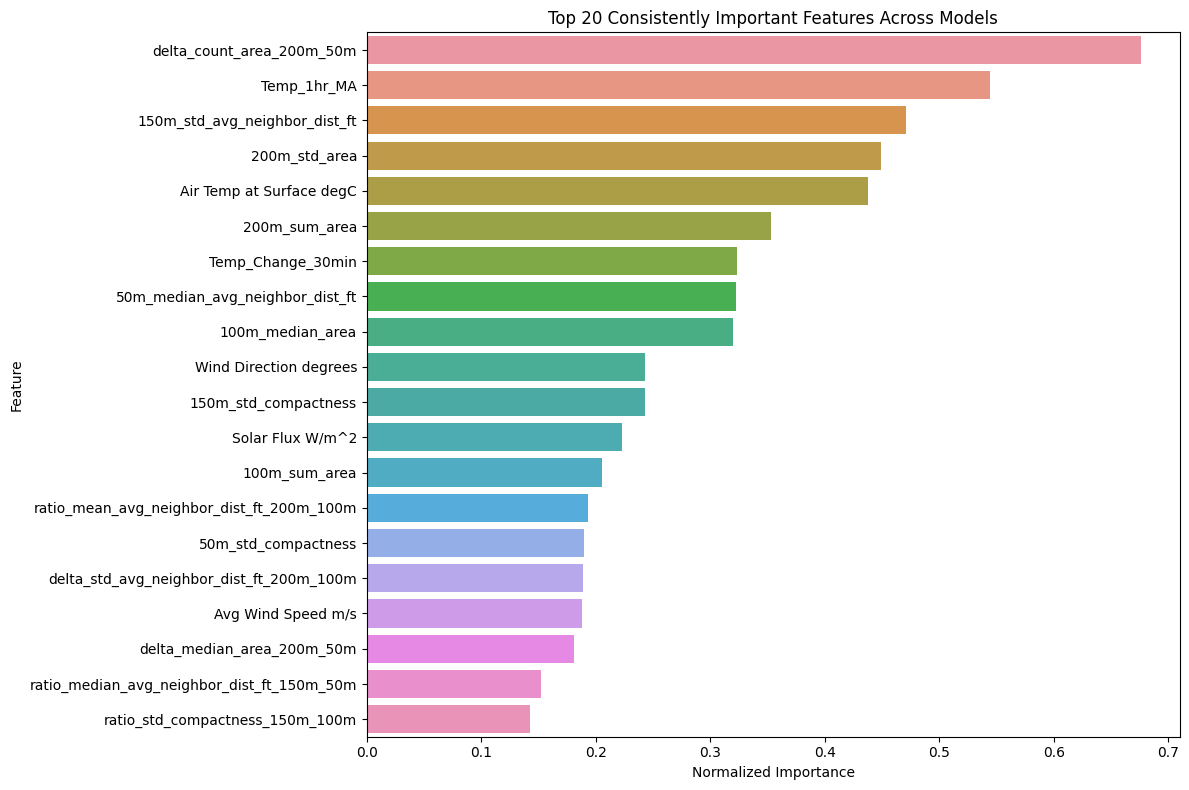

In [79]:
# Final selected features
final_features = ['Avg Wind Speed m/s', 'Temp_Change_30min', 'Temp_1hr_MA', 'Wind Direction degrees',
                  'Solar Flux W/m^2', 'Air Temp at Surface degC', '50m_count_area', '50m_std_compactness',
                  '50m_median_avg_neighbor_dist_ft', '100m_median_area', '100m_sum_area', '150m_std_compactness',
                  '150m_std_avg_neighbor_dist_ft', '200m_std_area', '200m_sum_area', 'delta_count_area_200m_50m',
                  'ratio_count_area_200m_50m', 'ratio_median_area_100m_50m', 'delta_median_area_200m_50m', 'ratio_median_area_200m_50m',
                  'ratio_median_area_200m_100m', 'ratio_std_compactness_100m_50m', 'ratio_std_compactness_150m_100m', 'ratio_median_avg_neighbor_dist_ft_150m_50m',
                  'delta_std_avg_neighbor_dist_ft_100m_50m', 'ratio_std_avg_neighbor_dist_ft_100m_50m', 'ratio_std_avg_neighbor_dist_ft_150m_100m', 'delta_std_avg_neighbor_dist_ft_200m_100m',
                  'ratio_std_avg_neighbor_dist_ft_200m_150m', 'ratio_mean_avg_neighbor_dist_ft_200m_100m'
                 ]

# Define features and target
X = enhanced_train[final_features]
y = enhanced_train['UHI Index']

# Define models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=1),
    'HistGB': HistGradientBoostingRegressor(max_iter=200, learning_rate=0.1, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42, n_jobs=1),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42)
}

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = {}

print("--- Training Models with 5-Fold Cross-Validation ---")
for name, model in models.items():
    print(f"\n{name} in progress...")
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1)
    r2_scores[name] = np.mean(scores)
    print(f"  Mean R2: {r2_scores[name]:.4f} | Std: {np.std(scores):.4f}")

# Function to compute and normalize importance
def compute_multi_model_feature_importance(X, y, models_dict, top_n=10):
    importance_dfs = []

    for name, model in models_dict.items():
        print(f"\nFitting {name} for feature importance...")
        model.fit(X, y)
        
        if hasattr(model, "feature_importances_"):
            importance = model.feature_importances_
        elif hasattr(model, "coef_"):
            importance = np.abs(model.coef_).flatten()
        else:
            print(f"Using permutation importance for {name}...")
            result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
            importance = result.importances_mean

        # Normalize importance
        normalized = importance / np.max(importance)
        df = pd.DataFrame({
            'Feature': X.columns,
            f'{name}_Importance': normalized
        })
        importance_dfs.append(df)

    from functools import reduce
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='Feature'), importance_dfs)

    # Mean importance
    importance_cols = [col for col in merged_df.columns if col.endswith('_Importance')]
    merged_df['Mean_Importance'] = merged_df[importance_cols].mean(axis=1)

    return merged_df.sort_values(by='Mean_Importance', ascending=False)

# --- Feature Importance Across Models ---
print("\n--- Aggregating Feature Importance Across All Models ---")
importance_df = compute_multi_model_feature_importance(X, y, models)

# Show top features
print("\nTop 5 Most Consistently Important Features:")
print(importance_df[['Feature', 'Mean_Importance']].head(5).to_string(index=False))

# --- R2 Score Table ---
print("\nFinal Cross-Validation R2 Scores:")
r2_scores_df = pd.DataFrame(r2_scores.items(), columns=['Model', 'R2']).set_index('Model').sort_values(by='R2', ascending=False)
print(r2_scores_df.to_string(float_format="%.4f"))

# --- Feature Importance Plot ---
plt.figure(figsize=(12, 8))
sns.barplot(x='Mean_Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Consistently Important Features Across Models')
plt.xlabel('Normalized Importance')
plt.tight_layout()
plt.show()


In [80]:
importance_df

Feature  RandomForest_Importance  \
15                   delta_count_area_200m_50m                     1.00   
2                                  Temp_1hr_MA                     0.64   
12               150m_std_avg_neighbor_dist_ft                     0.25   
13                               200m_std_area                     0.56   
5                     Air Temp at Surface degC                     0.56   
14                               200m_sum_area                     0.45   
1                            Temp_Change_30min                     0.43   
8              50m_median_avg_neighbor_dist_ft                     0.27   
9                             100m_median_area                     0.33   
3                       Wind Direction degrees                     0.23   
11                        150m_std_compactness                     0.23   
4                             Solar Flux W/m^2                     0.23   
10                               100m_sum_area                     0.18   
29   ratio_mean_avg_neighbor_dist_ft_200m_100m                     0.15   
7                          50m_std_compactness                     0.20   
27    delta_std_avg_neighbor_dist_ft_200m_100m                     0.18   
0                           Avg Wind Speed m/s                     0.26   
18                  delta_median_area_200m_50m                     0.10   
23  ratio_median_avg_neighbor_dist_ft_150m_50m                     0.09   
22             ratio_std_compactness_150m_100m                     0.11   
20                 ratio_median_area_200m_100m                     0.10   
28    ratio_std_avg_neighbor_dist_ft_200m_150m                     0.08   
19                  ratio_median_area_200m_50m                     0.10   
21              ratio_std_compactness_100m_50m                     0.06   
17                  ratio_median_area_100m_50m                     0.04   
26    ratio_std_avg_neighbor_dist_ft_150m_100m                     0.04   
24     delta_std_avg_neighbor_dist_ft_100m_50m                     0.04   
16                   ratio_count_area_200m_50m                     0.04   
25     ratio_std_avg_neighbor_dist_ft_100m_50m                     0.04   
6                               50m_count_area                     0.04   

    HistGB_Importance  XGBoost_Importance  LightGBM_Importance  \
15               0.66                0.78                 0.48   
2                1.00                0.56                 0.52   
12               0.16                0.19                 0.76   
13               0.43                0.26                 1.00   
5                0.41                1.00                 0.22   
14               0.35                0.28                 0.68   
1                0.29                0.40                 0.50   
8                0.18                0.21                 0.65   
9                0.30                0.25                 0.72   
3                0.23                0.31                 0.44   
11               0.15                0.11                 0.73   
4                0.13                0.30                 0.45   
10               0.14                0.14                 0.57   
29               0.12                0.11                 0.59   
7                0.10                0.19                 0.46   
27               0.09                0.15                 0.52   
0                0.14                0.18                 0.36   
18               0.15                0.18                 0.48   
23               0.05                0.10                 0.51   
22               0.08                0.10                 0.43   
20               0.06                0.10                 0.40   
28               0.05                0.08                 0.38   
19               0.04                0.11                 0.29   
21               0.04                0.06                 0.31   
17               0.03                0.07                 0.29 

## Feature Importance Analysis & Selection Strategy (Pre-Satellite Integration)

After running a full-feature model using all 28 selected predictors, feature importance scores were computed to evaluate each feature's contribution to predicting the **Urban Heat Island (UHI) Index**. These importance scores are essential for refining the feature set before integrating satellite-derived variables.

### Why Feature Pruning is Important

Before introducing new satellite-based features, it’s critical to:

* **Retain the strongest, most informative features** to anchor the model.
* **Remove weak or redundant features** to reduce noise and prevent overfitting.
* **Ensure interpretability and efficiency** as the feature space grows.

This makes room for new satellite data to contribute meaningfully without being drowned out by weak, correlated, or unnecessary predictors.

### Summary of Feature Importance Results

| Rank | Feature | Mean Importance |
| :--- | :--- | :--- |
| 1 | `delta_count_area_200m_50m` | **0.68** |
| 2 | `Temp_1hr_MA` | **0.54** |
| 3 | `150m_std_avg_neighbor_dist_ft` | **0.47** |
| 4 | `200m_std_area` | **0.45** |
| 5 | `Air Temp at Surface degC` | **0.44** |
| 6 | `200m_sum_area` | **0.35** |
| 7 | `Temp_Change_30min` | **0.32** |
| 8 | `50m_median_avg_neighbor_dist_ft` | **0.32** |
| 9 | `100m_median_area` | **0.32** |
| 10 | `Wind Direction degrees` | **0.24** |
| 11 | `150m_std_compactness` | **0.24** |
| 12 | `Solar Flux W/m^2` | **0.22** |
| 13 | `100m_sum_area` | **0.21** |
| 14–28 | Remaining 15 features | **< 0.20** (all below the 0.20 threshold) |


### Selected Features

**Selected based on an importance threshold of ≥ 0.20**, these 13 features represent the most valuable predictors in the current UHI model:

#### Spatial Features:
* `200m_std_area`
* `200m_sum_area`
* `150m_std_avg_neighbor_dist_ft`
* `150m_std_compactness`
* `100m_median_area`
* `100m_sum_area`
* `50m_median_avg_neighbor_dist_ft`

#### Meteorological Features:
* `Temp_1hr_MA`
* `Air Temp at Surface degC`
* `Temp_Change_30min`
* `Wind Direction degrees`
* `Solar Flux W/m^2`

#### Engineered Gradient Features:
* `delta_count_area_200m_50m`

**Why these were chosen:**
* **Engineered Features are Key:** The most important feature is an engineered `delta` feature, which powerfully validates the strategy of creating gradient-based features. This shows that the **change in urban density across distances** is a stronger predictor than raw urban metrics.
* **The Urban Fabric is a Complex Mix:** The top features are a mix of scales (150m and 200m) and metrics (building spacing and size variability), highlighting that the UHI phenomenon is influenced by a complex interplay of multiple spatial factors.
* **Meteorology Still Matters:** As expected, meteorological variables like recent temperature and solar flux are still crucial predictors. The results confirm that to accurately model UHI, you must consider both the ambient weather and the physical urban environment simultaneously.

### Why the other features were removed:

* **Low Impact:** These features contributed minimally to the model’s performance.
* **Redundant or Less Informative:** Their information is likely captured better by related features that remain in the model. For example:
    * `delta_count_area_200m_50m` (0.68) offers a clearer spatial transition than `ratio_count_area_200m_50m` (0.08).
    * `50m_count_area` is outperformed by other `50m` features, which provide a richer description of urban form.

### Moving Forward

With a refined, high-signal feature set in place, the next phase will integrate **satellite-derived variables**. This step is now more strategic because:

1.  **Noise has been eliminated**, improving the model’s ability to learn from new variables.
2.  **The current features are interpretable**, which will allow clearer attribution of improvements once satellite data is added.
3.  **Key diversity preserved key diversity**: Spatial form, thermal conditions, and engineered transitions are all still well represented.

This lean yet powerful feature base sets a strong foundation for building a **multi-modal UHI model** that fuses ground-level data with remote sensing insights.

In [ ]:
retained_features = [# 🌇 Spatial Features
    "200m_std_area", "200m_sum_area", "150m_std_avg_neighbor_dist_ft", "150m_std_compactness", 
    "100m_median_area", "100m_sum_area","50m_median_avg_neighbor_dist_ft",
    # 🌡️ Meteorological Features
    "Temp_1hr_MA", "Air Temp at Surface degC", "Temp_Change_30min",
    "Wind Direction degrees", "Solar Flux W/m^2",
    # 🔧 Engineered Gradient Features
    "delta_count_area_200m_50m"
]

print("\nNumber of features after model training")
len(retained_features)

In [87]:
# Your lists of column names
df_train_cols = ["datetime", "Location", "200m_std_area", "200m_sum_area",
                 "150m_std_avg_neighbor_dist_ft", "150m_std_compactness", "100m_median_area",
                 "100m_sum_area", "50m_median_avg_neighbor_dist_ft", "Temp_1hr_MA",
                 "Air Temp at Surface degC", "Temp_Change_30min", "Wind Direction degrees",
                 "Solar Flux W/m^2", "delta_count_area_200m_50m", "UHI Index"]

df_test_cols = ["datetime", "Location", "200m_std_area", "200m_sum_area",
                "150m_std_avg_neighbor_dist_ft", "150m_std_compactness", "100m_median_area",
                "100m_sum_area", "50m_median_avg_neighbor_dist_ft", "Temp_1hr_MA",
                "Air Temp at Surface degC", "Temp_Change_30min", "Wind Direction degrees",
                "Solar Flux W/m^2", "delta_count_area_200m_50m", "UHI Index"]

# Create the DataFrames by selecting the columns from the master DataFrame
df_train = enhanced_train[df_train_cols]
df_test = enhanced_test[df_test_cols]

# Display the head of the new DataFrames to confirm
print("df_train head:")
print(df_train.head())
print("\ndf_test head:")
print(df_test.head())

df_train head:
             datetime   Location  200m_std_area  200m_sum_area  \
0 2021-07-24 15:51:00  Manhattan           0.00       12285.39   
1 2021-07-24 15:13:00  Manhattan       48882.05      635141.49   
2 2021-07-24 15:47:00      Bronx       29676.97      420145.98   
3 2021-07-24 15:32:00  Manhattan       22124.22      558212.27   
4 2021-07-24 15:52:00  Manhattan           0.00       12285.39   

   150m_std_avg_neighbor_dist_ft  150m_std_compactness  100m_median_area  \
0                           0.00                  0.00          12285.39   
1                          24.04                  0.19          25455.67   
2                          35.27                  0.20          23220.07   
3                          32.16                  0.12          19945.79   
4                           0.00                  0.00          12285.39   

   100m_sum_area  50m_median_avg_neighbor_dist_ft  Temp_1hr_MA  \
0       12285.39                           903.83         0.07   

In [88]:
# Now check
assert df_train.index.equals(train_coords.index)

In [89]:
# Now check
assert df_test.index.equals(test_coords.index)